## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [89]:
pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 552.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 492.6 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [90]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")


## Loading the dataset

In [2]:
# read the csv into the Notebook
data = pd.read_csv("train.csv.csv")

In [3]:
# create a copy to keep the original dataframe safe
df = data.copy()

## Data Overview

- Observations
- Sanity checks

In [4]:
# view the data
df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511 -2.910870   
1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938  0.732600   
2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824 -2.098941   
3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780  0.207309   
4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960  0.205433   

         V8        V9       V10  ...       V32       V33        V34       V35  \
0  0.050714 -1.522351  3.761892  ...  3.059700 -1.690440   2.846296  2.235198   
1 -4.332135  0.565695 -0.101080  ... -1.795474  3.032780  -2.467514  1.894599   
2 -3.173204 -2.081860  5.392621  ... -0.257101  0.803550   4.086219  2.292138   
3 -2.493629  0.344926  2.118578  ... -3.584425 -2.577474   1.363769  0.622714   
4  4.848994 -1.854920 -6.220023  ...  8.265896  6.629213 -10.068689  1.222987   

        V36       V37       V38       V39       V40  Target  
0  6.667486  0.443809 -2.369169  2.950578 -3.480324       0  
1 -2.297780 -1.731048  5.908837 -0.386345  0.616242       0  
2  5.360850  0.351993  2.940021  3.839160 -4.309402       0  
3  5.550100 -1.526796  0.138853  3.101430 -1.277378       0  
4 -3.229763  1.686909 -2.163896 -3.644622  6.510338       0  

[5 rows x 41 columns]

In [9]:
# determine the shape of the data
df.shape

(20000, 41)

#### Observations:

* There are 20,0000 rows and 41 columns

In [12]:
# determine missing values and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

#### Observations:

* All independent variables are float64 type
* The dependent variable is an int64 type

In [11]:
# determine missing values numbers per column
df.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

#### Observations:

* V1 and V2 are each missing 18 values
* All other variables have no missing values

In [15]:
# determine number of rows duplicated
df.duplicated().sum()

0

In [46]:
# determine number of unique values
df.nunique()

V1        19982
V2        19982
V3        20000
V4        20000
V5        20000
V6        20000
V7        20000
V8        20000
V9        20000
V10       20000
V11       20000
V12       20000
V13       20000
V14       20000
V15       20000
V16       20000
V17       20000
V18       20000
V19       20000
V20       20000
V21       20000
V22       20000
V23       20000
V24       20000
V25       20000
V26       20000
V27       20000
V28       20000
V29       20000
V30       20000
V31       20000
V32       20000
V33       20000
V34       20000
V35       20000
V36       20000
V37       20000
V38       20000
V39       20000
V40       20000
Target        2
dtype: int64

#### Observations:

* Every independent variable value in the dataset is unique
* The Target variable only has 2 unique values

#### Observations:

* There are no duplicate rows

In [17]:
# describe the data
df.describe()

V1            V2            V3            V4            V5  \
count  19982.000000  19982.000000  20000.000000  20000.000000  20000.000000   
mean      -0.271996      0.440430      2.484699     -0.083152     -0.053752   
std        3.441625      3.150784      3.388963      3.431595      2.104801   
min      -11.876451    -12.319951    -10.708139    -15.082052     -8.603361   
25%       -2.737146     -1.640674      0.206860     -2.347660     -1.535607   
50%       -0.747917      0.471536      2.255786     -0.135241     -0.101952   
75%        1.840112      2.543967      4.566165      2.130615      1.340480   
max       15.493002     13.089269     17.090919     13.236381      8.133797   

                 V6            V7            V8            V9           V10  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      -0.995443     -0.879325     -0.548195     -0.016808     -0.012998   
std        2.040970      1.761626      3.295756      2.160568      2.193201   
min      -10.227147     -7.949681    -15.657561     -8.596313     -9.853957   
25%       -2.347238     -2.030926     -2.642665     -1.494973     -1.411212   
50%       -1.000515     -0.917179     -0.389085     -0.067597      0.100973   
75%        0.380330      0.223695      1.722965      1.409203      1.477045   
max        6.975847      8.006091     11.679495      8.137580      8.108472   

       ...           V32           V33           V34           V35  \
count  ...  20000.000000  20000.000000  20000.000000  20000.000000   
mean   ...      0.303799      0.049825     -0.462702      2.229620   
std    ...      5.500400      3.575285      3.183841      2.937102   
min    ...    -19.876502    -16.898353    -17.985094    -15.349803   
25%    ...     -3.420469     -2.242857     -2.136984      0.336191   
50%    ...      0.052073     -0.066249     -0.255008      2.098633   
75%    ...      3.761722      2.255134      1.436935      4.064358   
max    ...     23.633187     16.692486     14.358213     15.291065   

                V36           V37           V38           V39           V40  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       1.514809      0.011316     -0.344025      0.890653     -0.875630   
std        3.800860      1.788165      3.948147      1.753054      3.012155   
min      -14.833178     -5.478350    -17.375002     -6.438880    -11.023935   
25%       -0.943809     -1.255819     -2.987638     -0.272250     -2.940193   
50%        1.566526     -0.128435     -0.316849      0.919261     -0.920806   
75%        3.983939      1.175533      2.279399      2.057540      1.119897   
max       19.329576      7.467006     15.289923      7.759877     10.654265   

             Target  
count  20000.000000  
mean       0.055500  
std        0.228959  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 41 columns]

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [43]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
        
    )  # creating the 2 subplots
    
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet",
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Univariate Analysis

Variable:  V1 


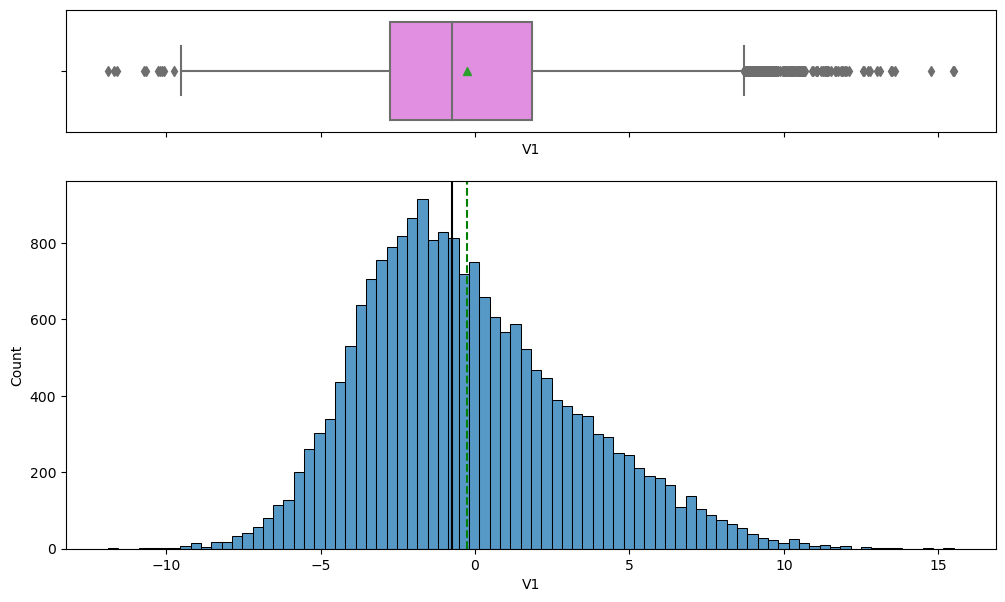

Variable:  V2 


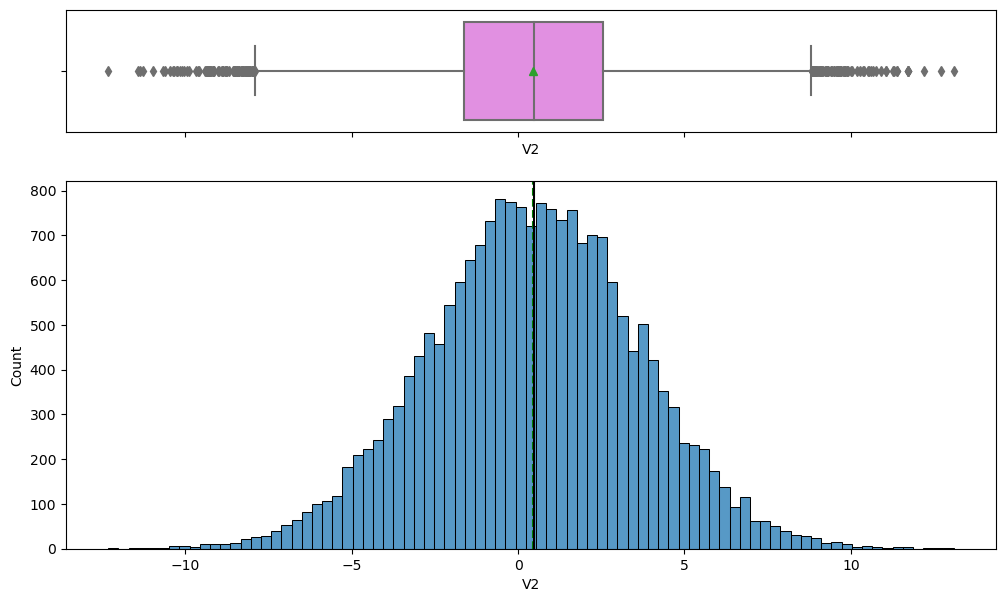

Variable:  V3 


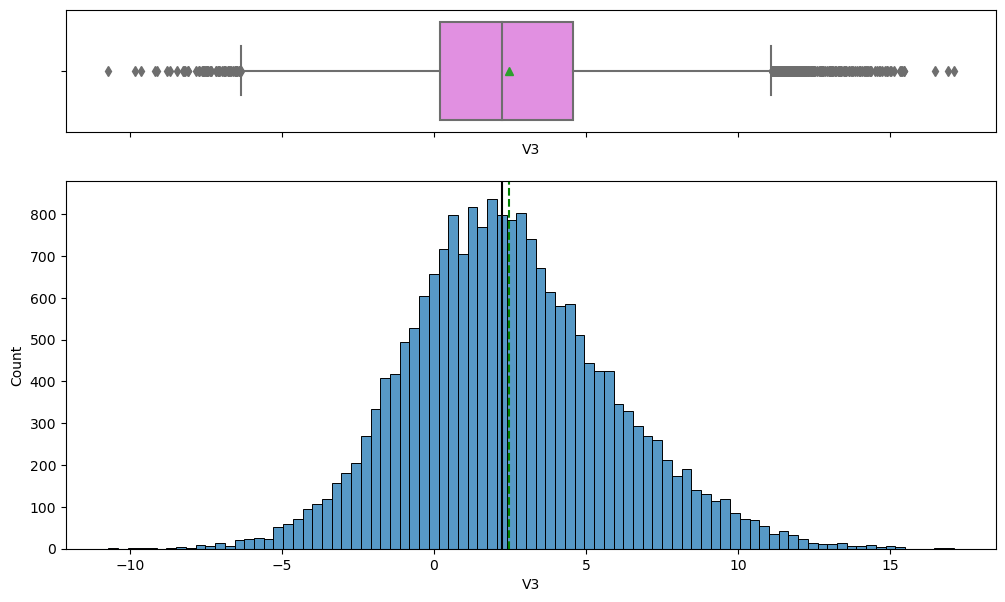

Variable:  V4 


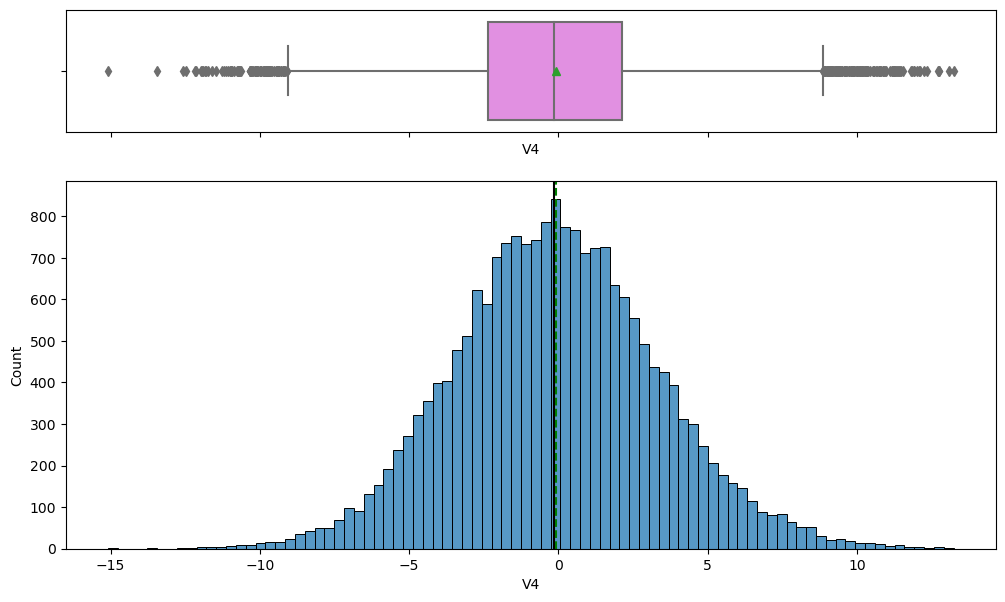

Variable:  V5 


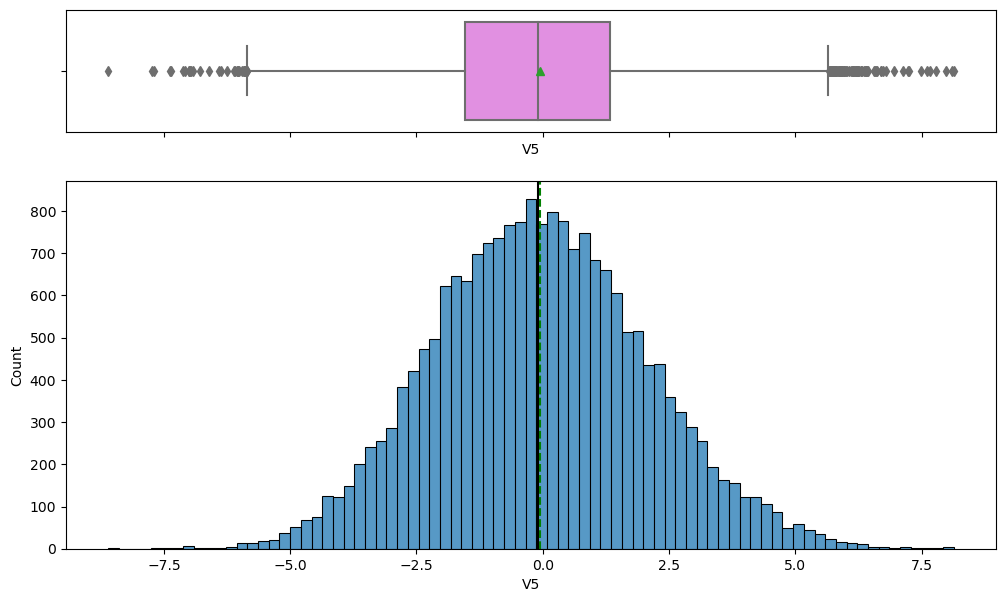

Variable:  V6 


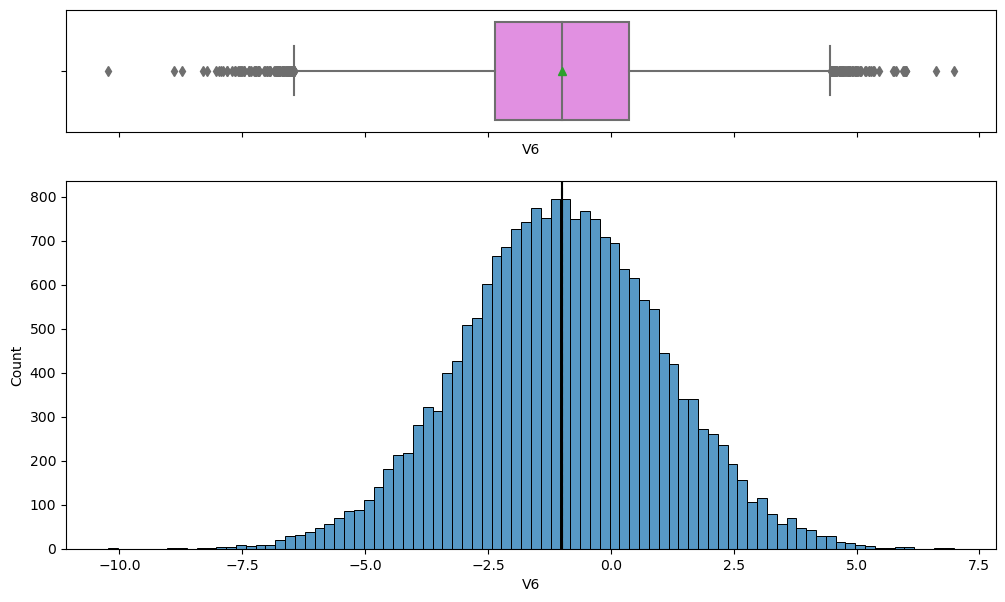

Variable:  V7 


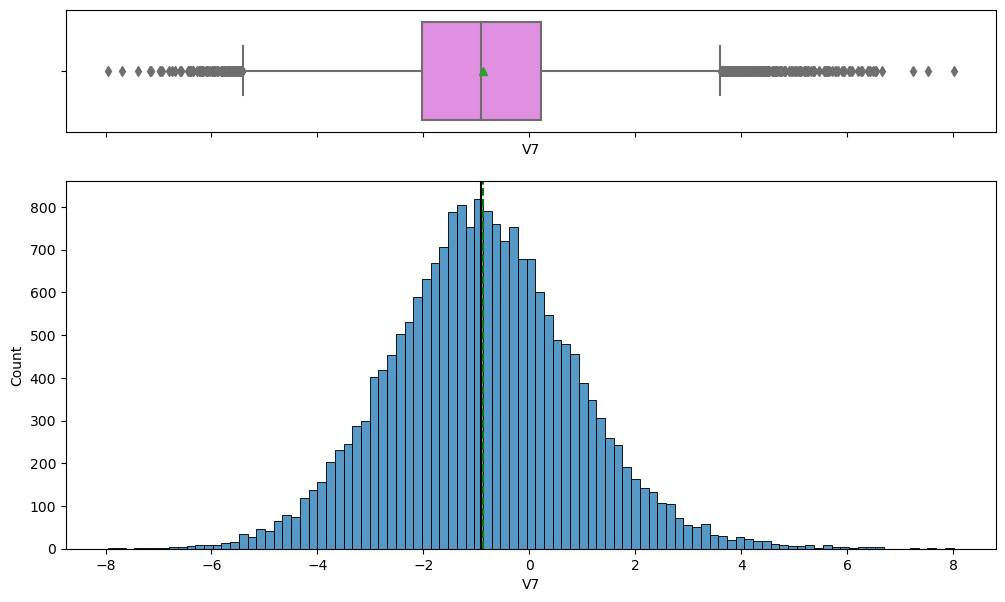

Variable:  V8 


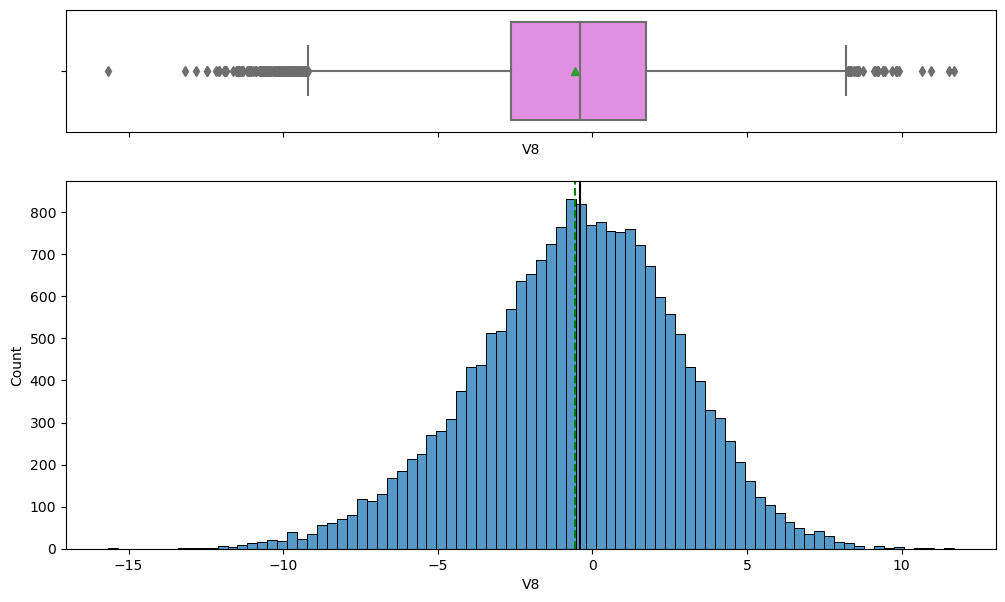

Variable:  V9 


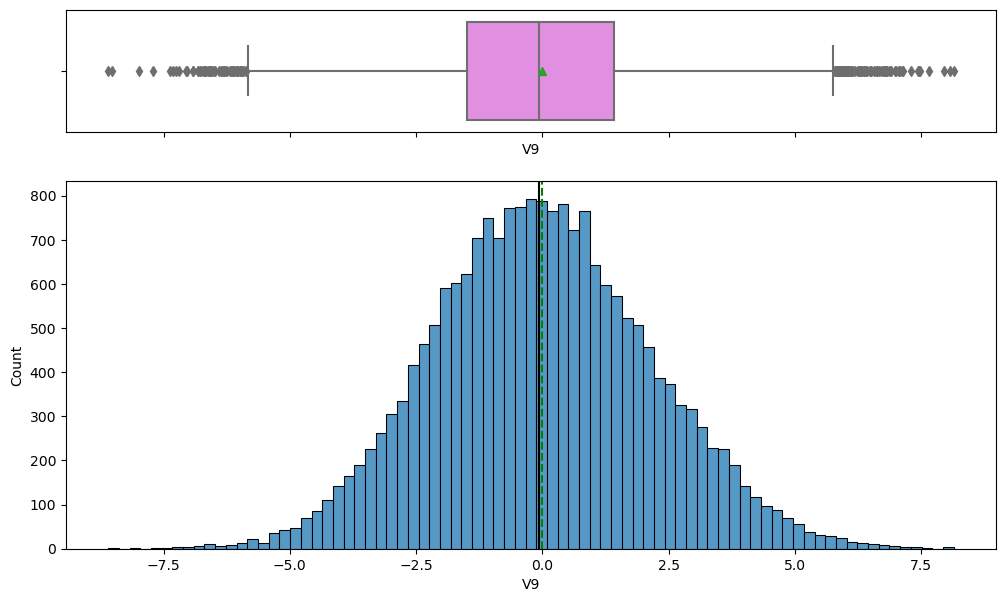

Variable:  V10 


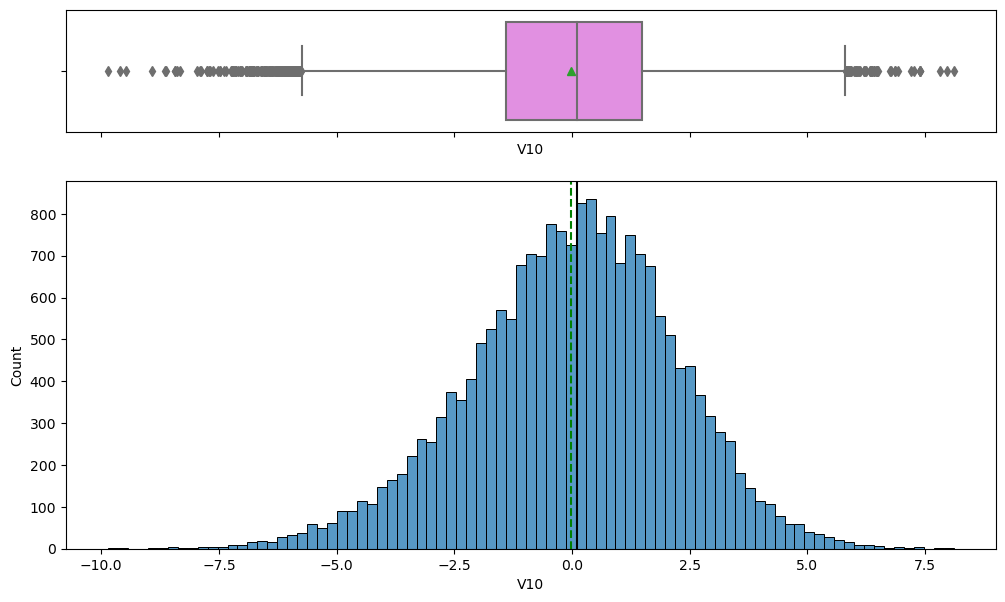

Variable:  V11 


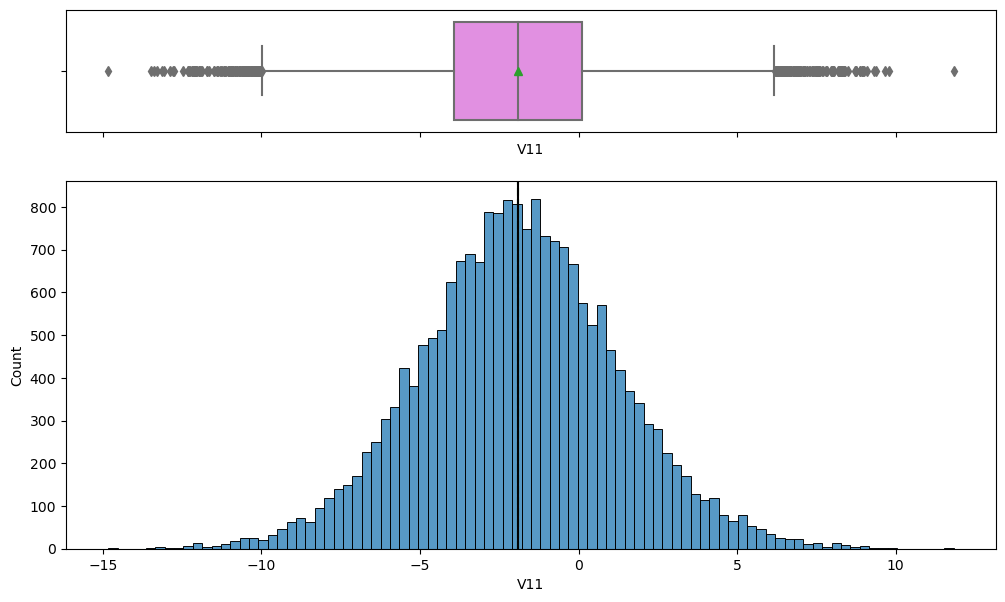

Variable:  V12 


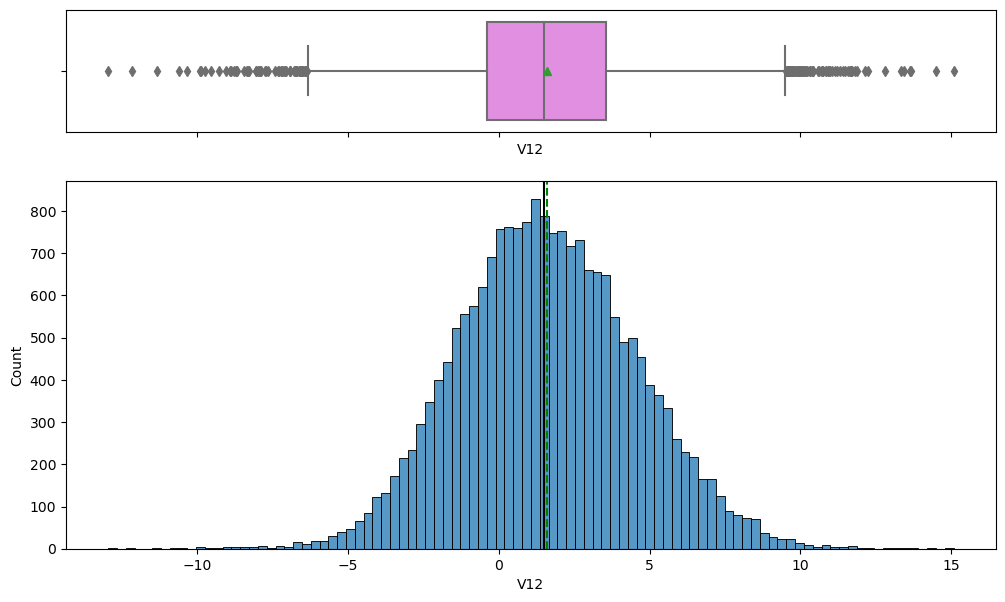

Variable:  V13 


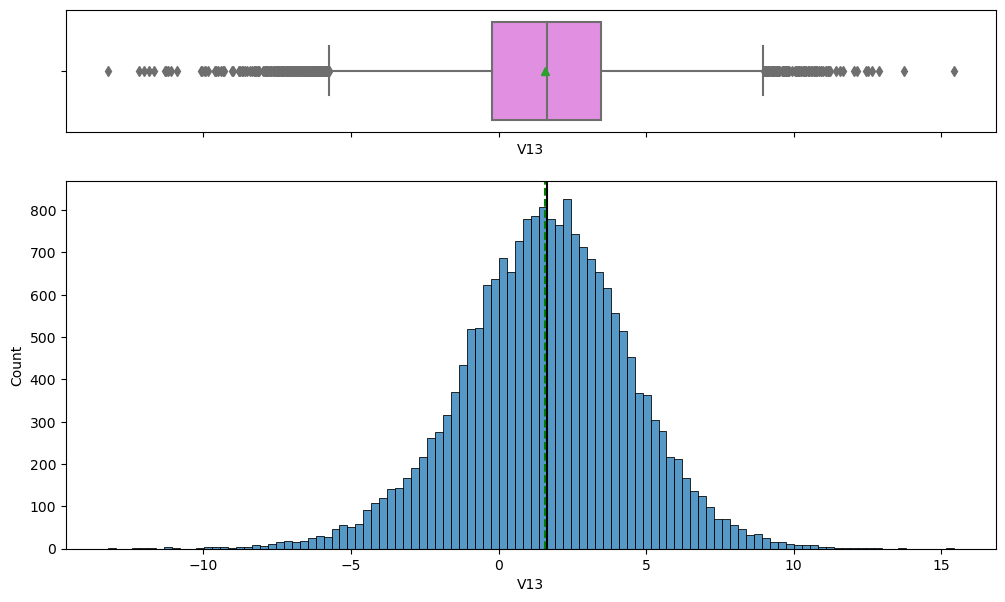

Variable:  V14 


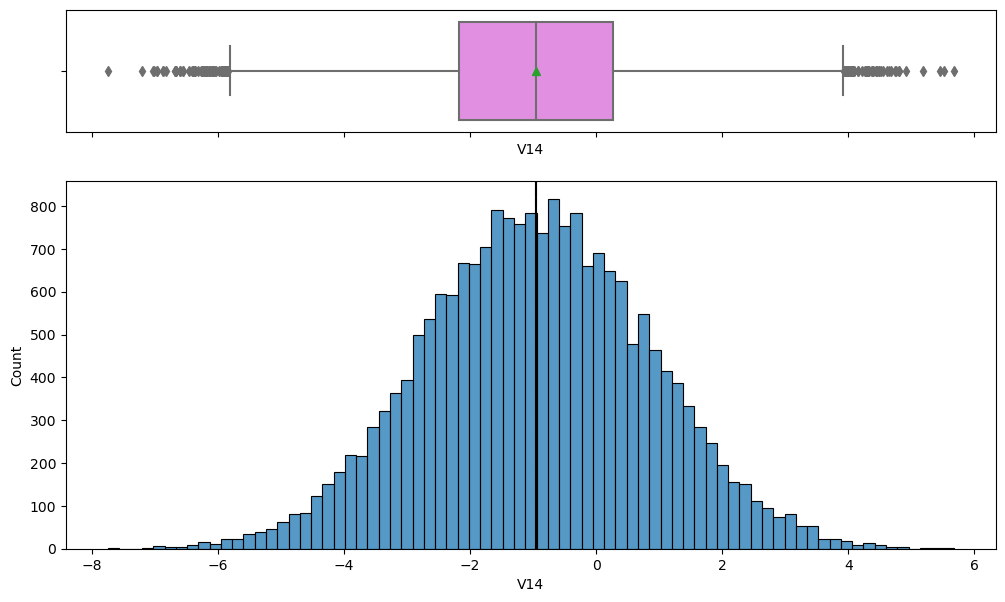

Variable:  V15 


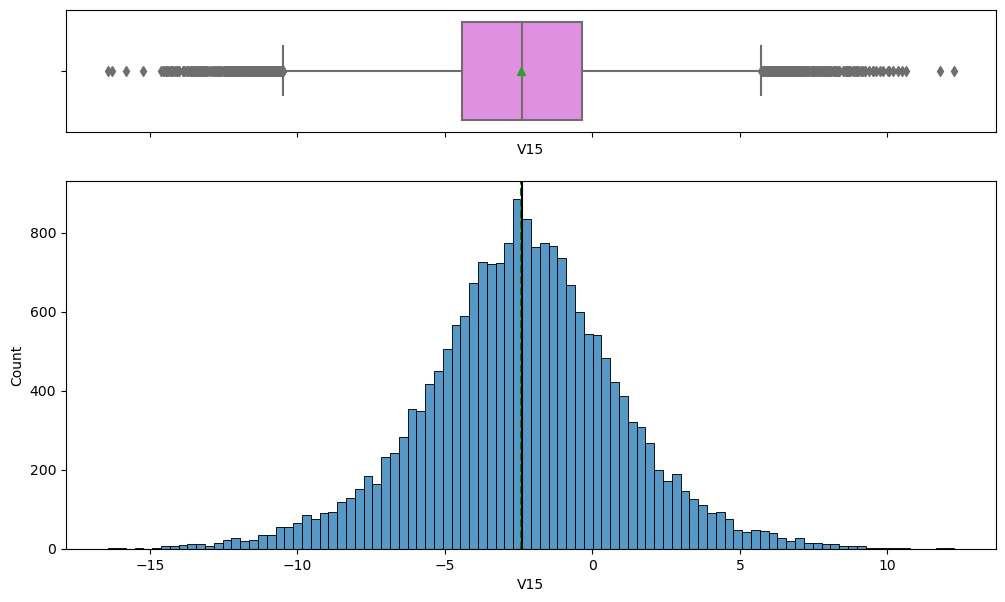

Variable:  V16 


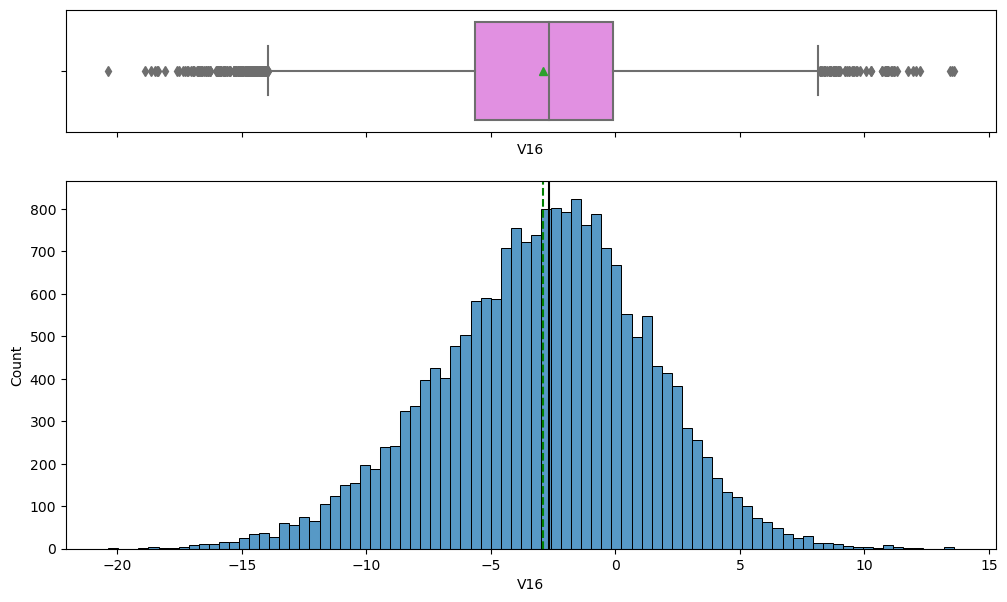

Variable:  V17 


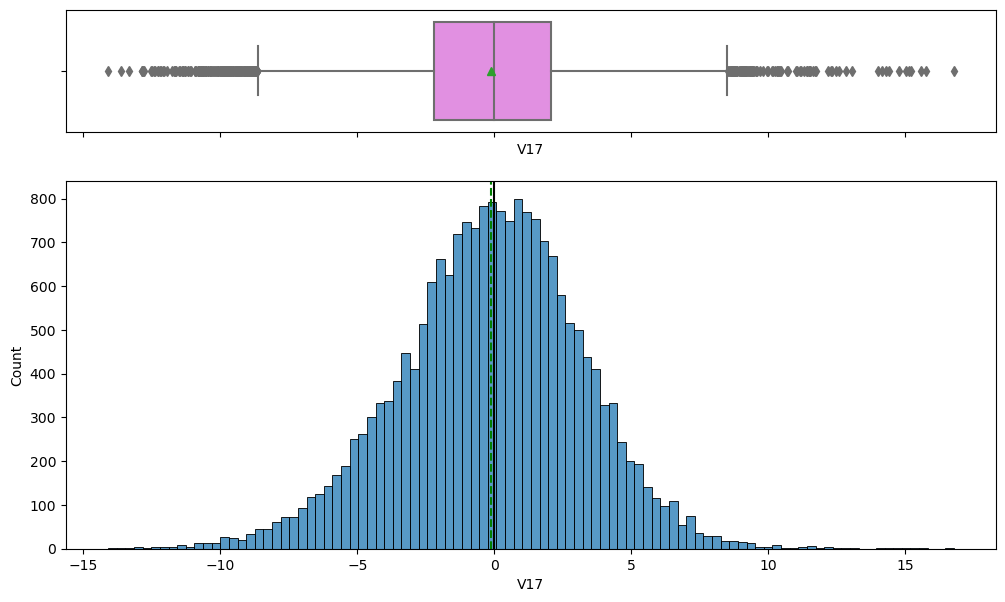

Variable:  V18 


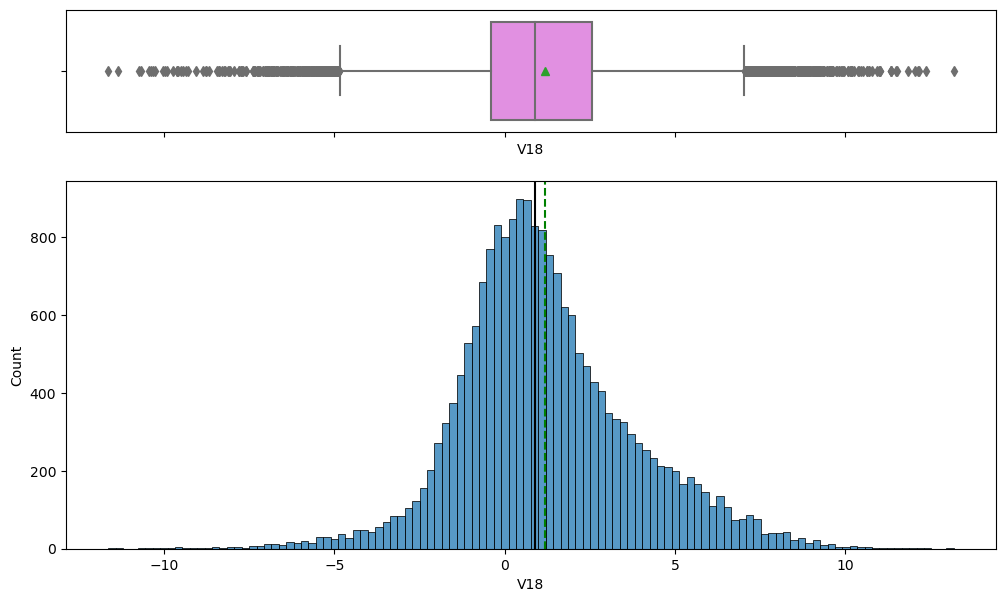

Variable:  V19 


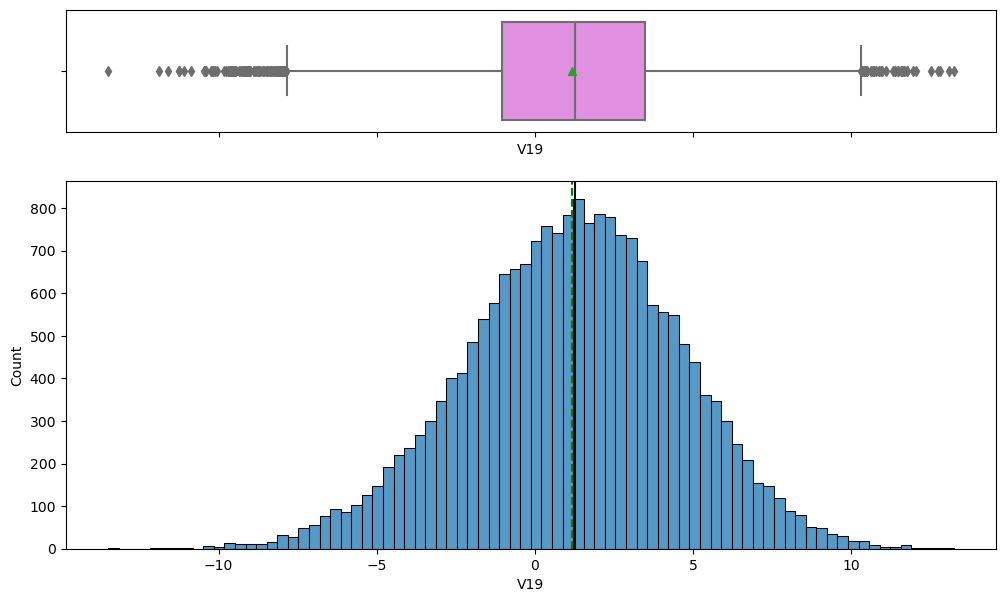

Variable:  V20 


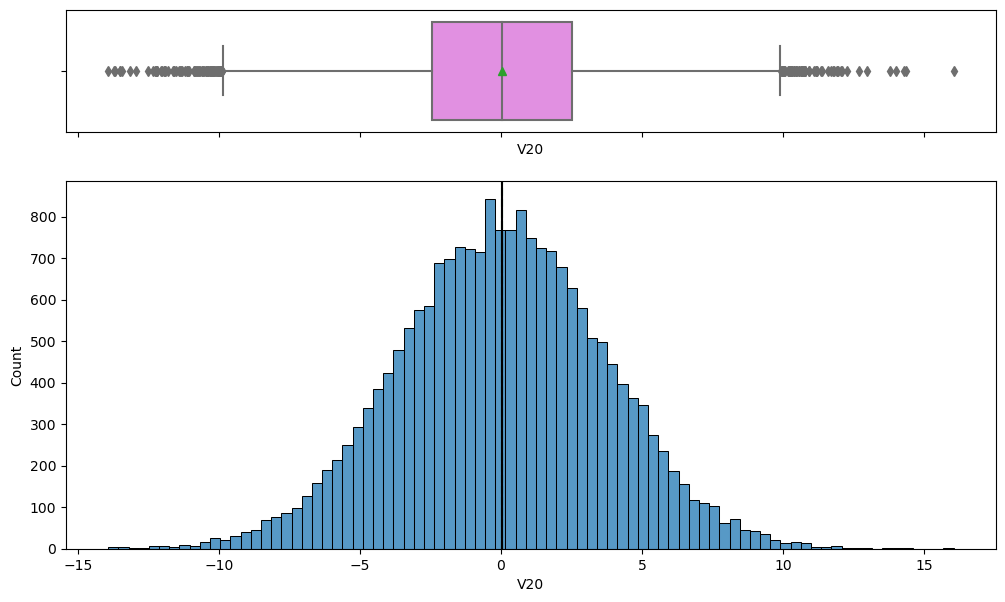

Variable:  V21 


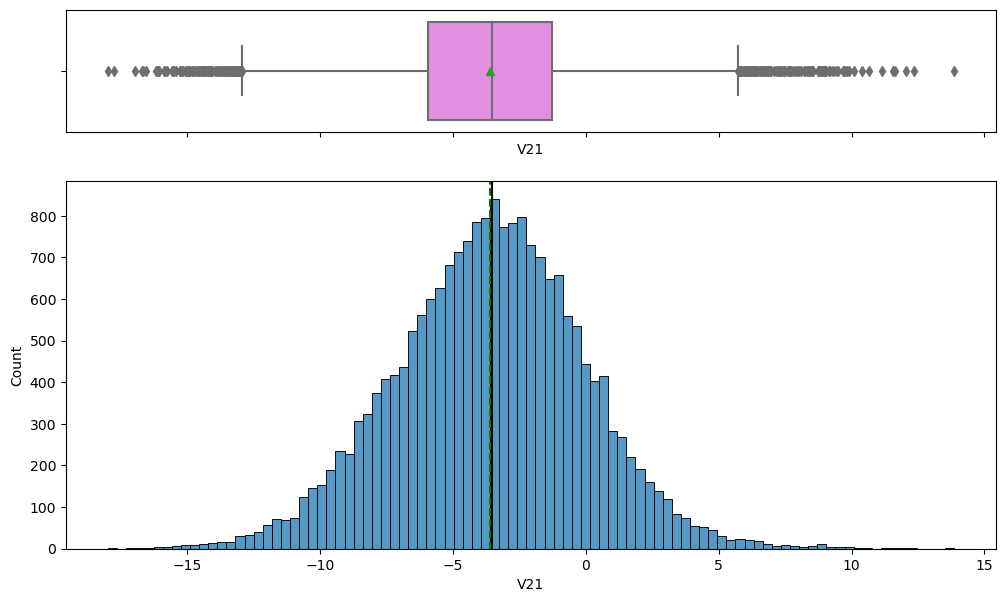

Variable:  V22 


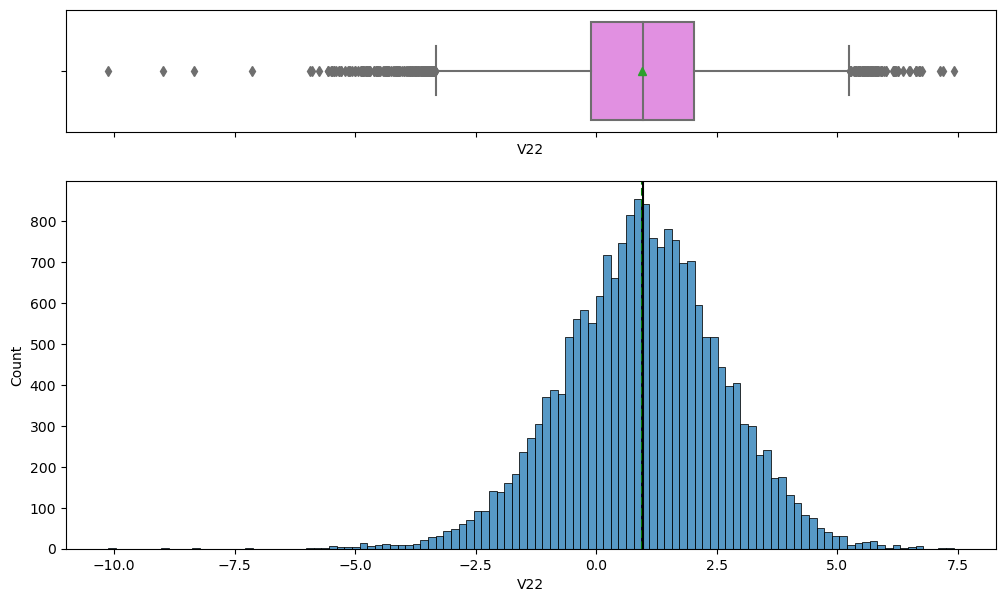

Variable:  V23 


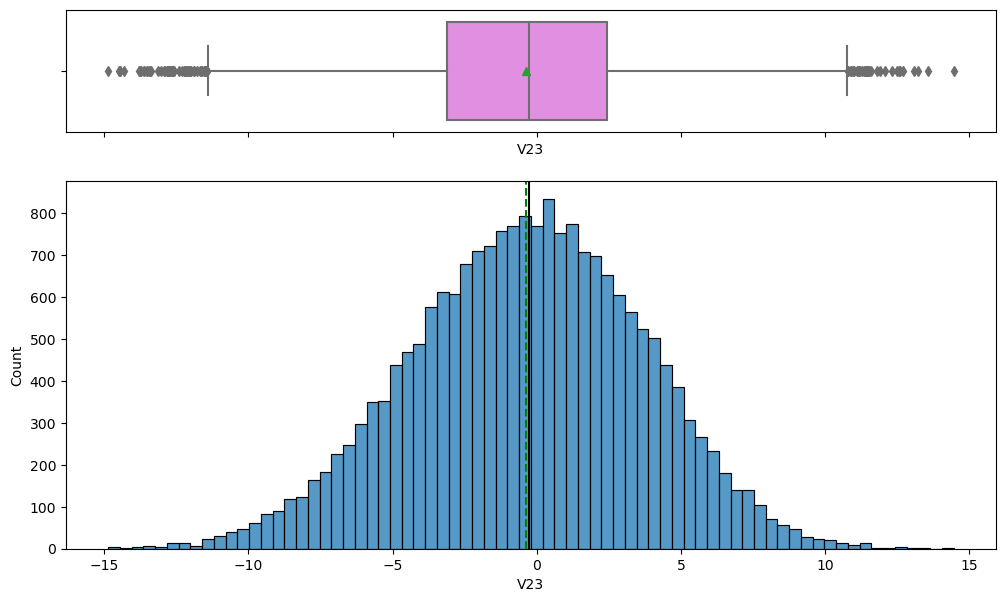

Variable:  V24 


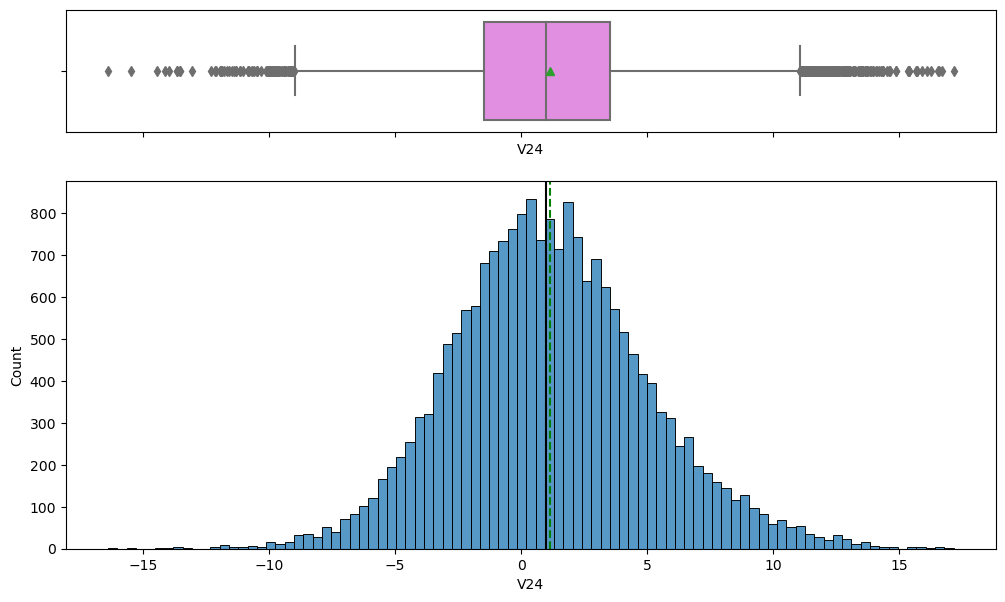

Variable:  V25 


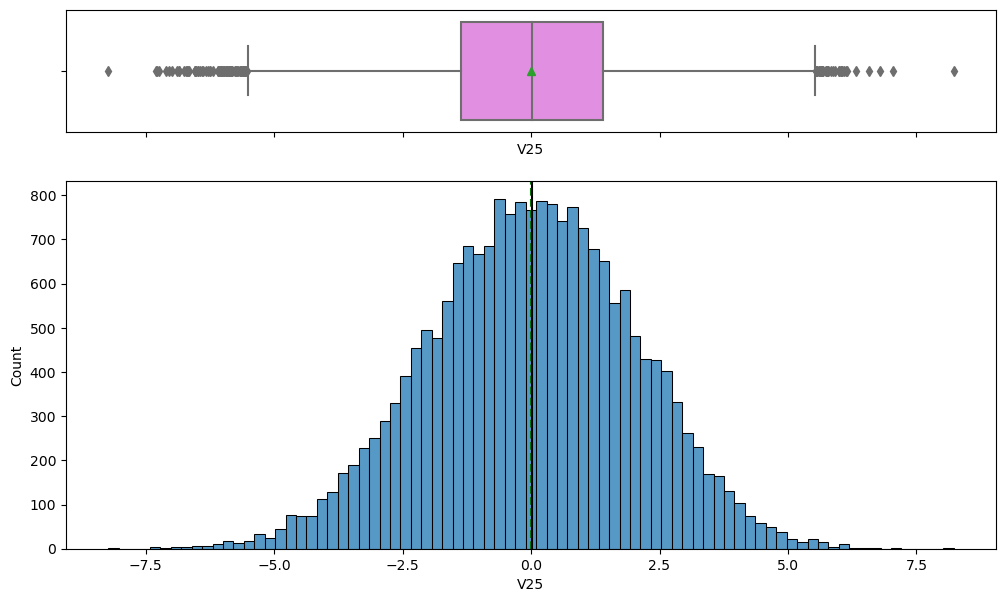

Variable:  V26 


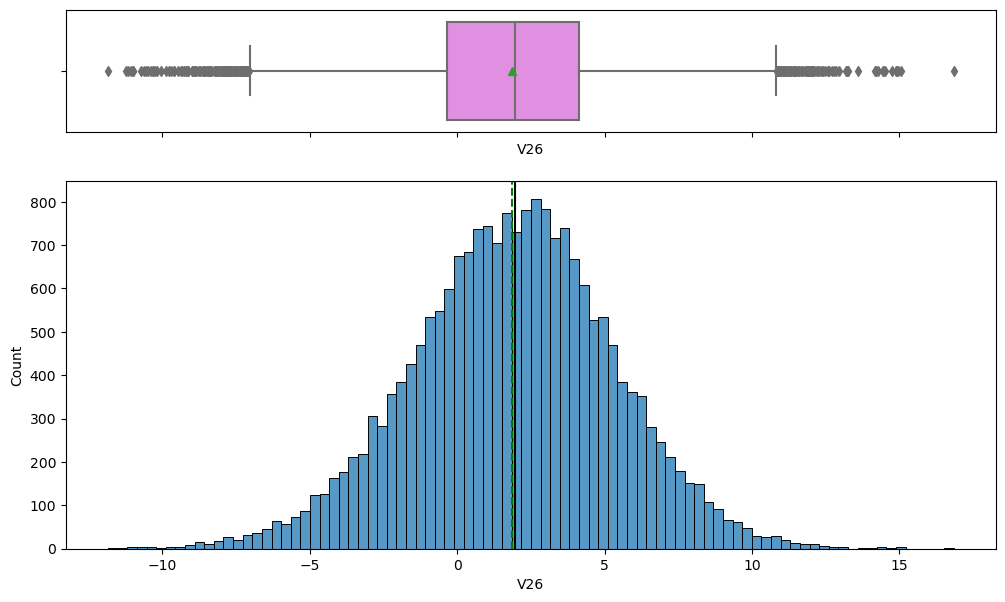

Variable:  V27 


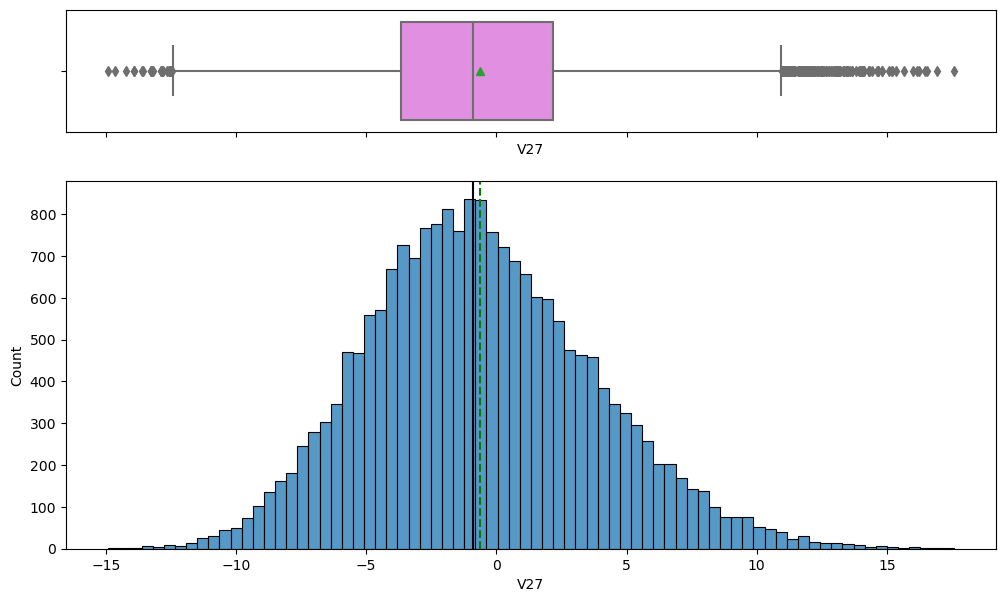

Variable:  V28 


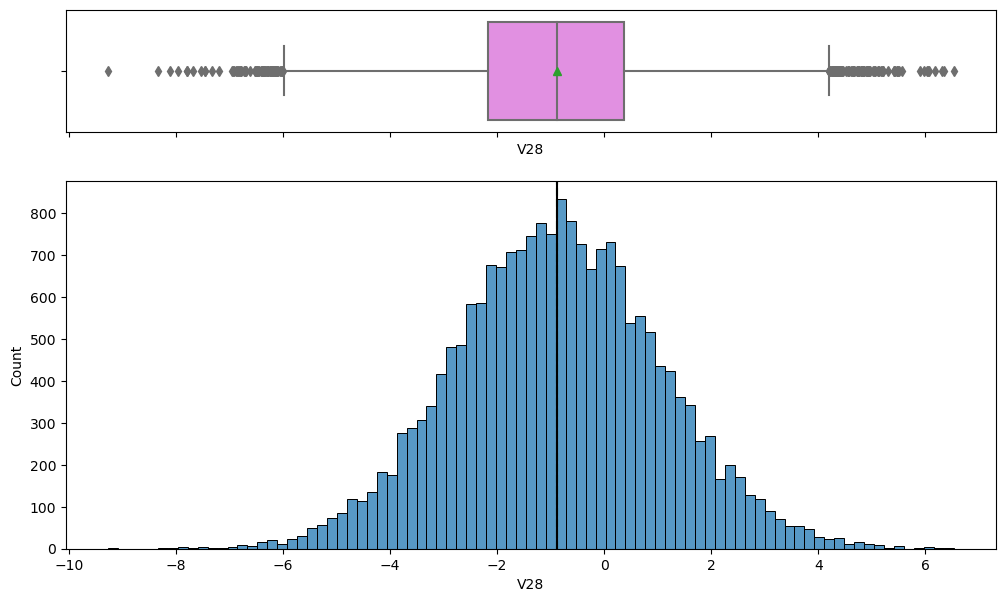

Variable:  V29 


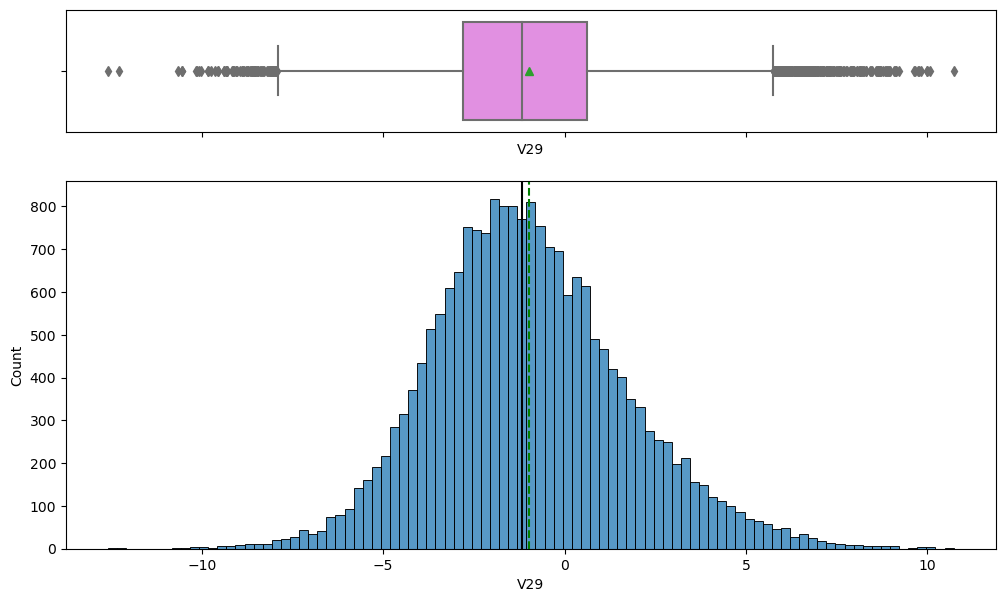

Variable:  V30 


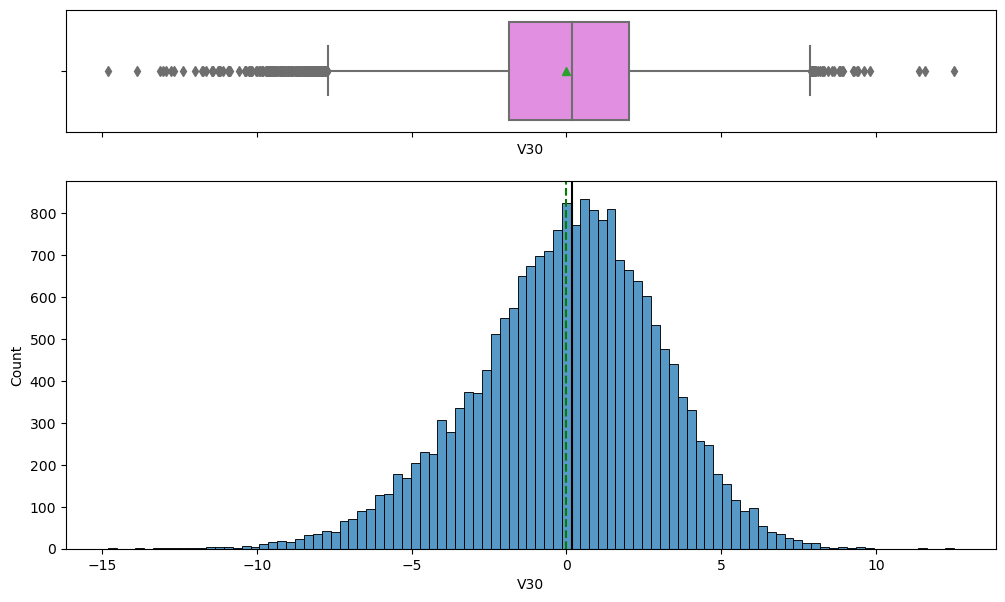

Variable:  V31 


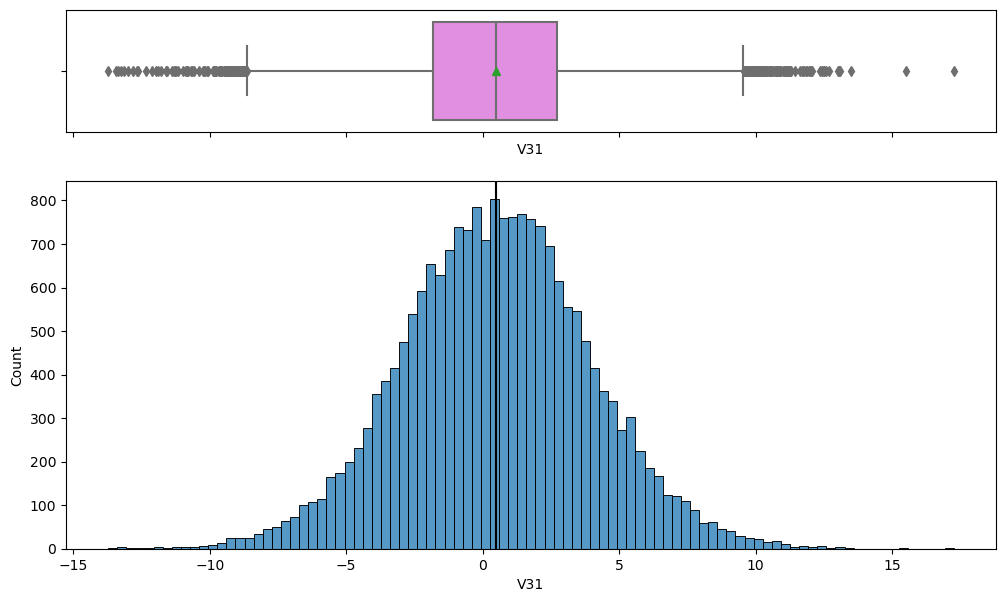

Variable:  V32 


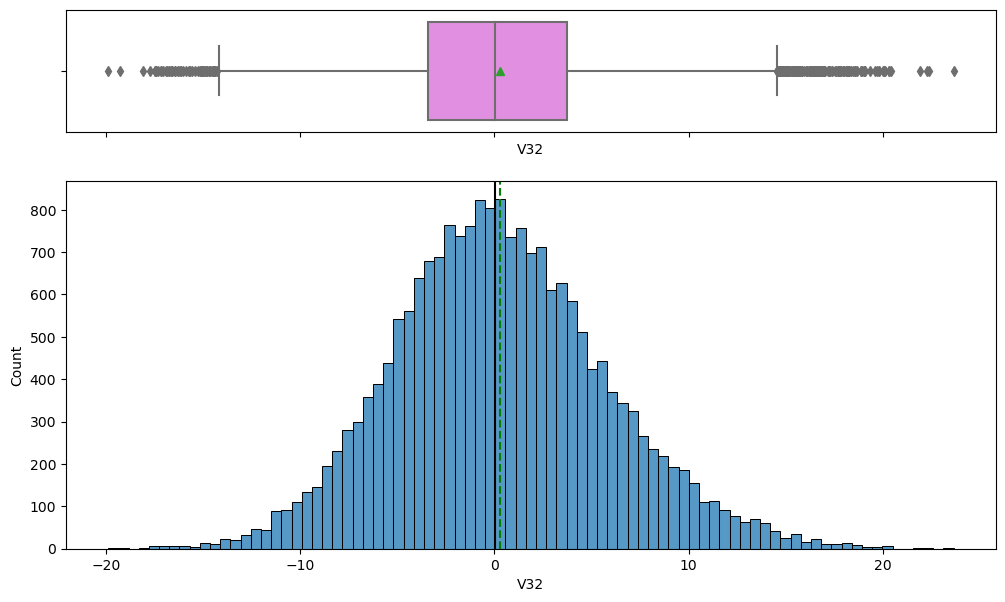

Variable:  V33 


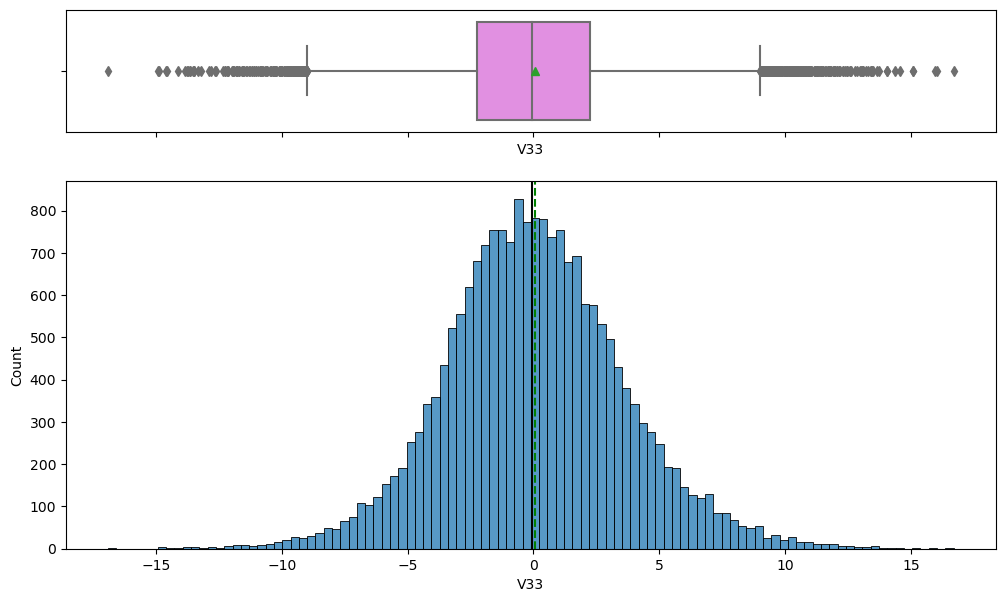

Variable:  V34 


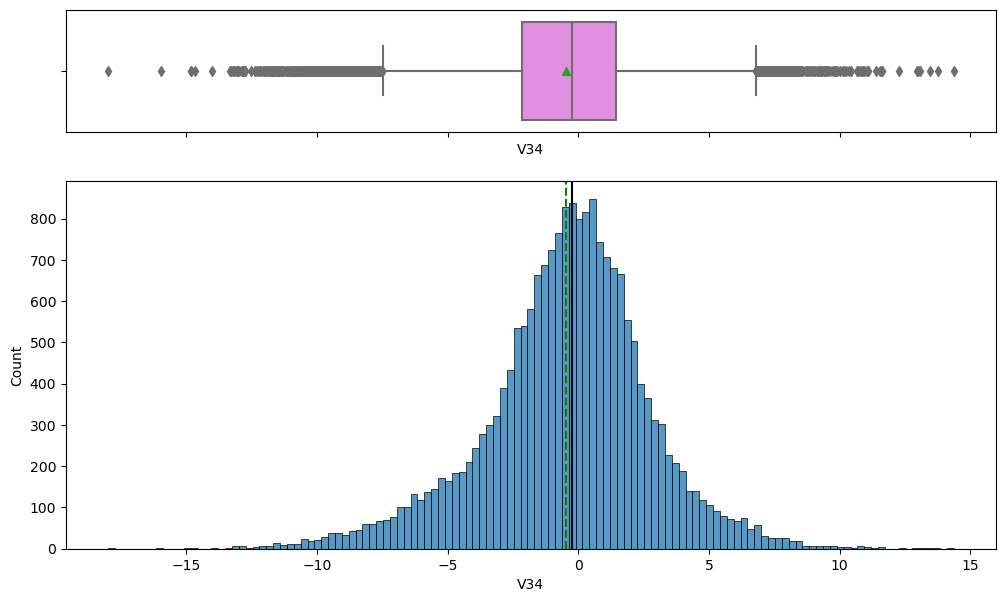

Variable:  V35 


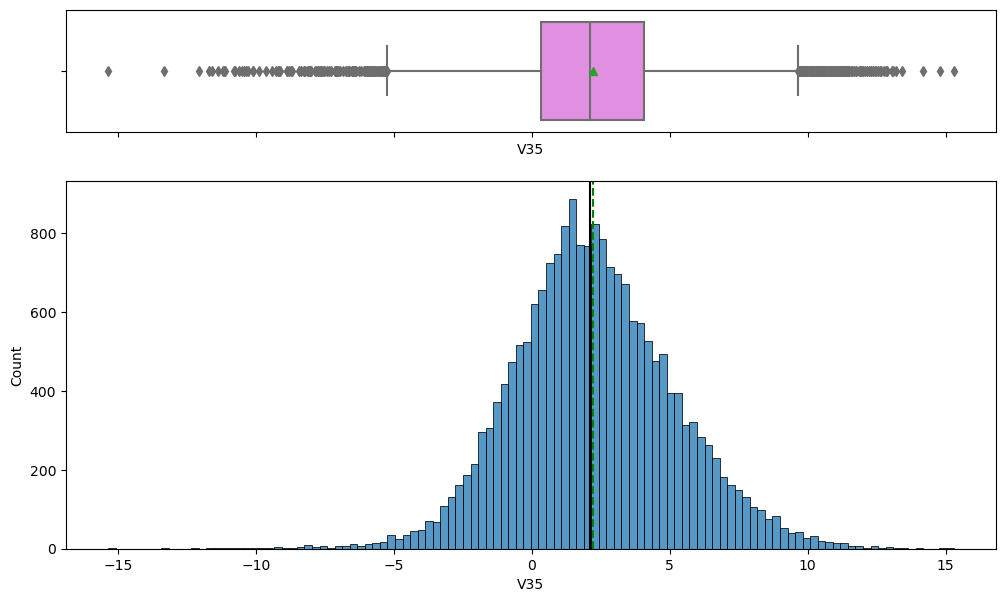

Variable:  V36 


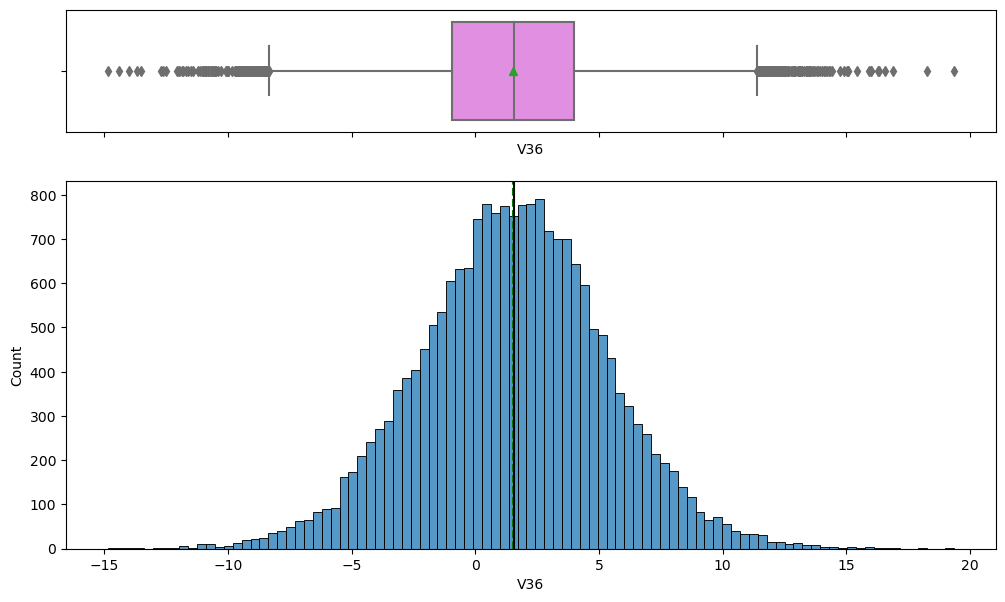

Variable:  V37 


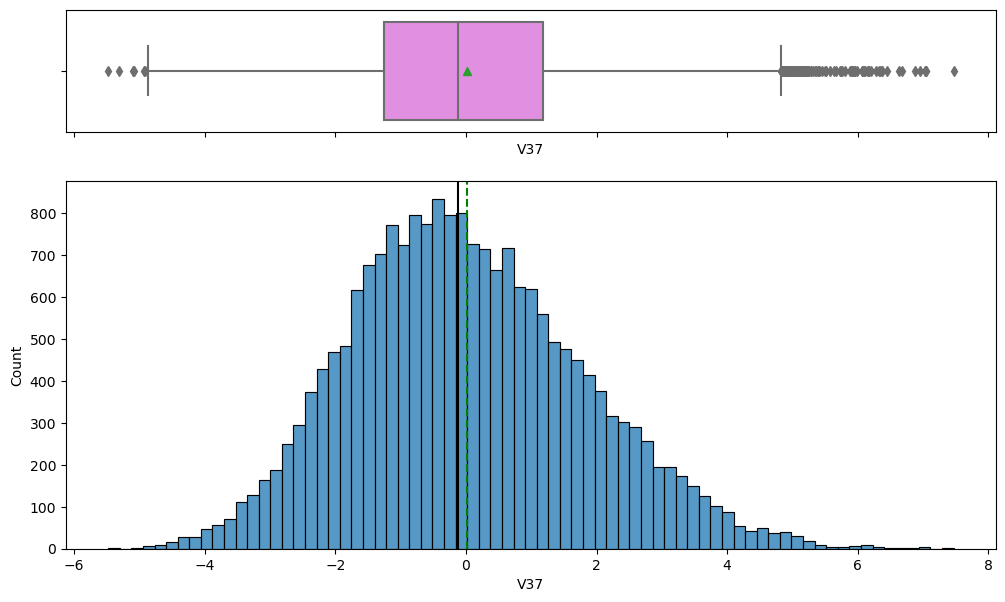

Variable:  V38 


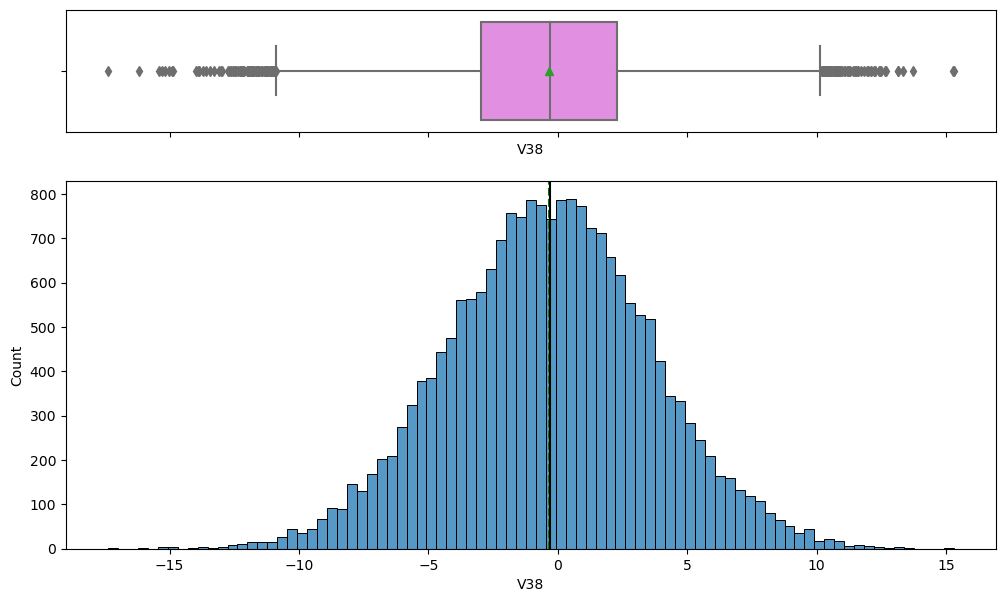

Variable:  V39 


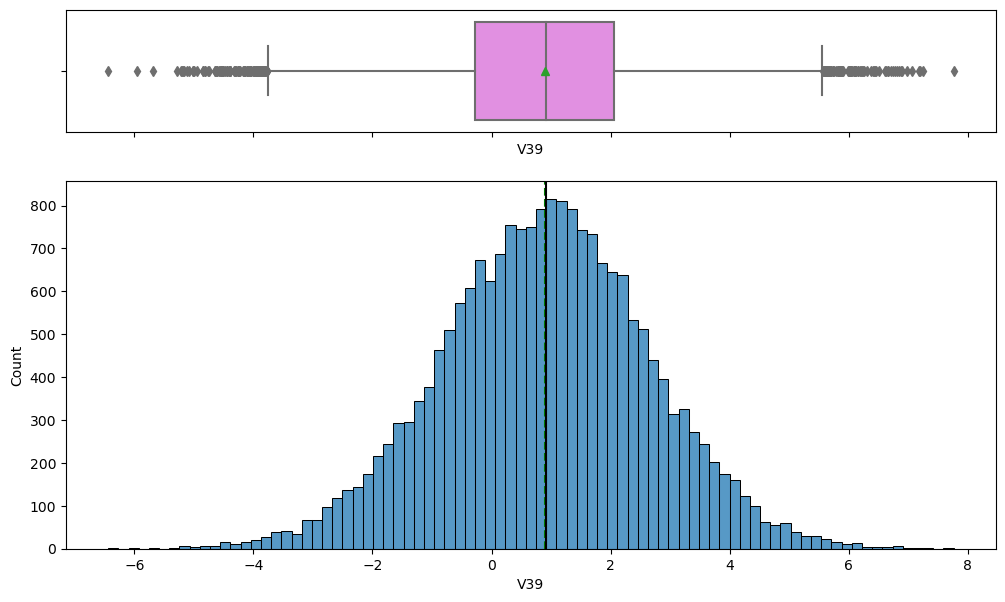

Variable:  V40 


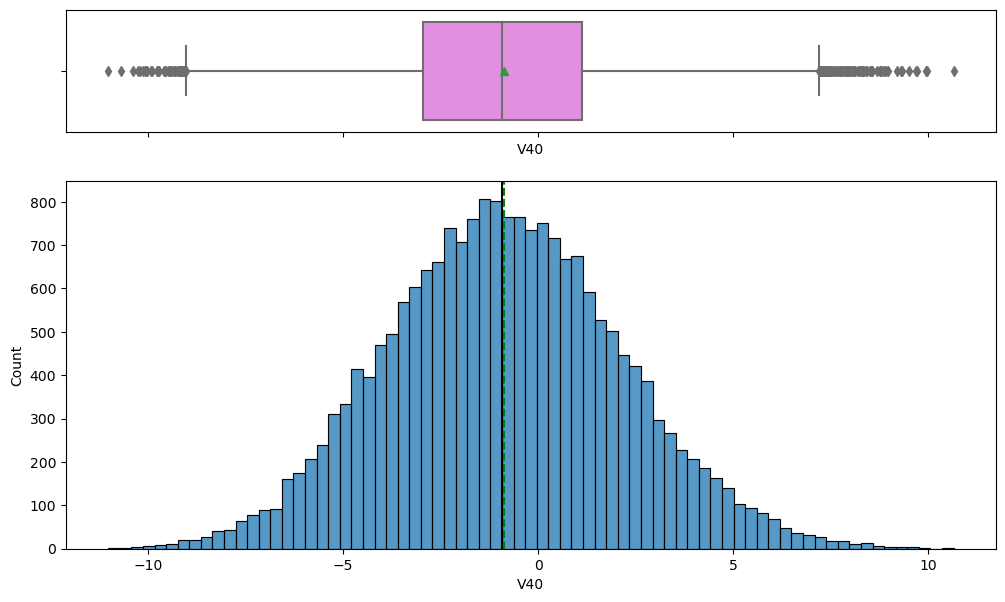

Variable:  Target 


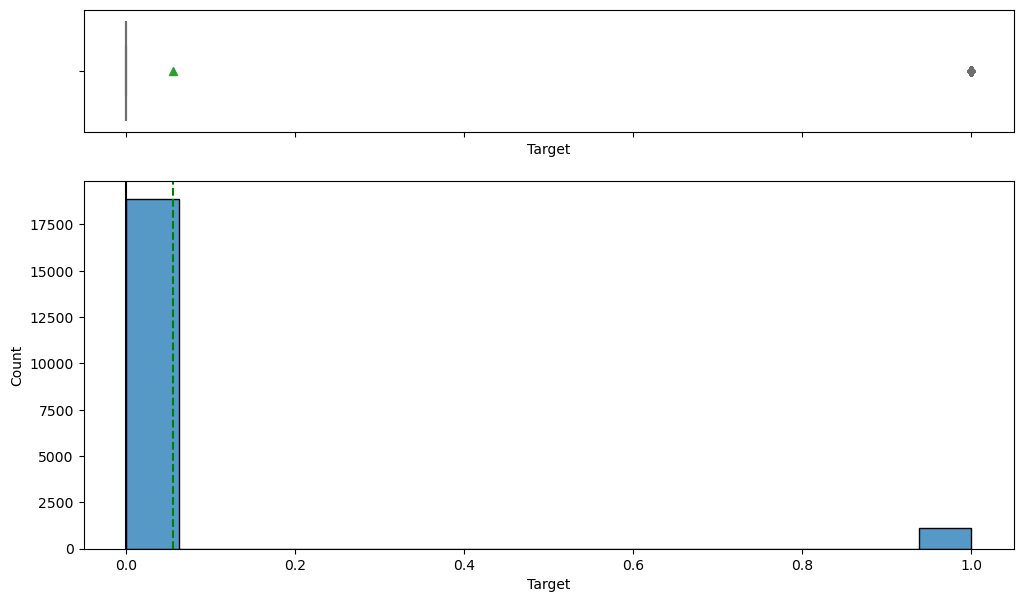

In [44]:
# run boxplot and histogram function on all features
for feature in df.columns:
    print("\033[1mVariable: ", feature, "\033[0m", flush = True)
    histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None)
    plt.show()

## Bivariate Analysis

In [314]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [315]:
# iterate through columns and perform appropriate MLS function
def iterate_and_plot_distr(data, target):
  for column in data.columns:
    if column != target and (data[column].dtype == 'int64' or df[column].dtype == 'float64'):
        print ("\033[1m",target, " vs ", column,"\033[0m")
        distribution_plot_wrt_target(data, column, target)

 Target  vs  V1 


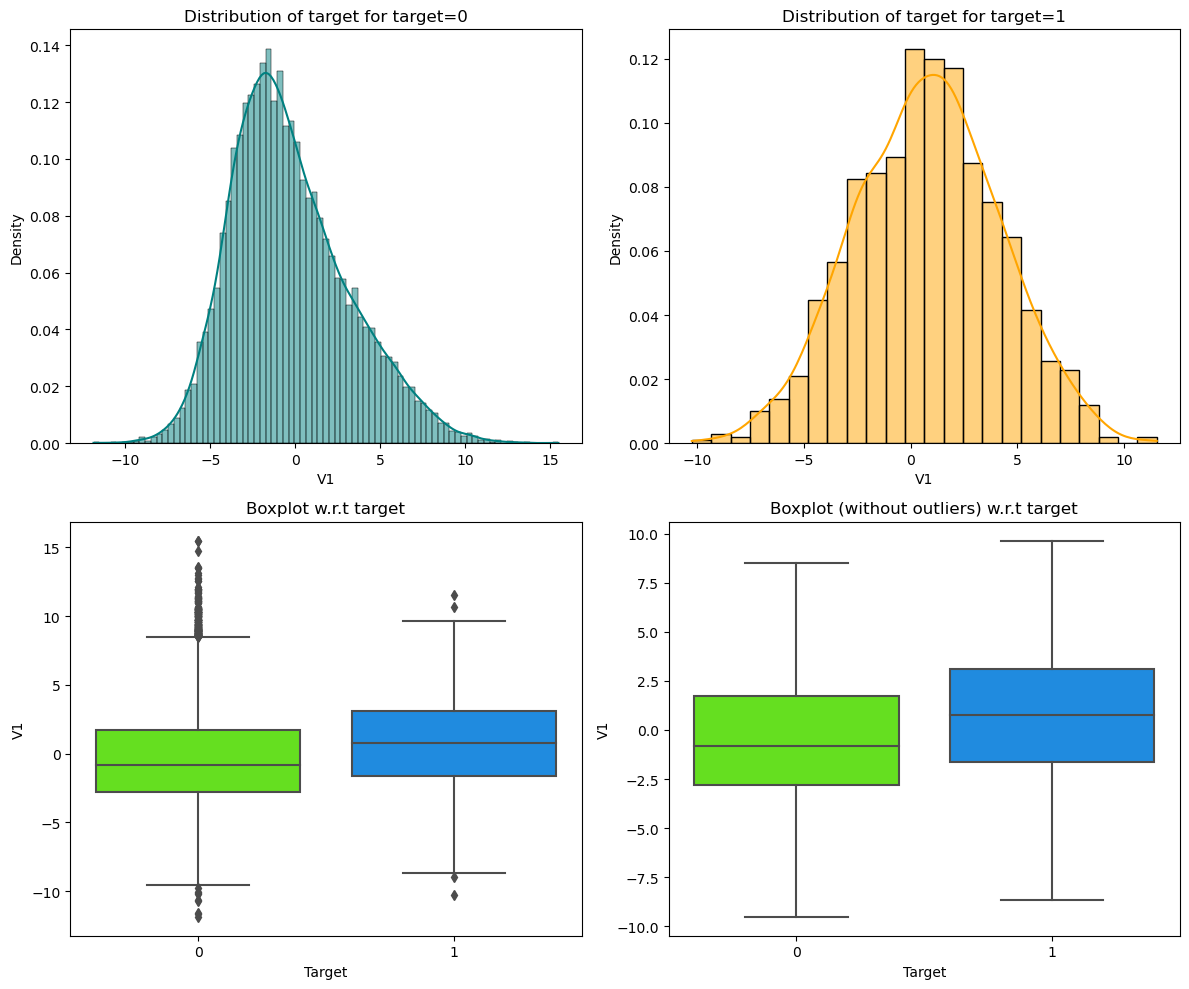

 Target  vs  V2 


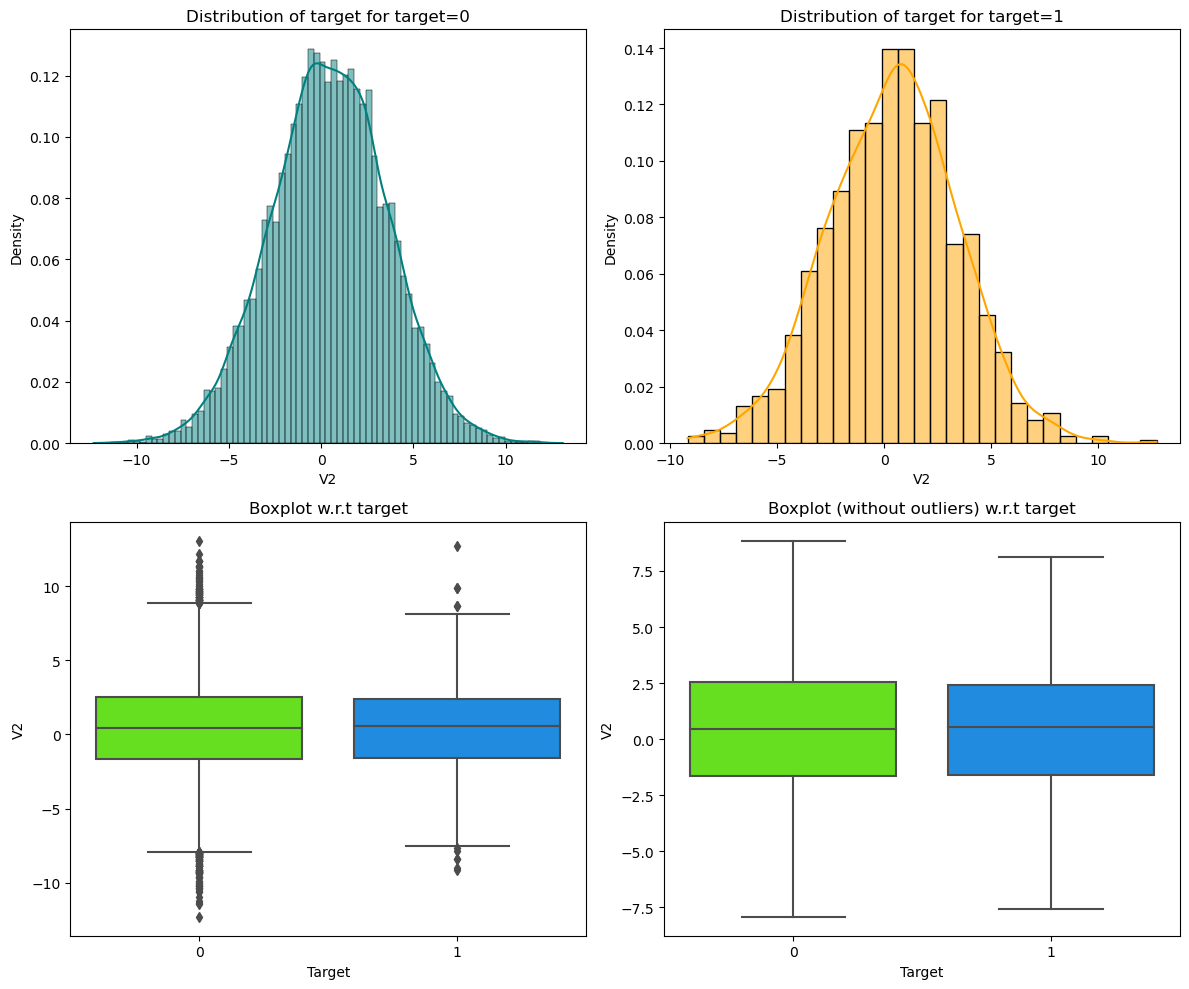

 Target  vs  V3 


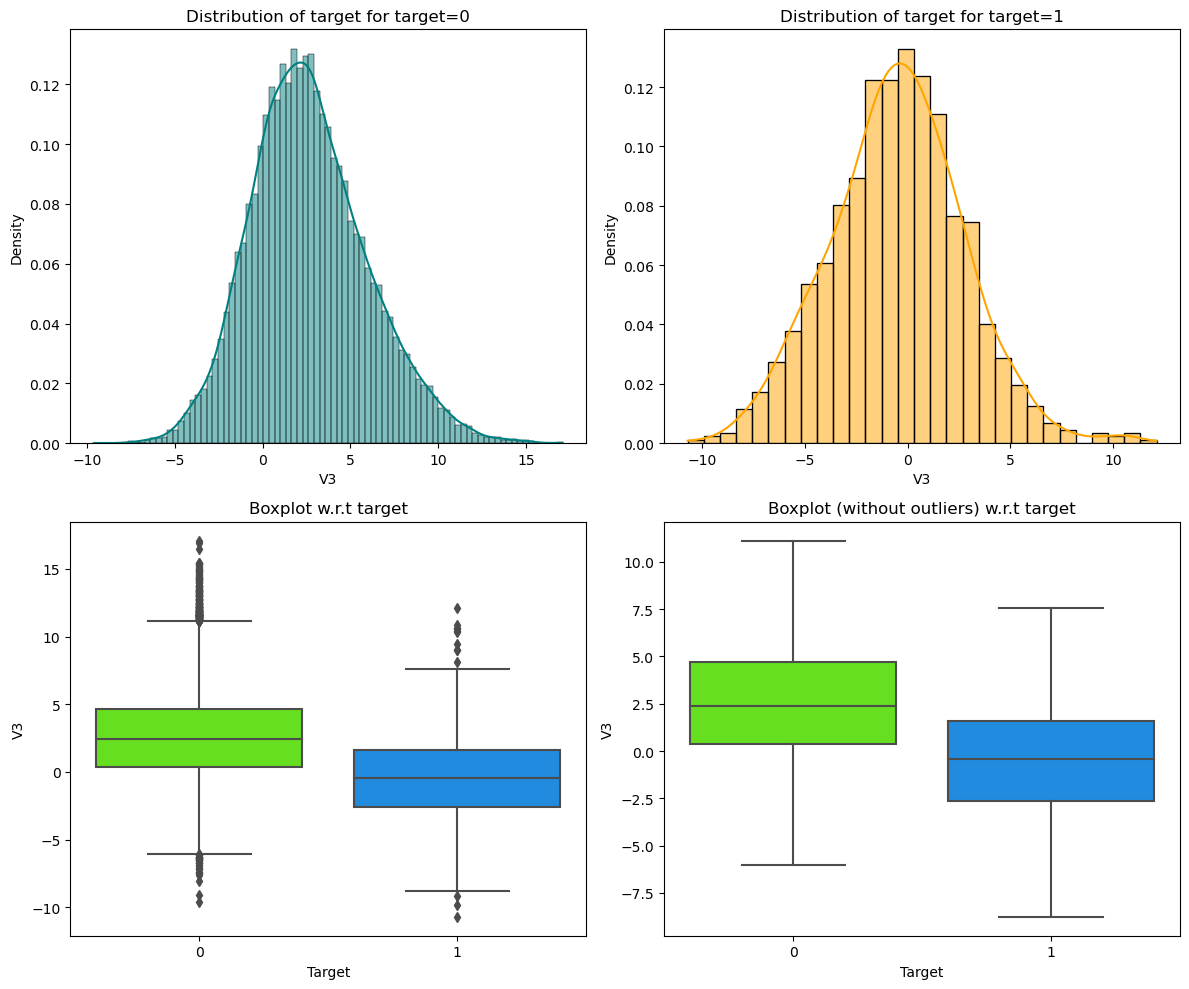

 Target  vs  V4 


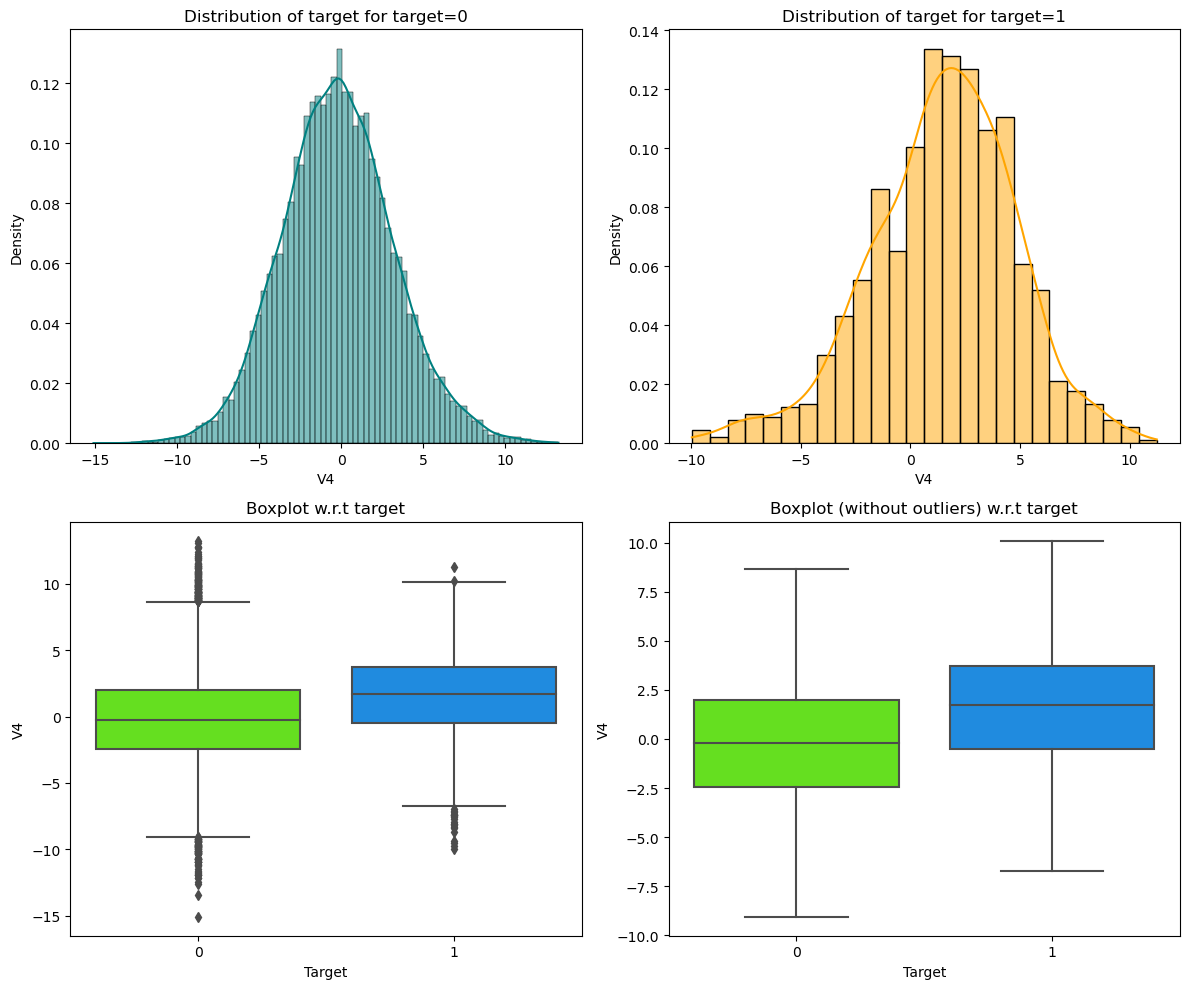

 Target  vs  V5 


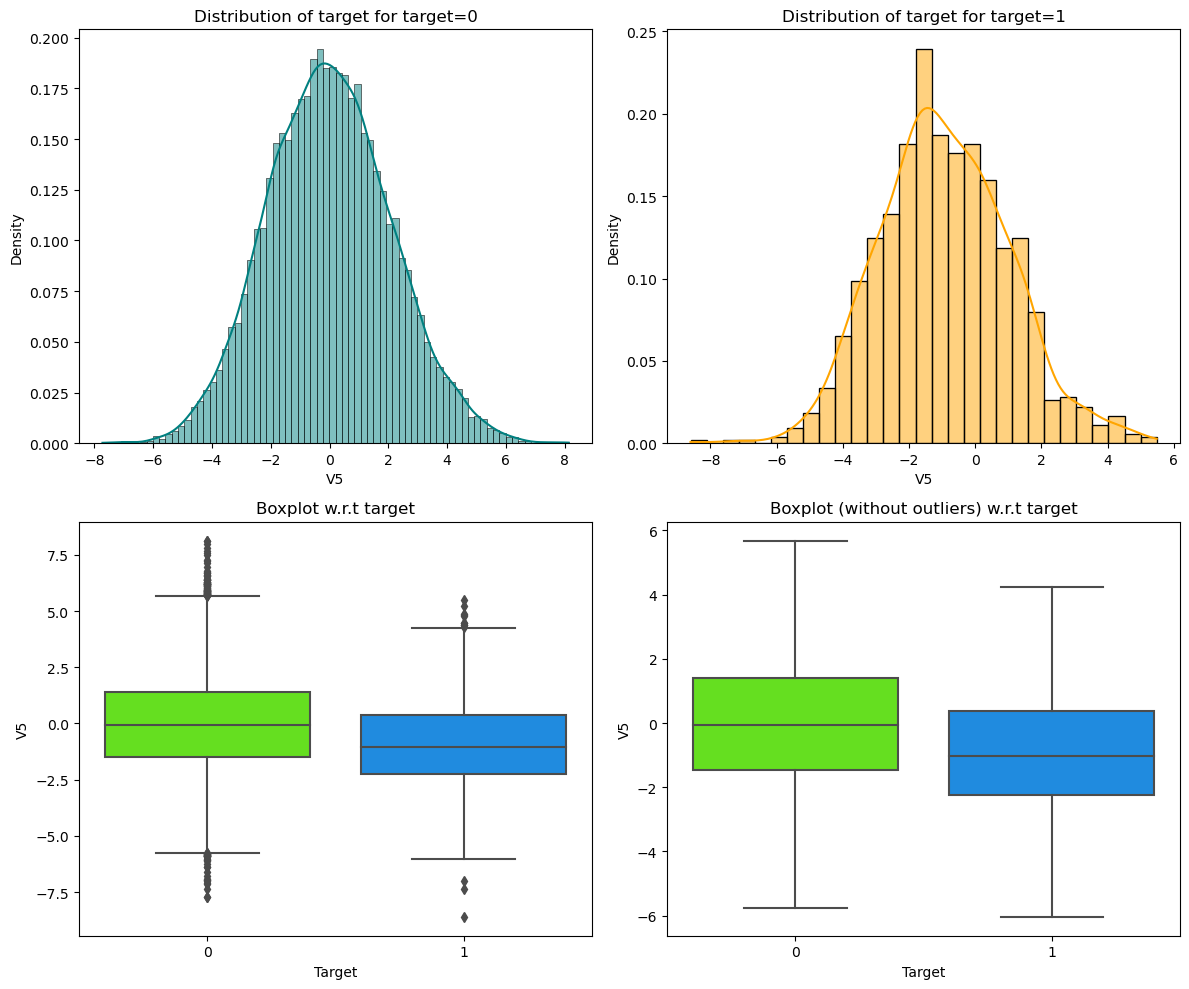

 Target  vs  V6 


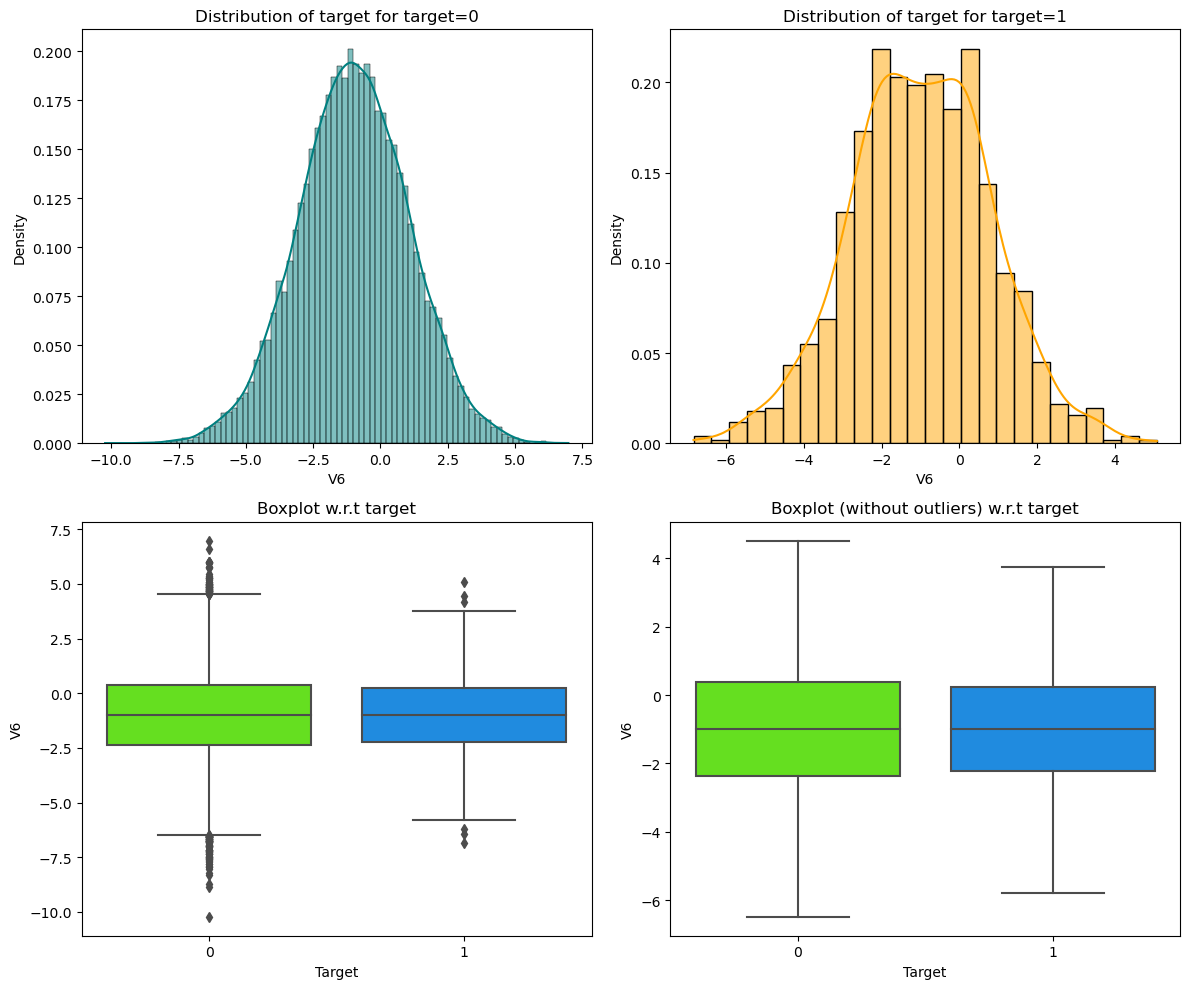

 Target  vs  V7 


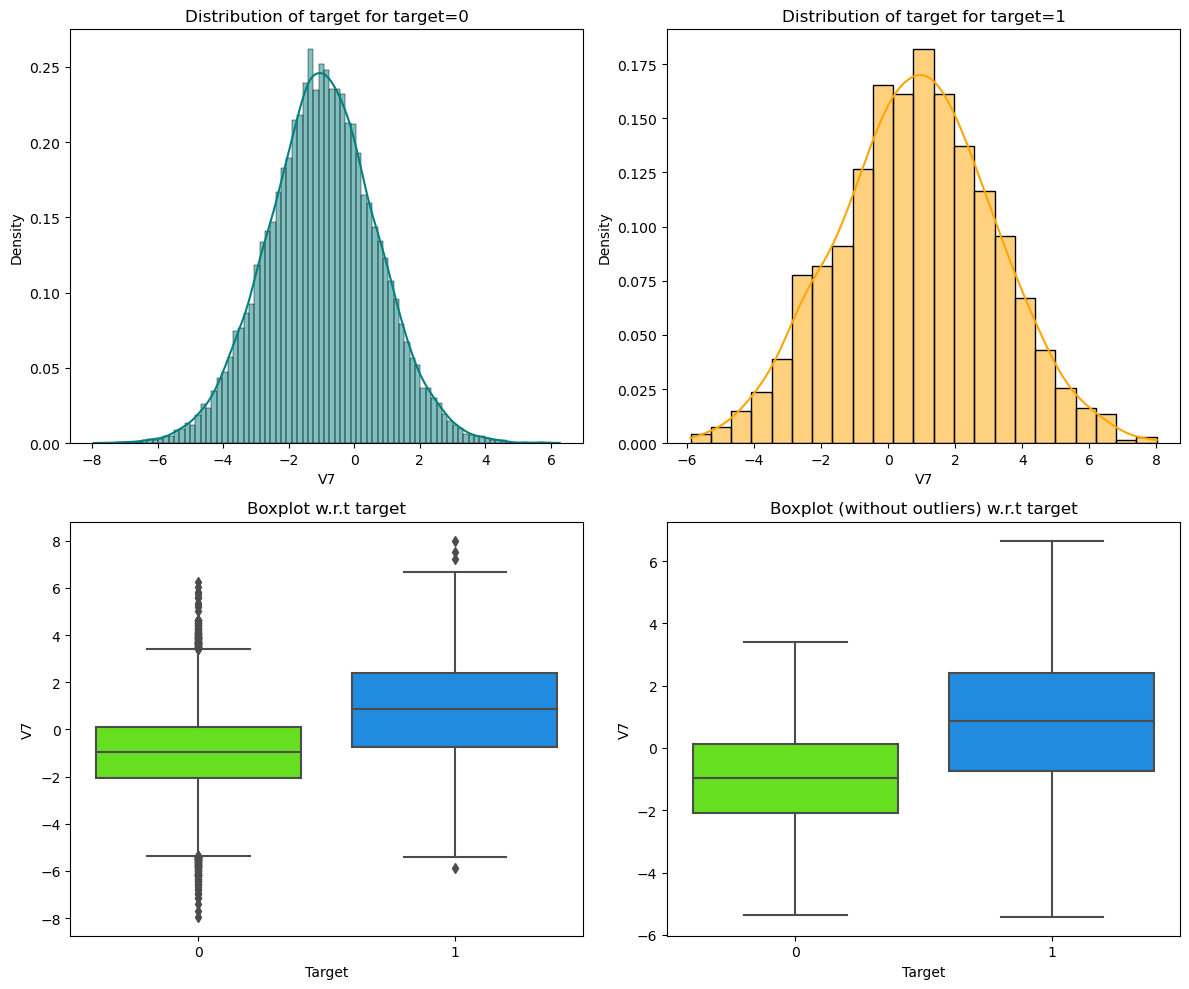

 Target  vs  V8 


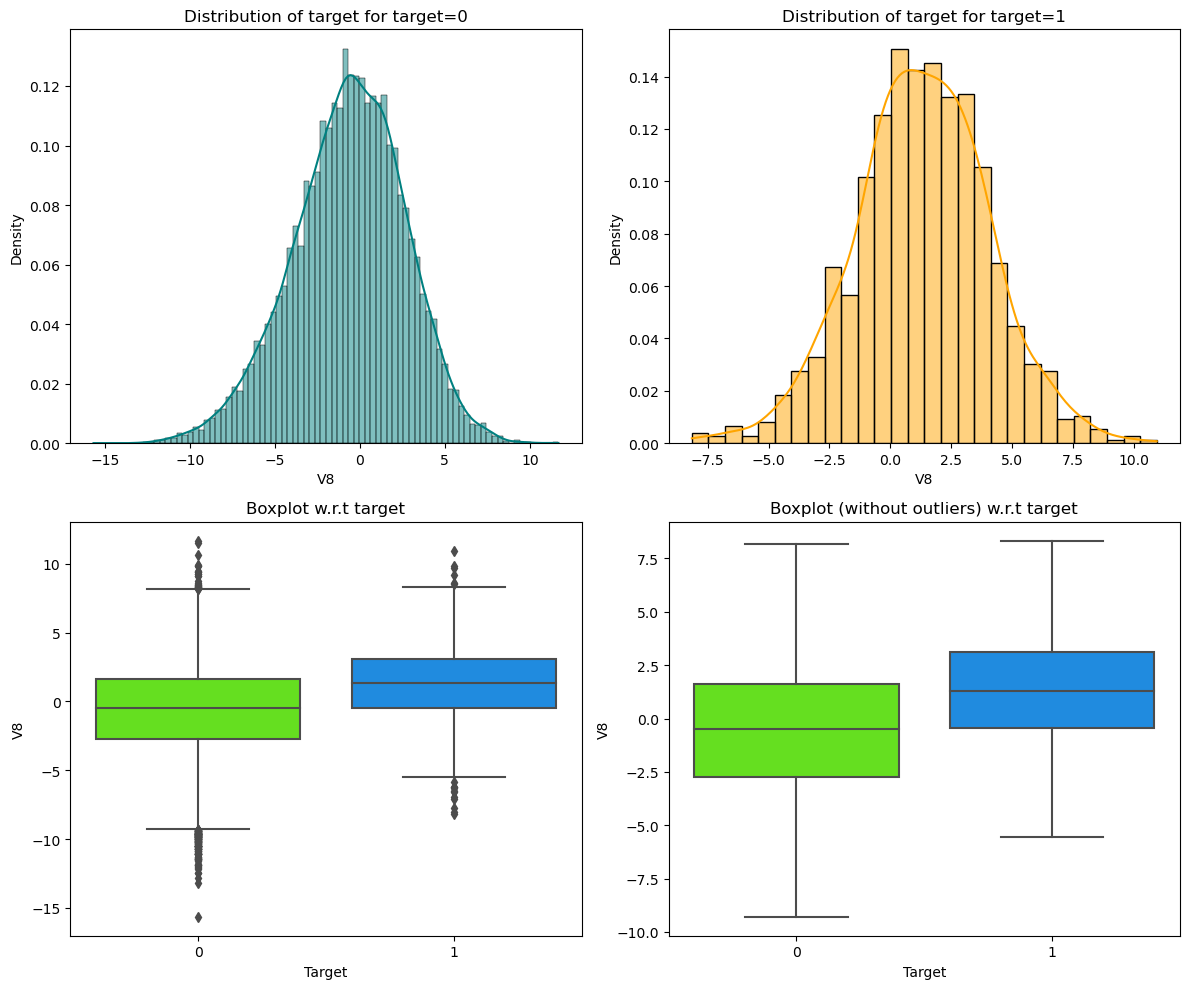

 Target  vs  V9 


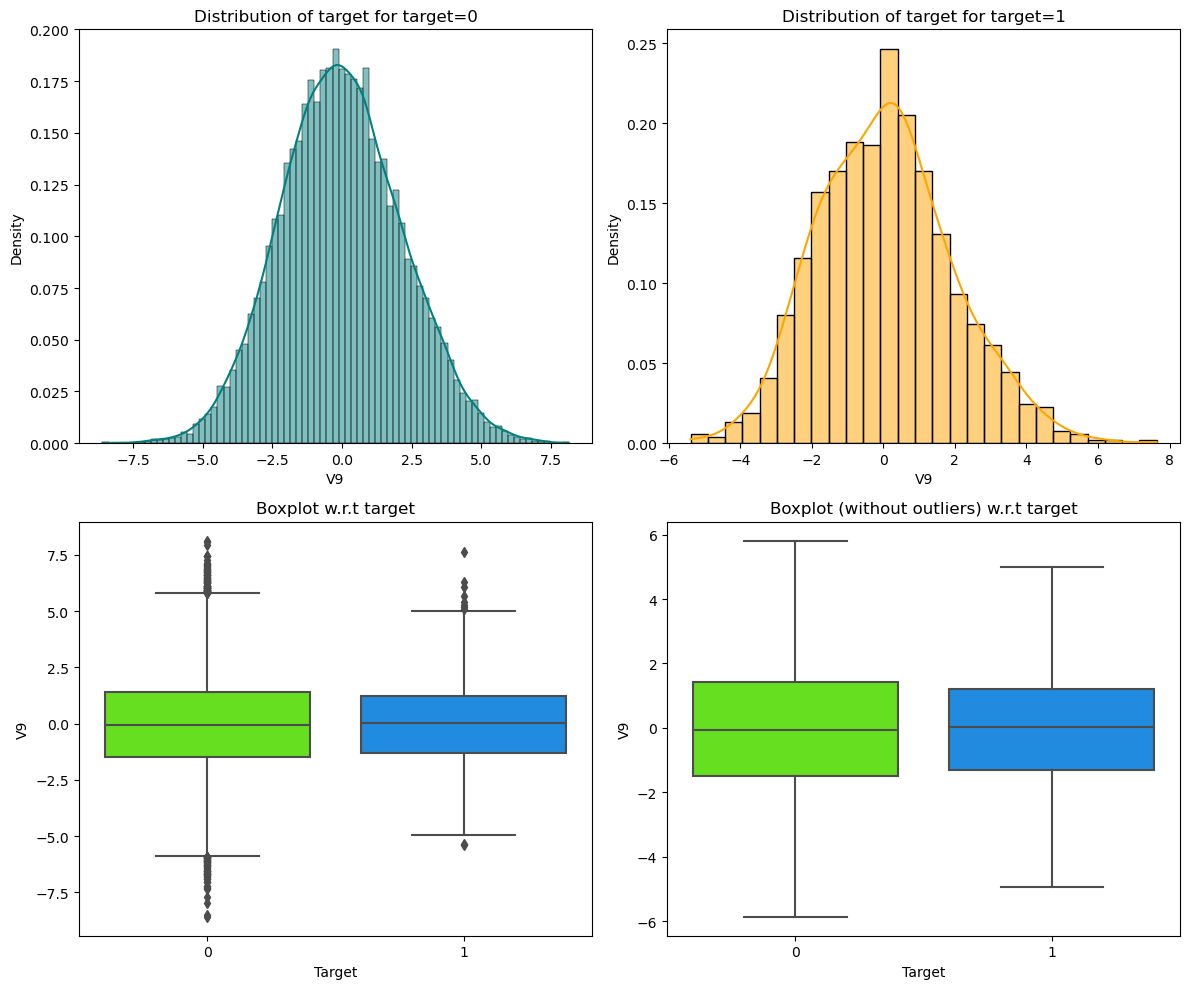

 Target  vs  V10 


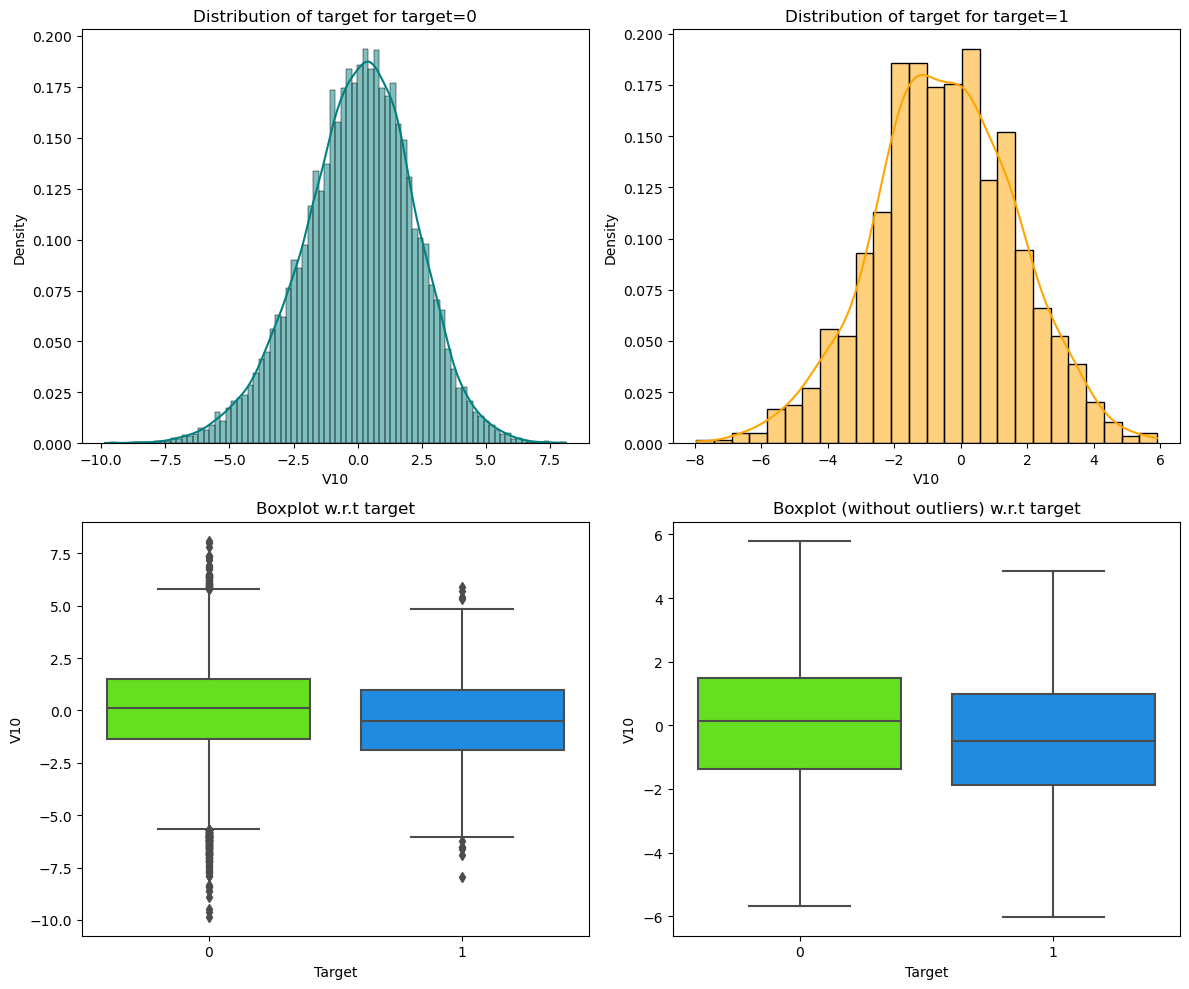

 Target  vs  V11 


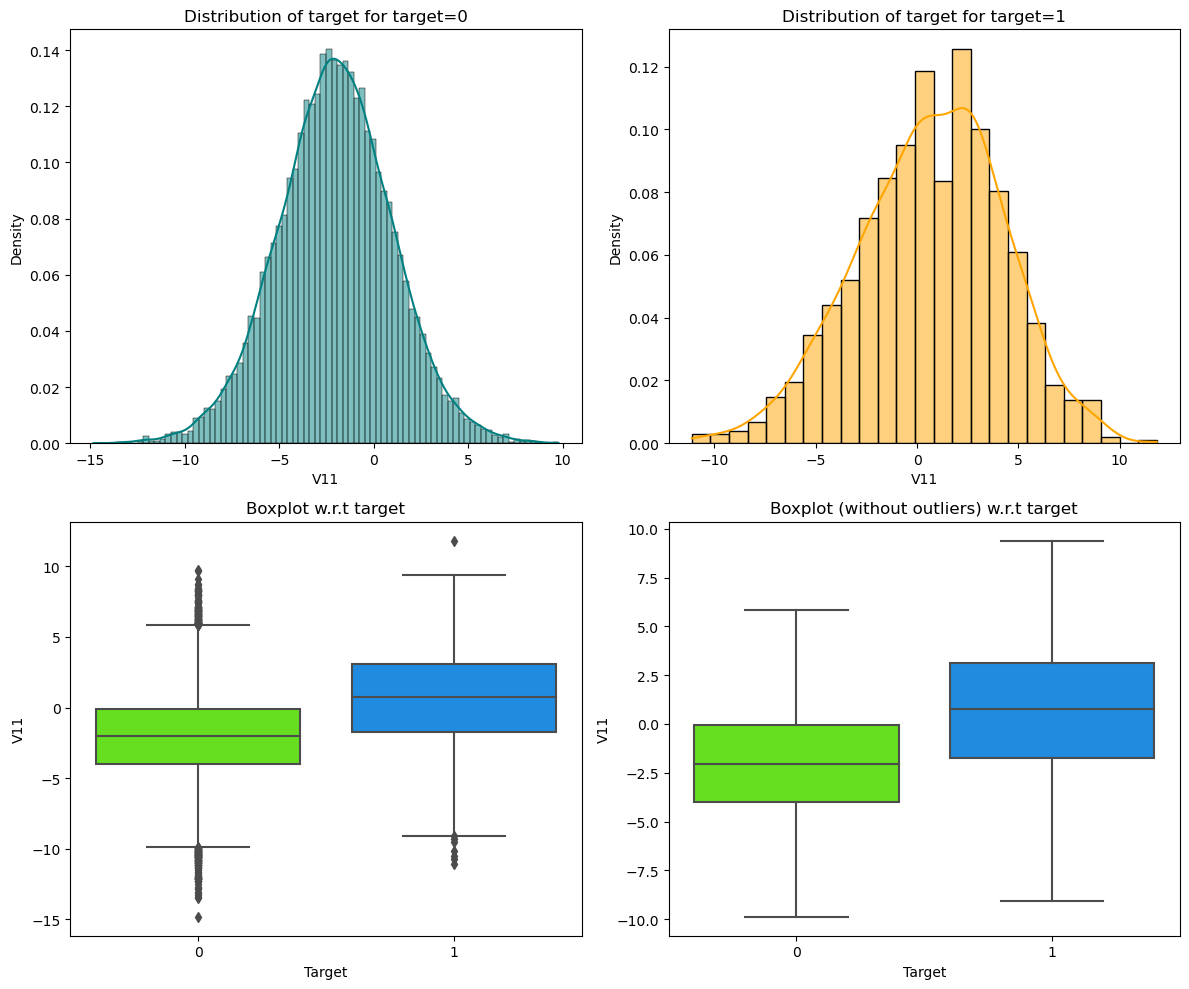

 Target  vs  V12 


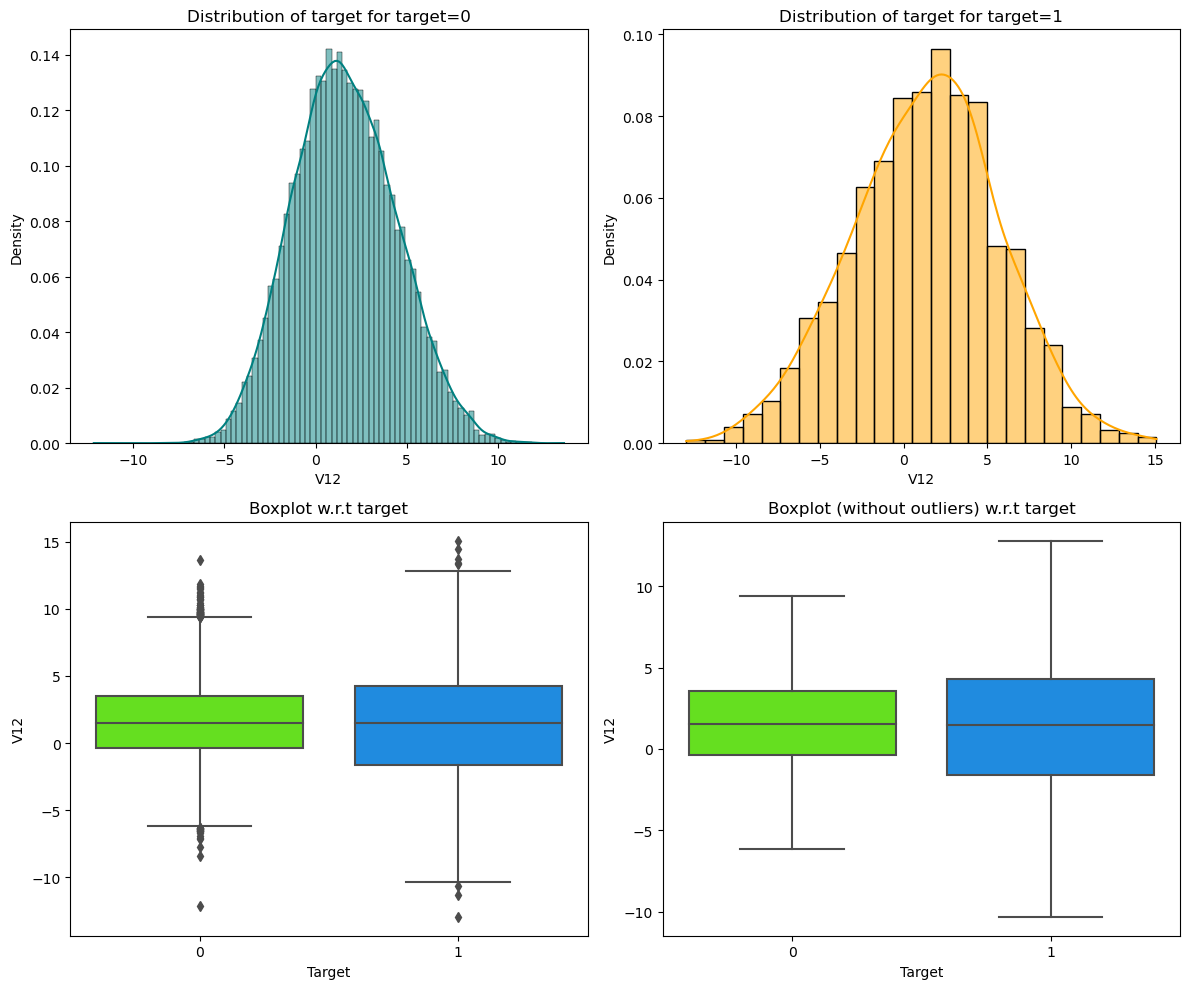

 Target  vs  V13 


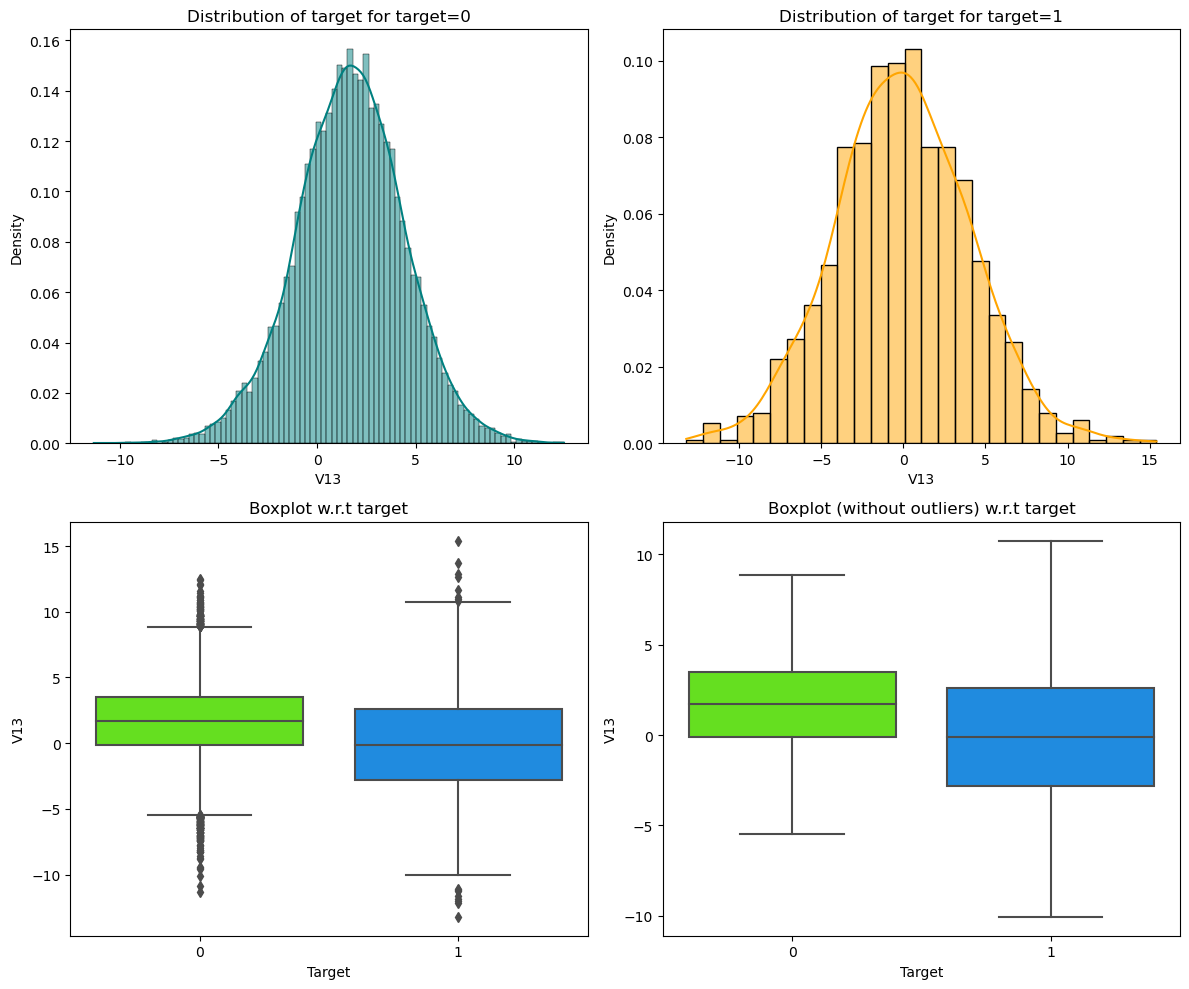

 Target  vs  V14 


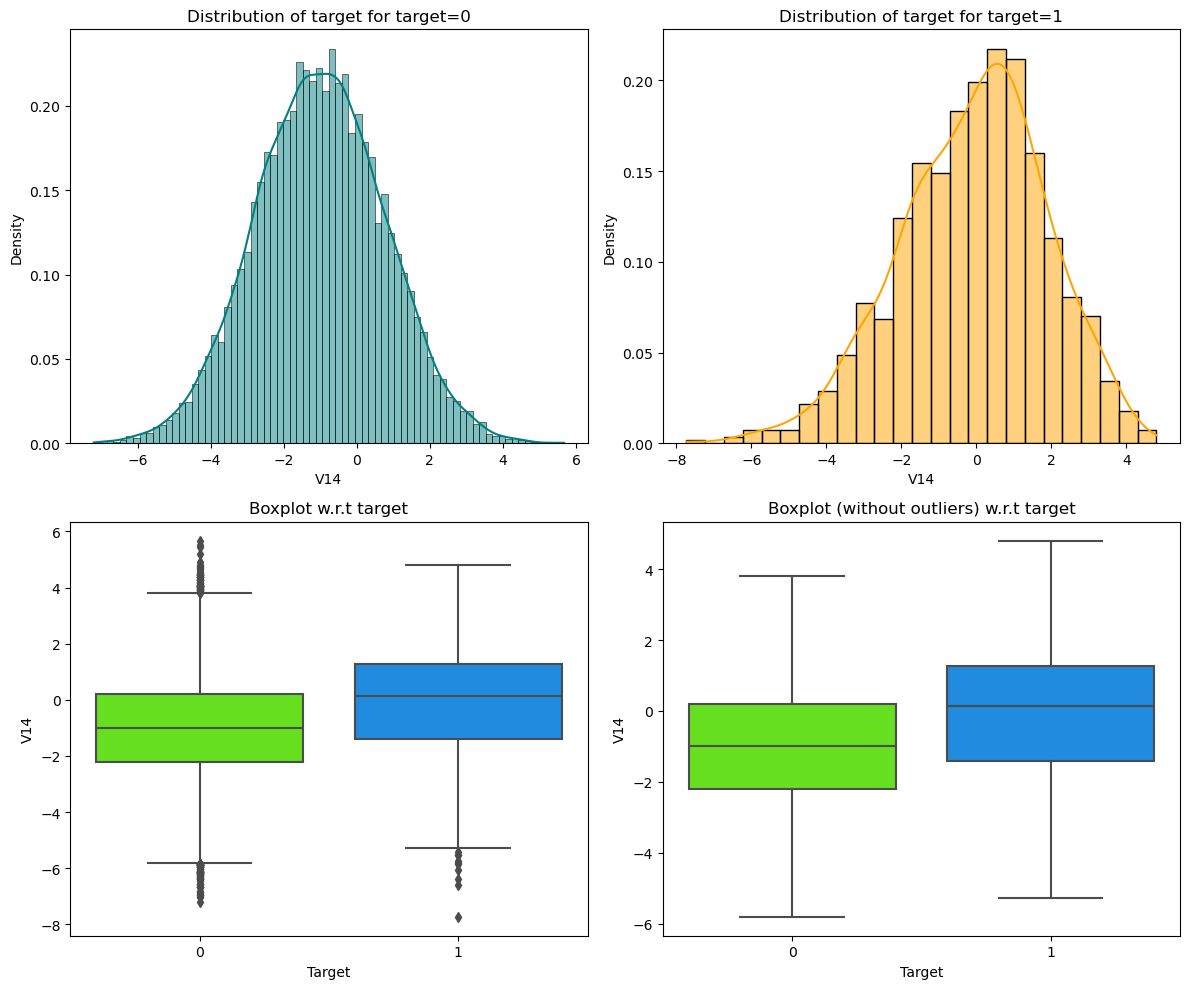

 Target  vs  V15 


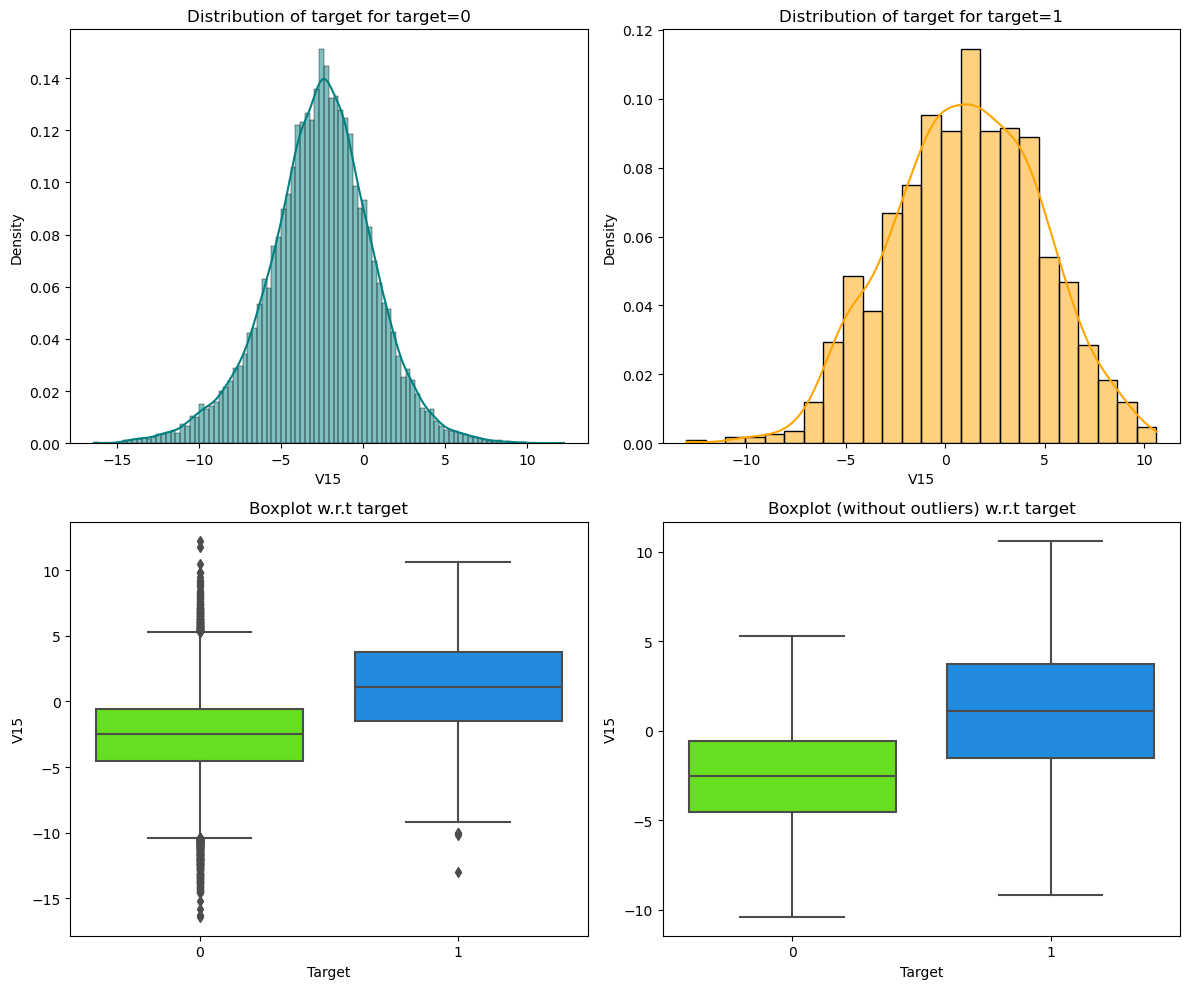

 Target  vs  V16 


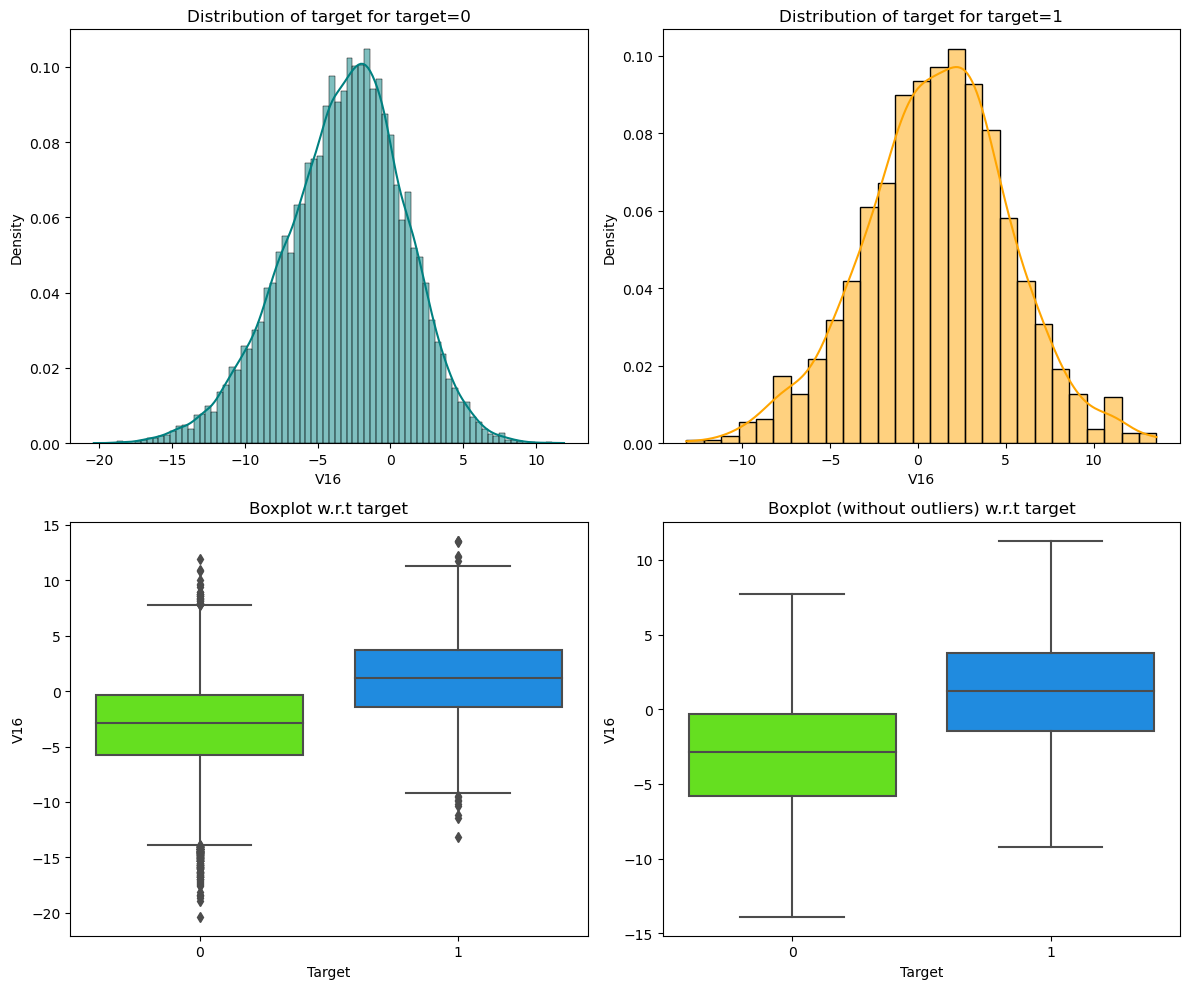

 Target  vs  V17 


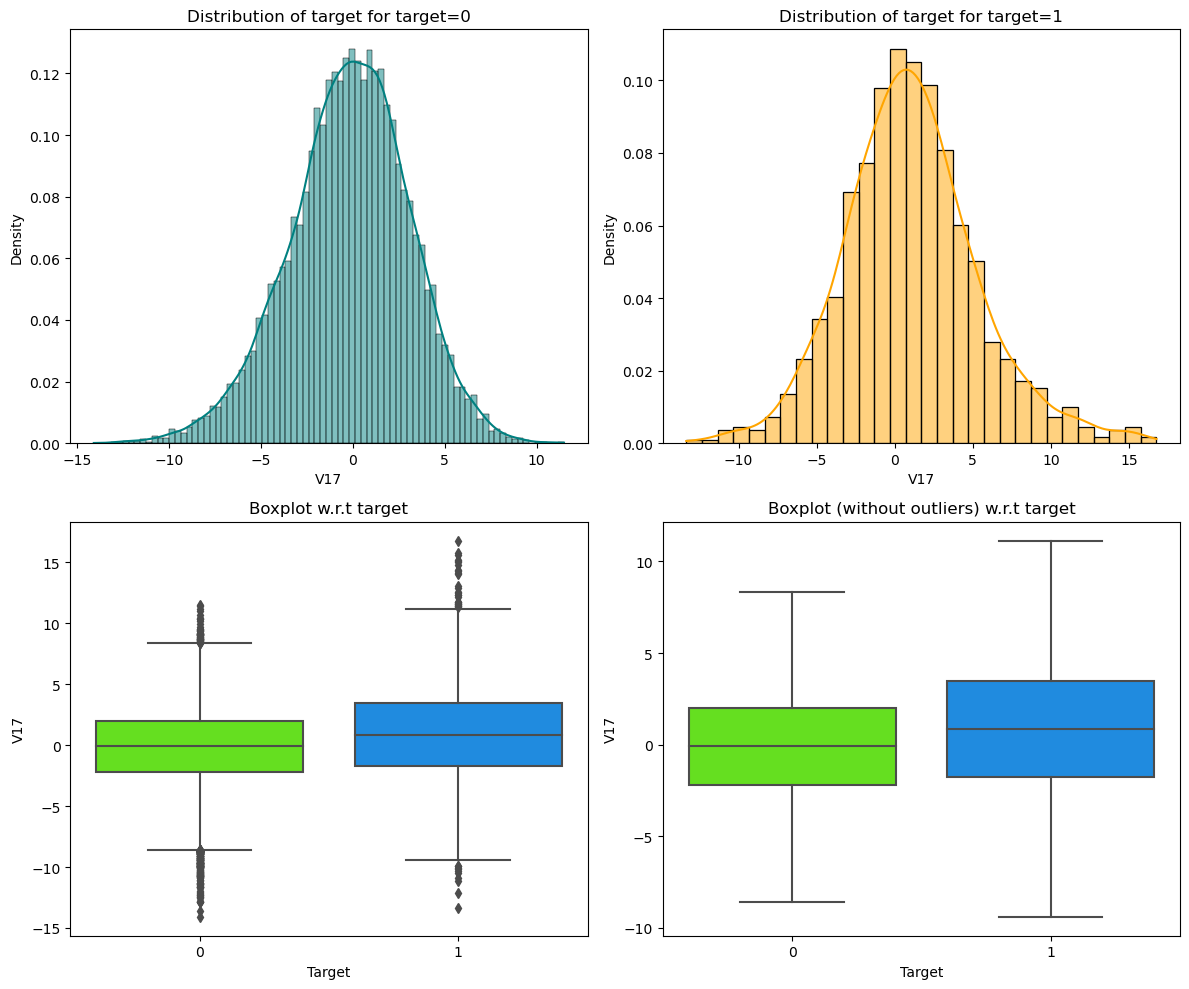

 Target  vs  V18 


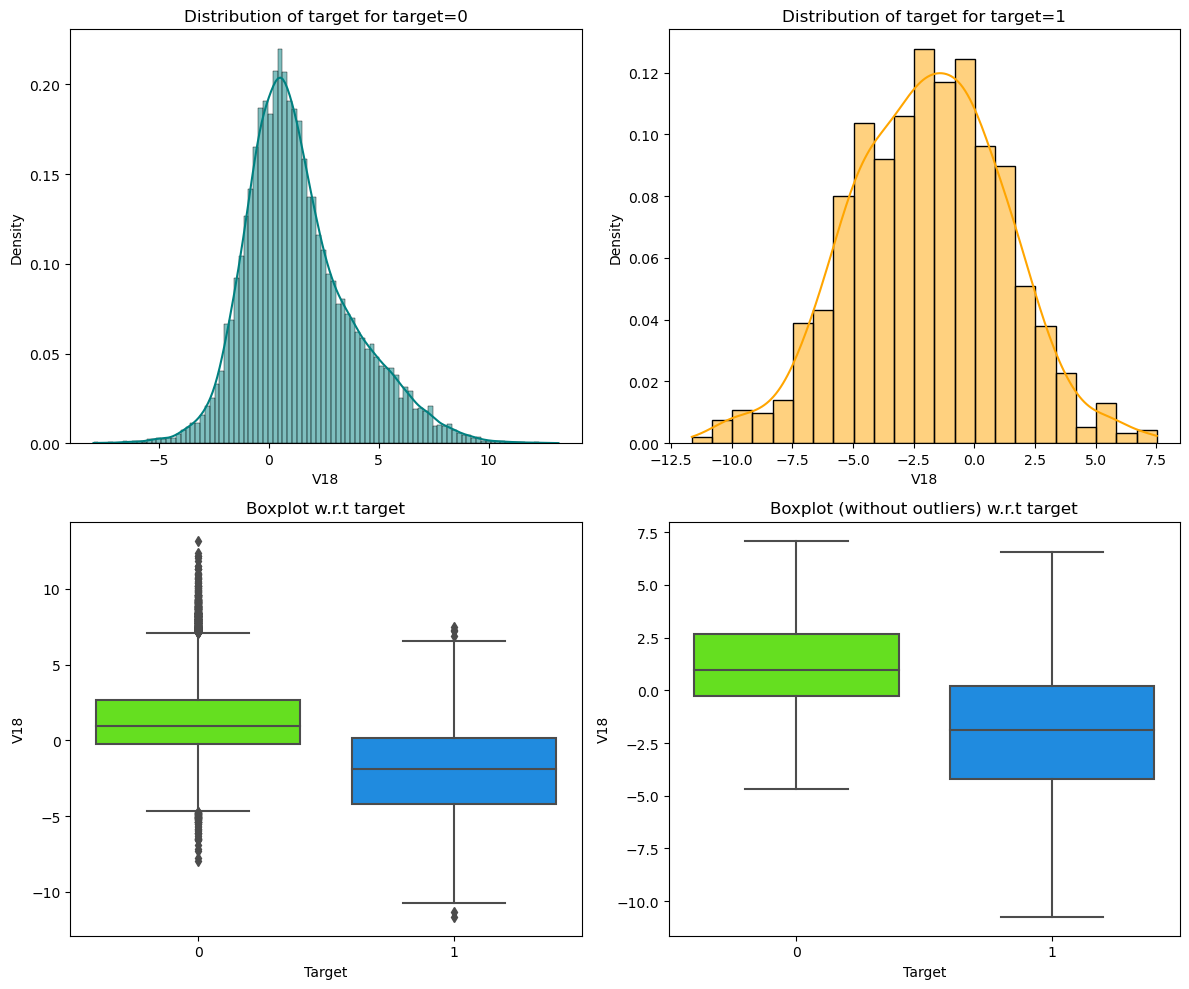

 Target  vs  V19 


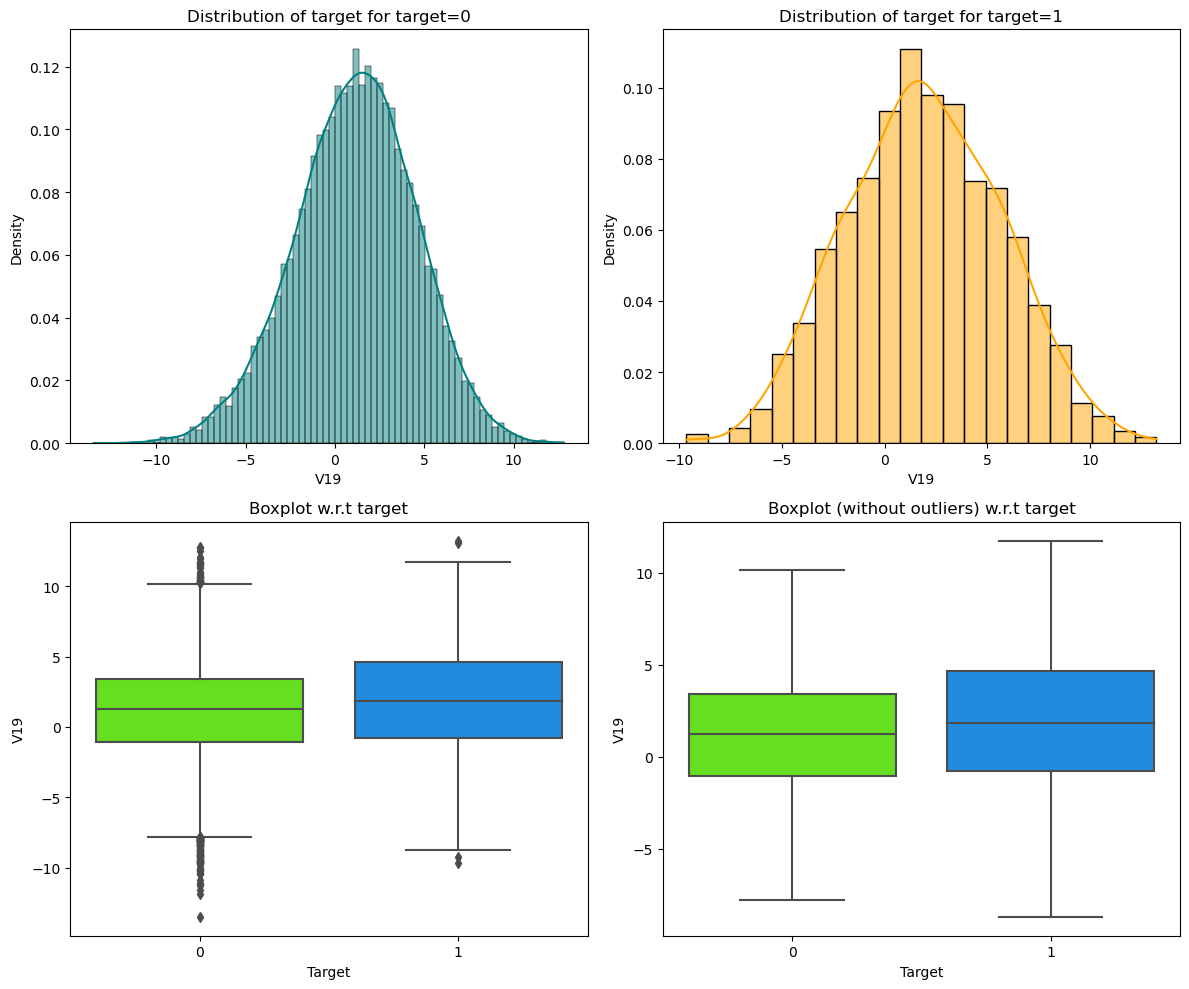

 Target  vs  V20 


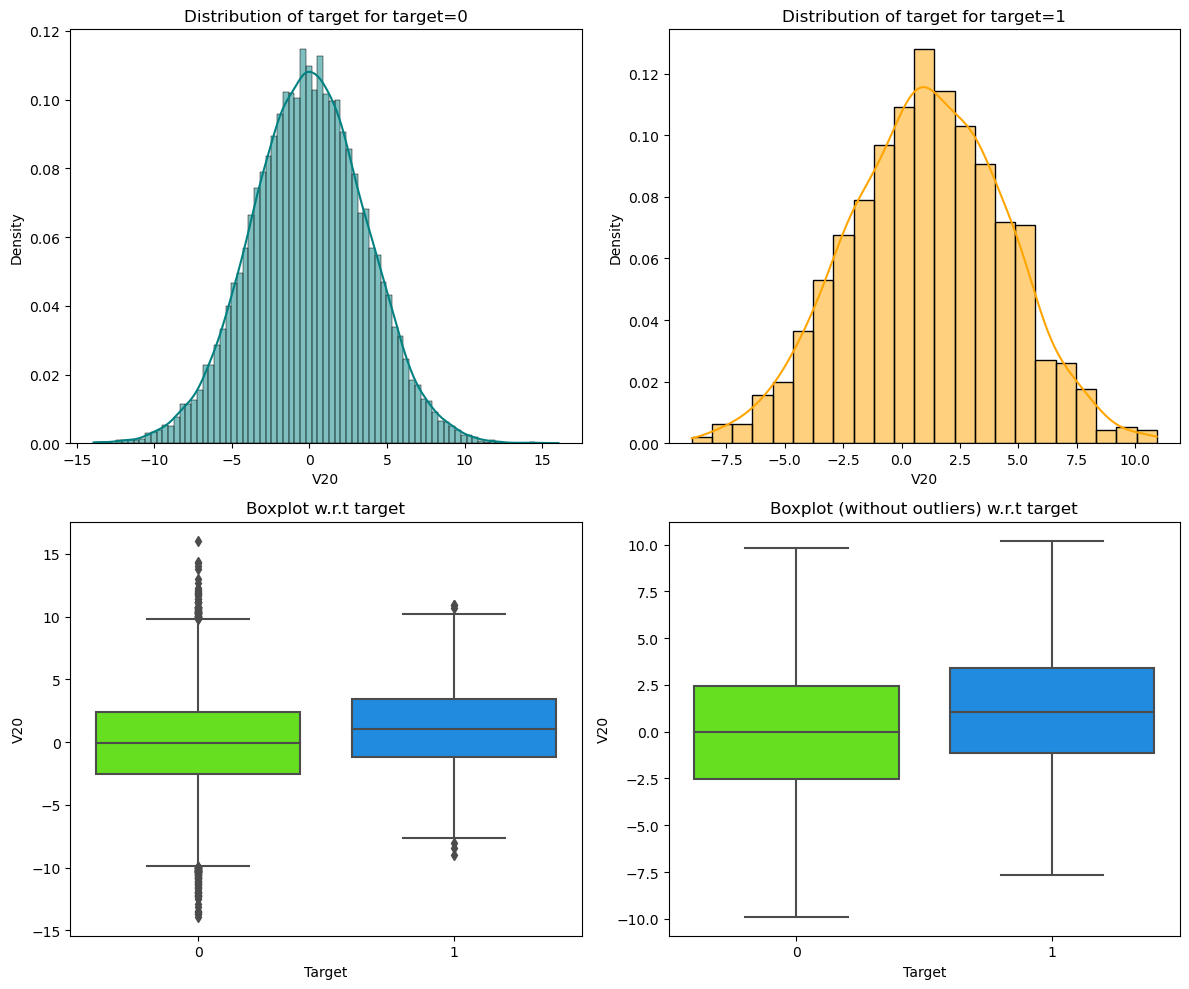

 Target  vs  V21 


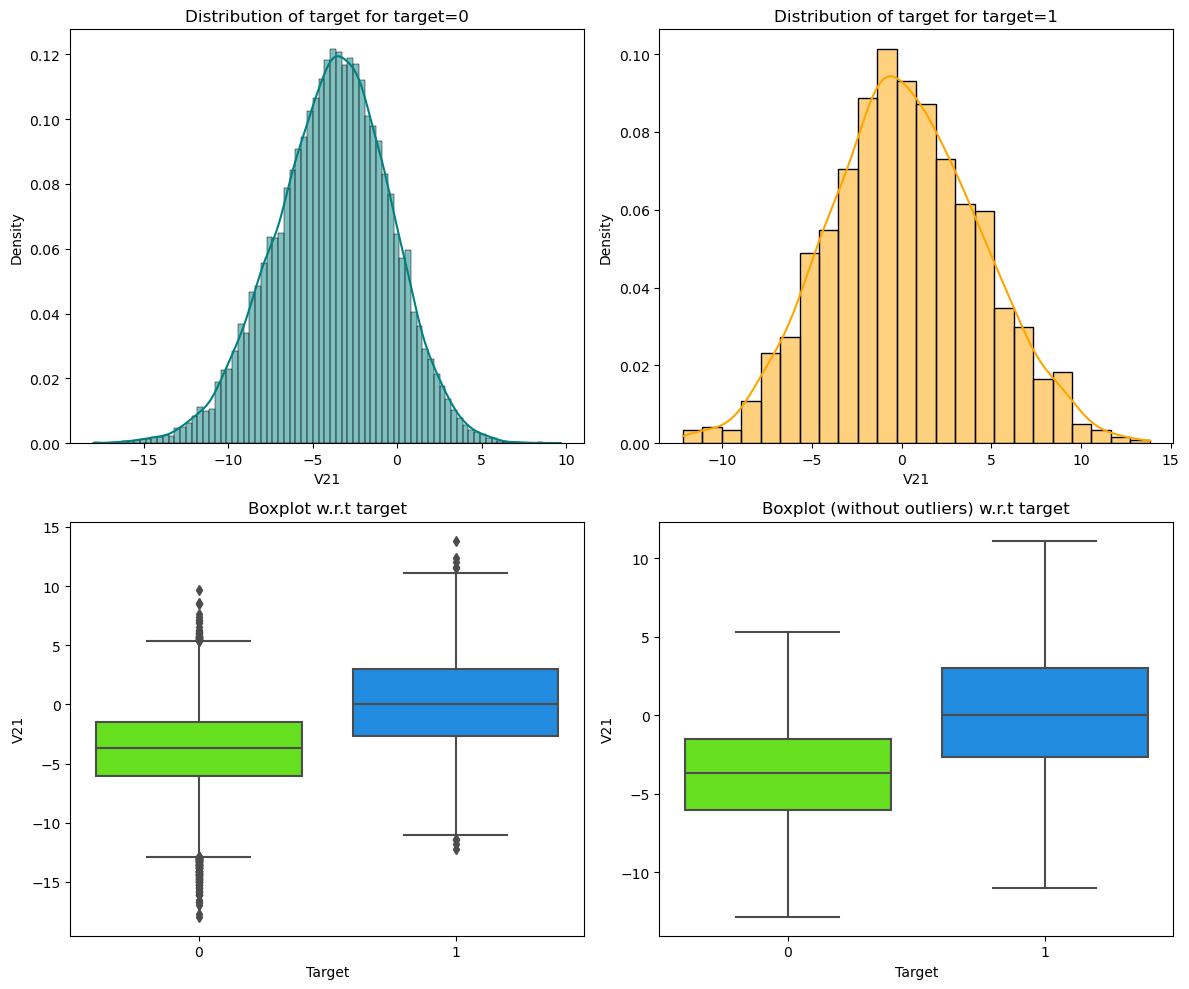

 Target  vs  V22 


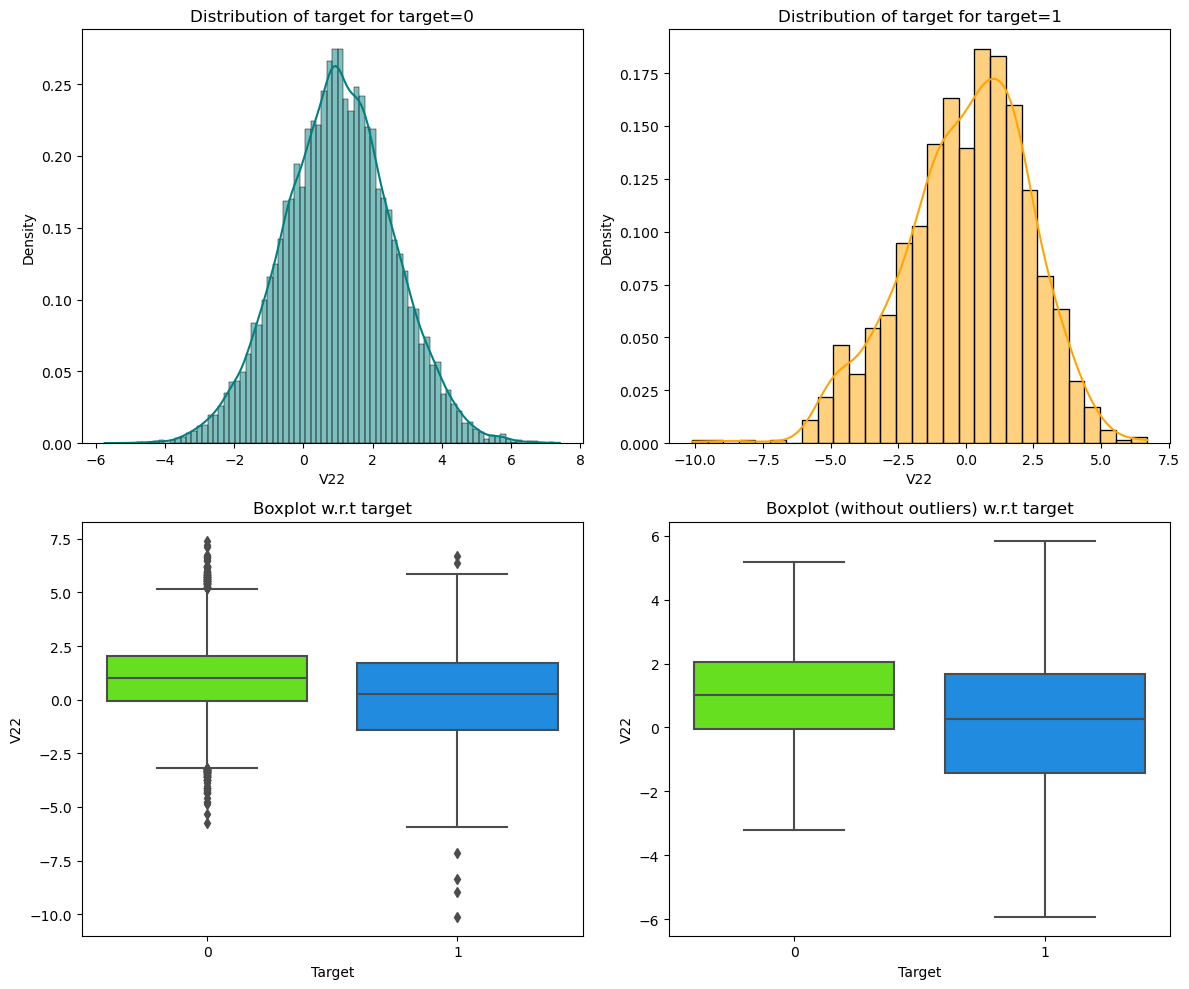

 Target  vs  V23 


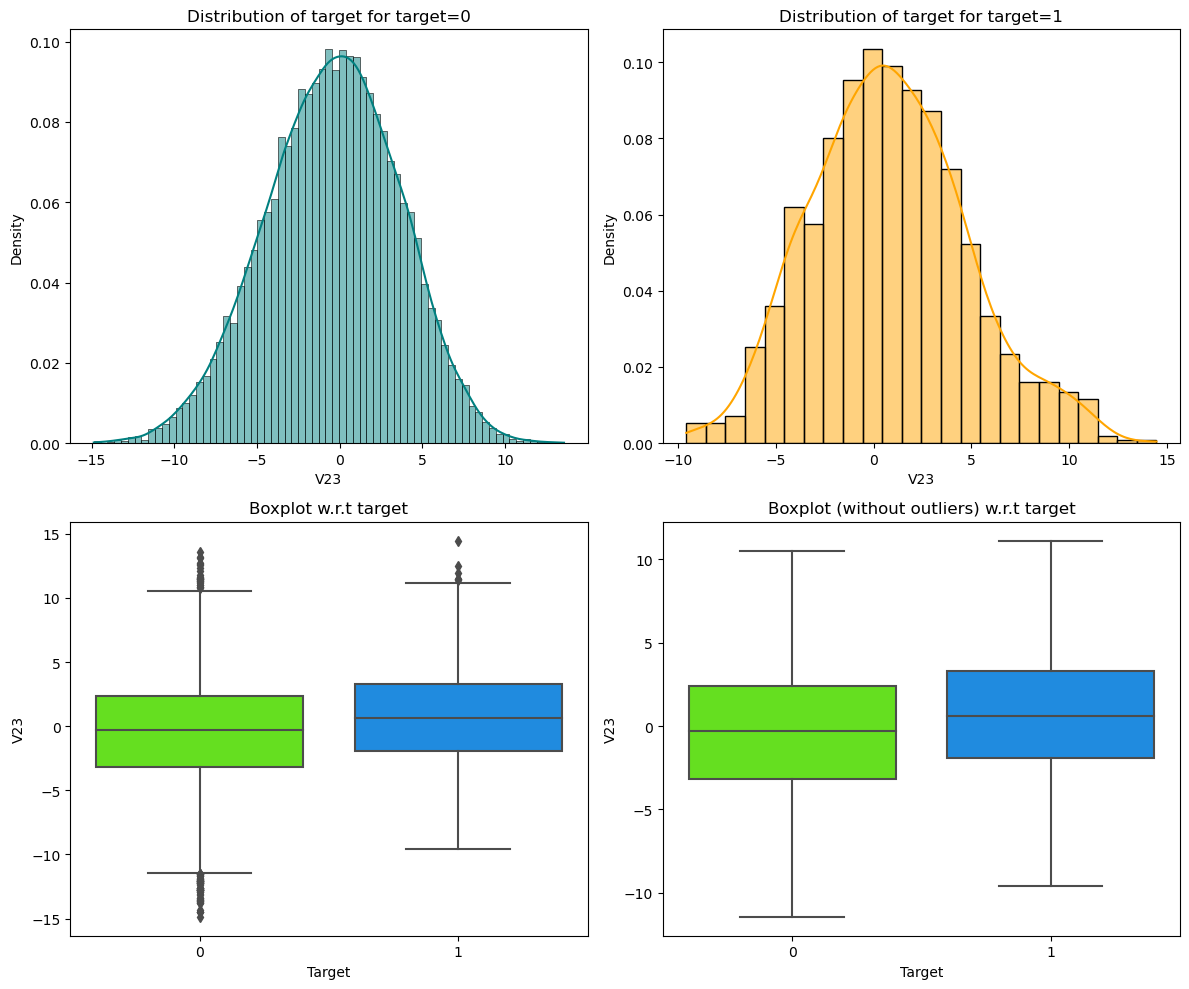

 Target  vs  V24 


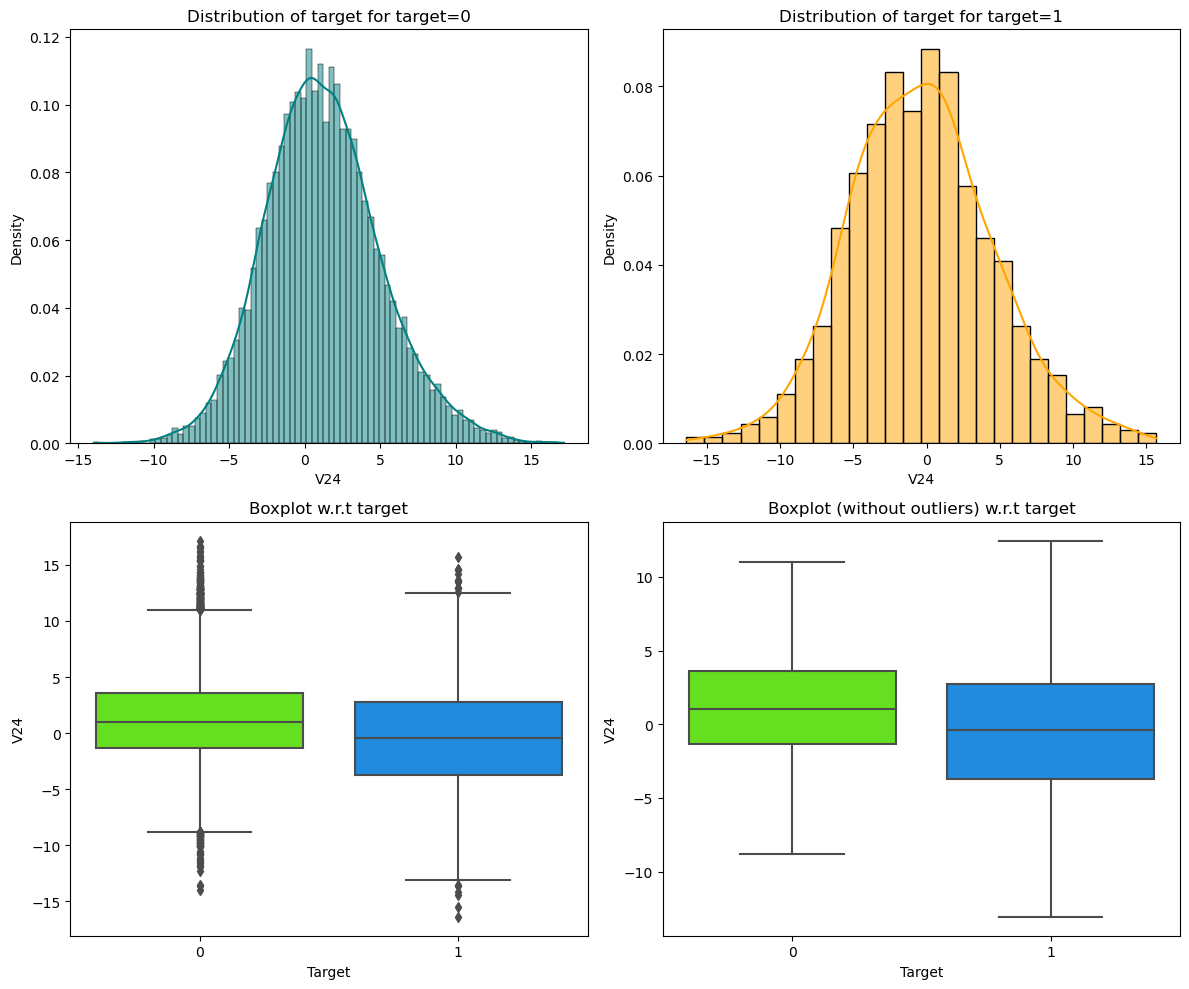

 Target  vs  V25 


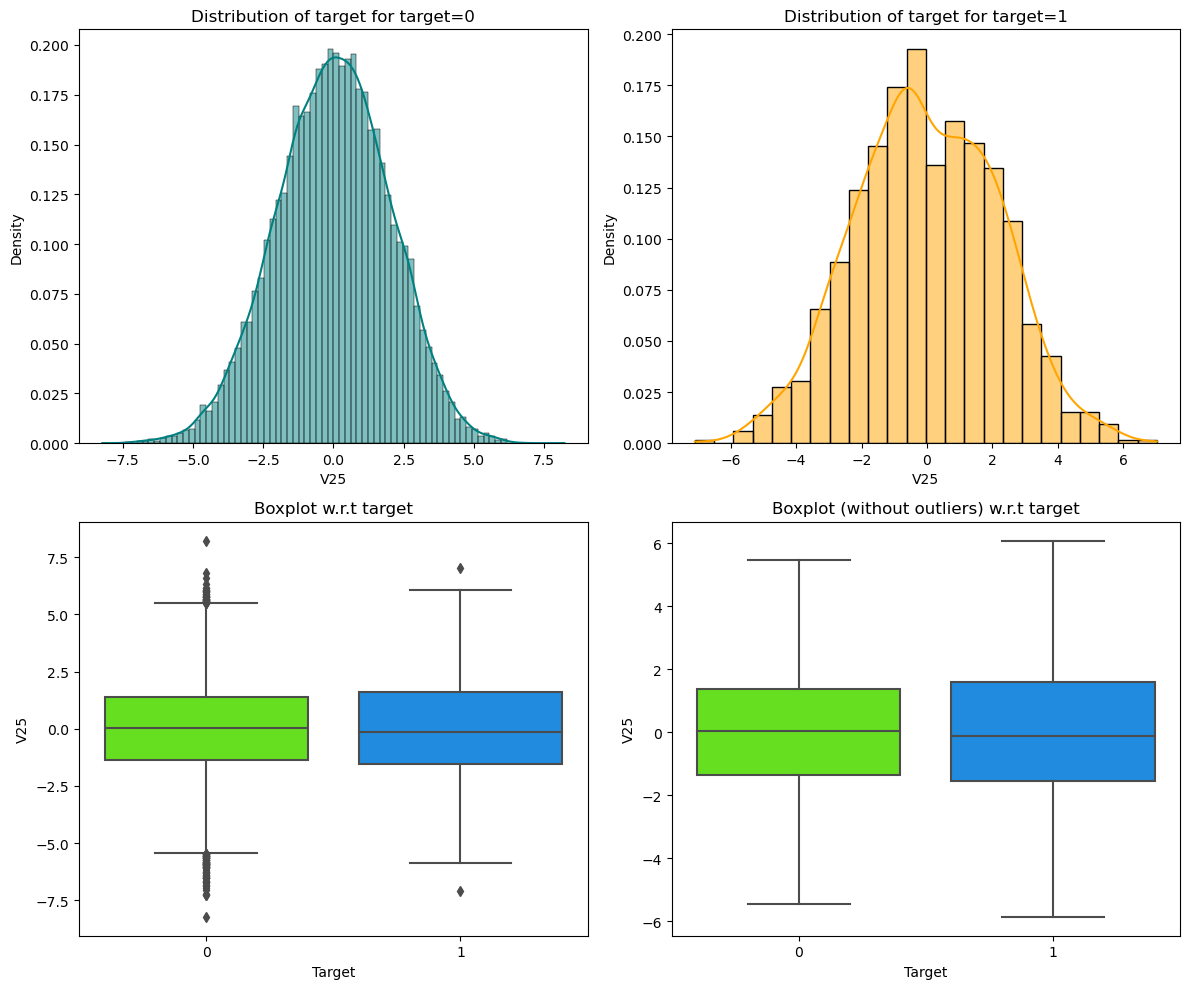

 Target  vs  V26 


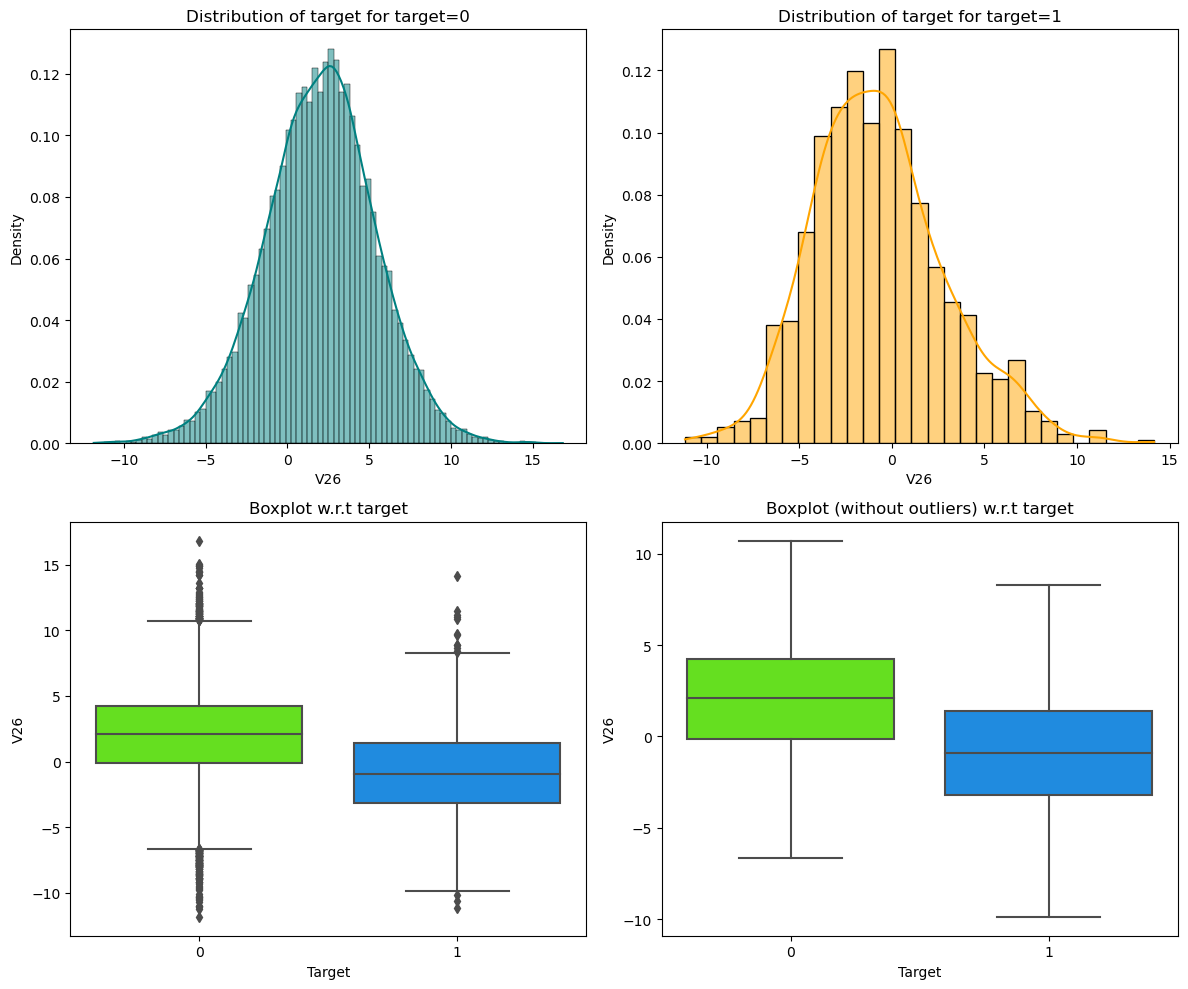

 Target  vs  V27 


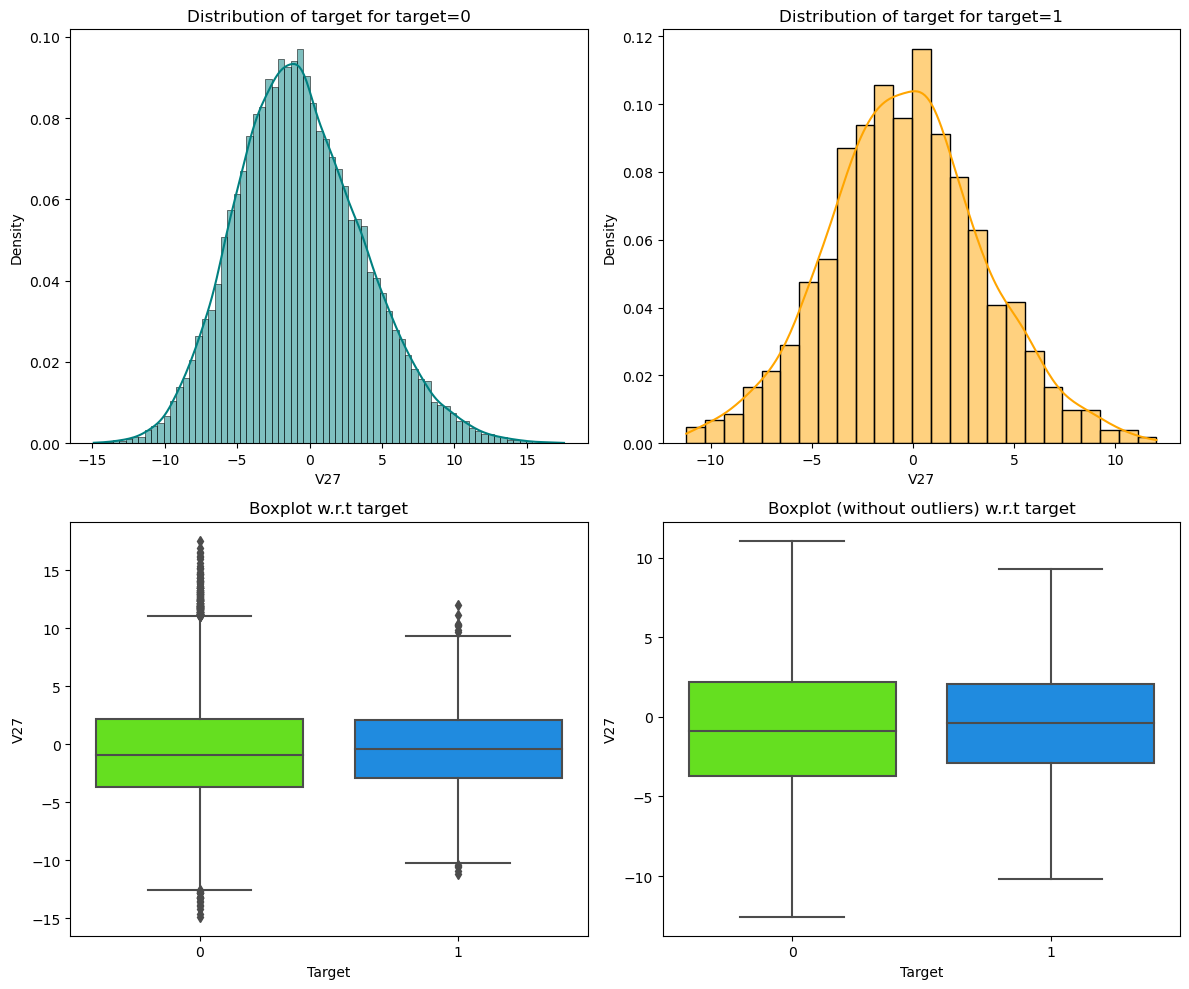

 Target  vs  V28 


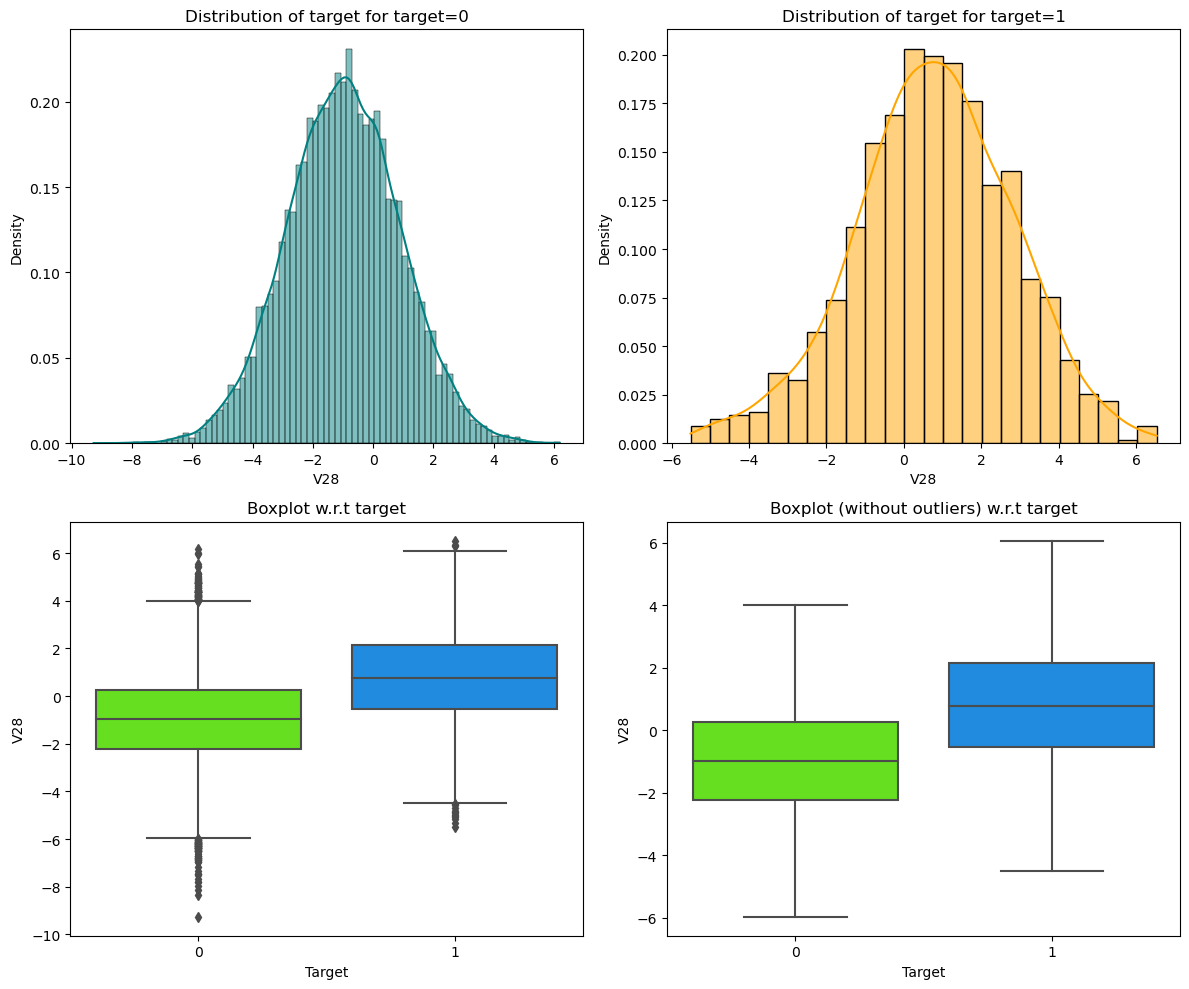

 Target  vs  V29 


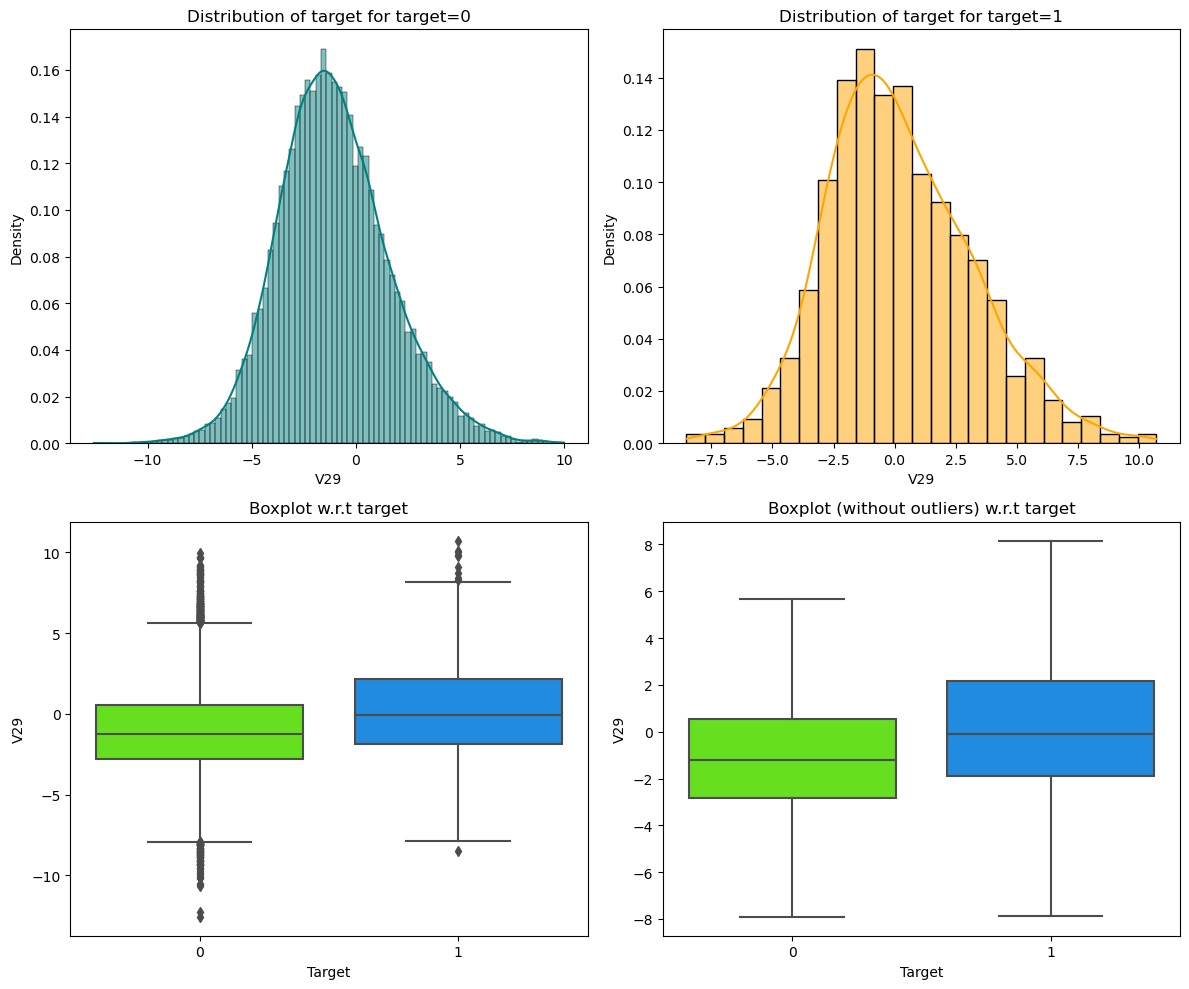

 Target  vs  V30 


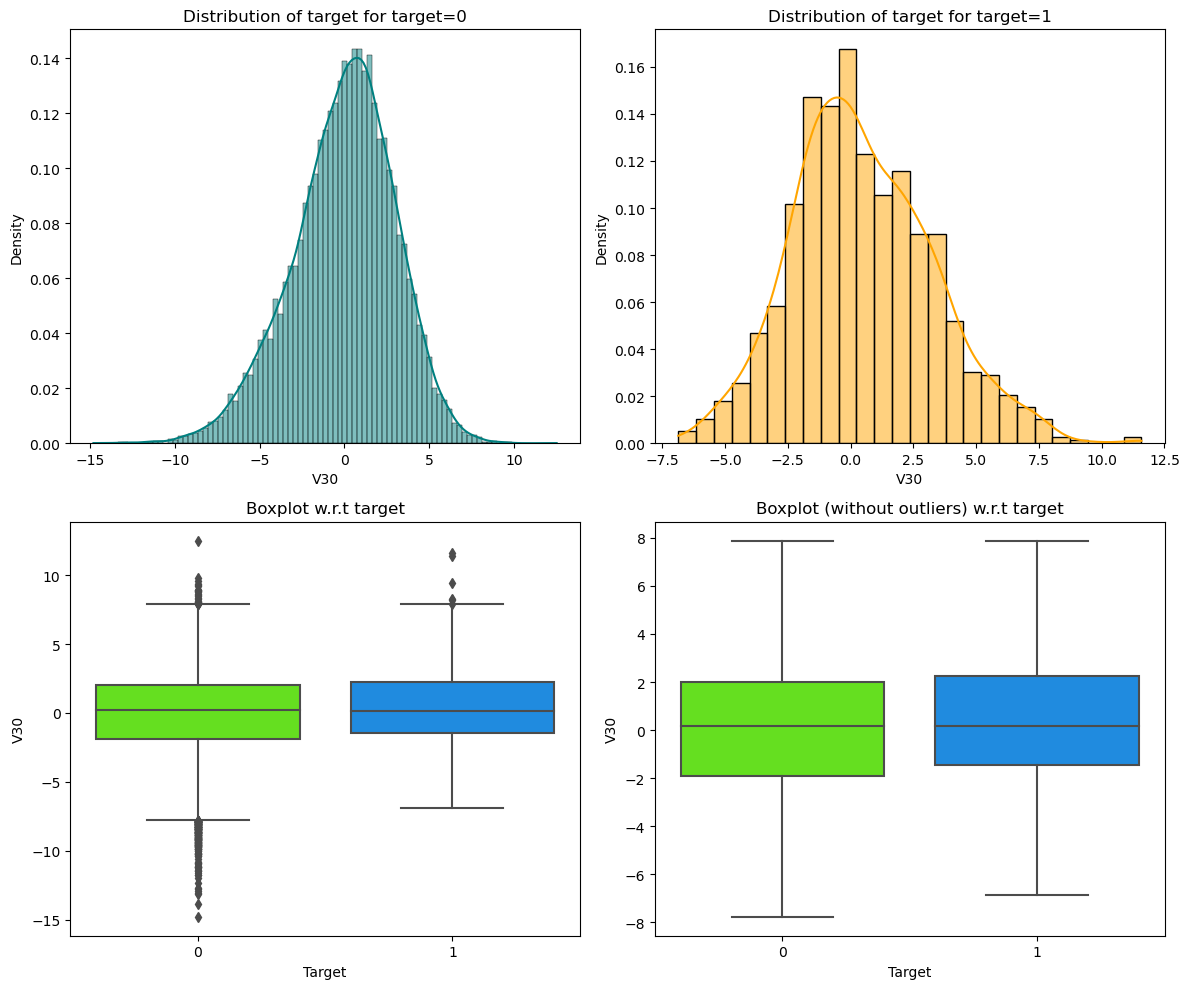

 Target  vs  V31 


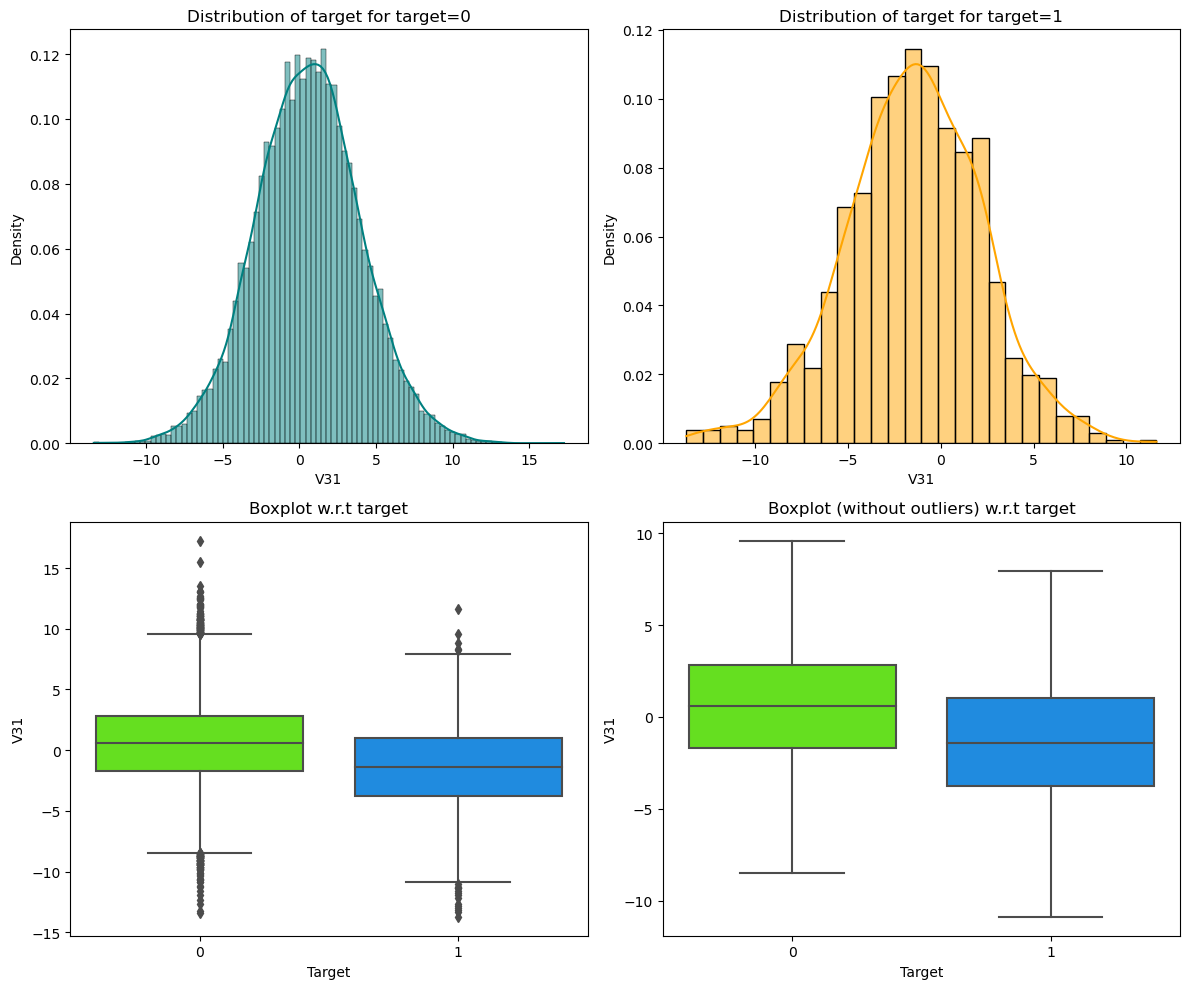

 Target  vs  V32 


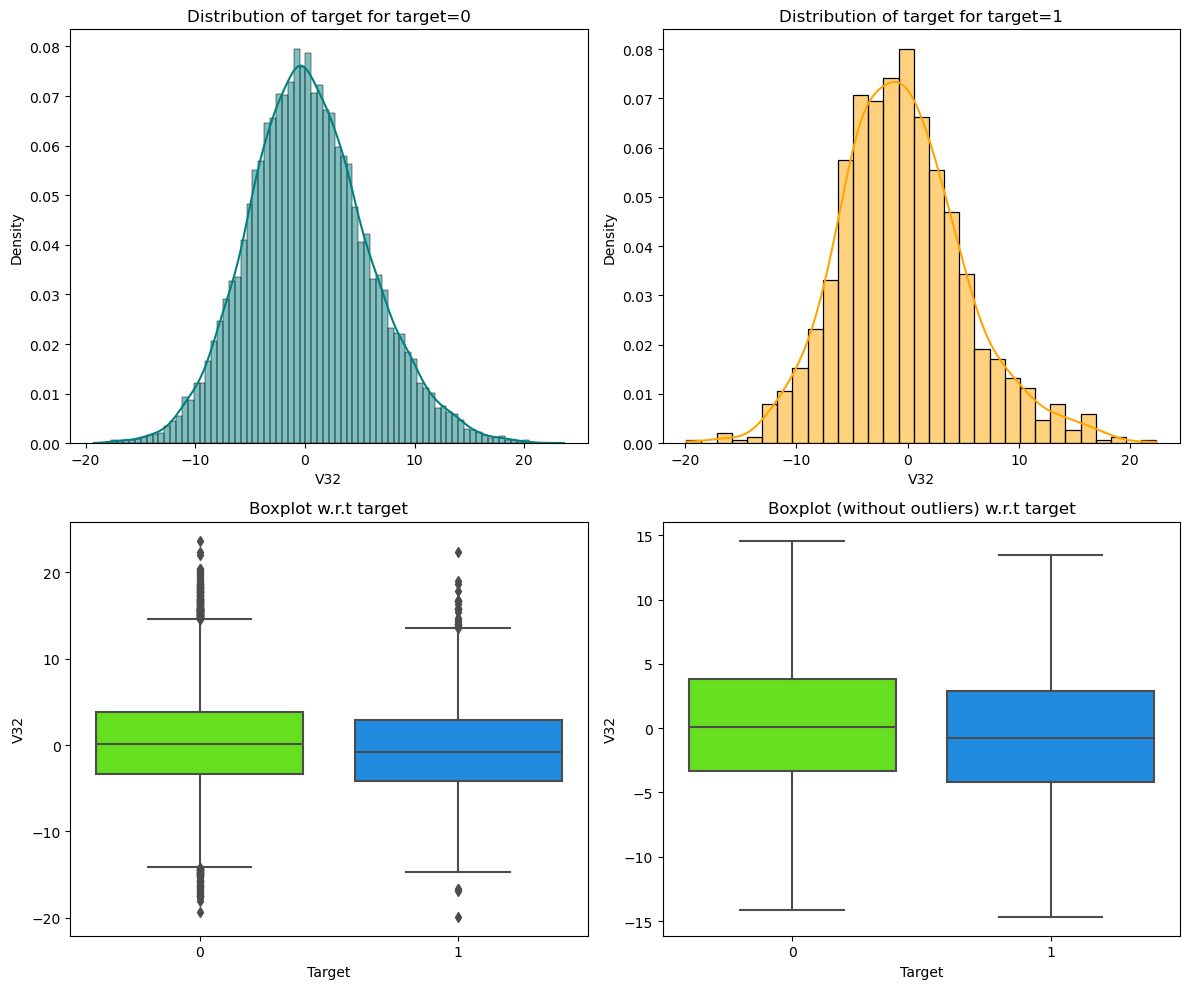

 Target  vs  V33 


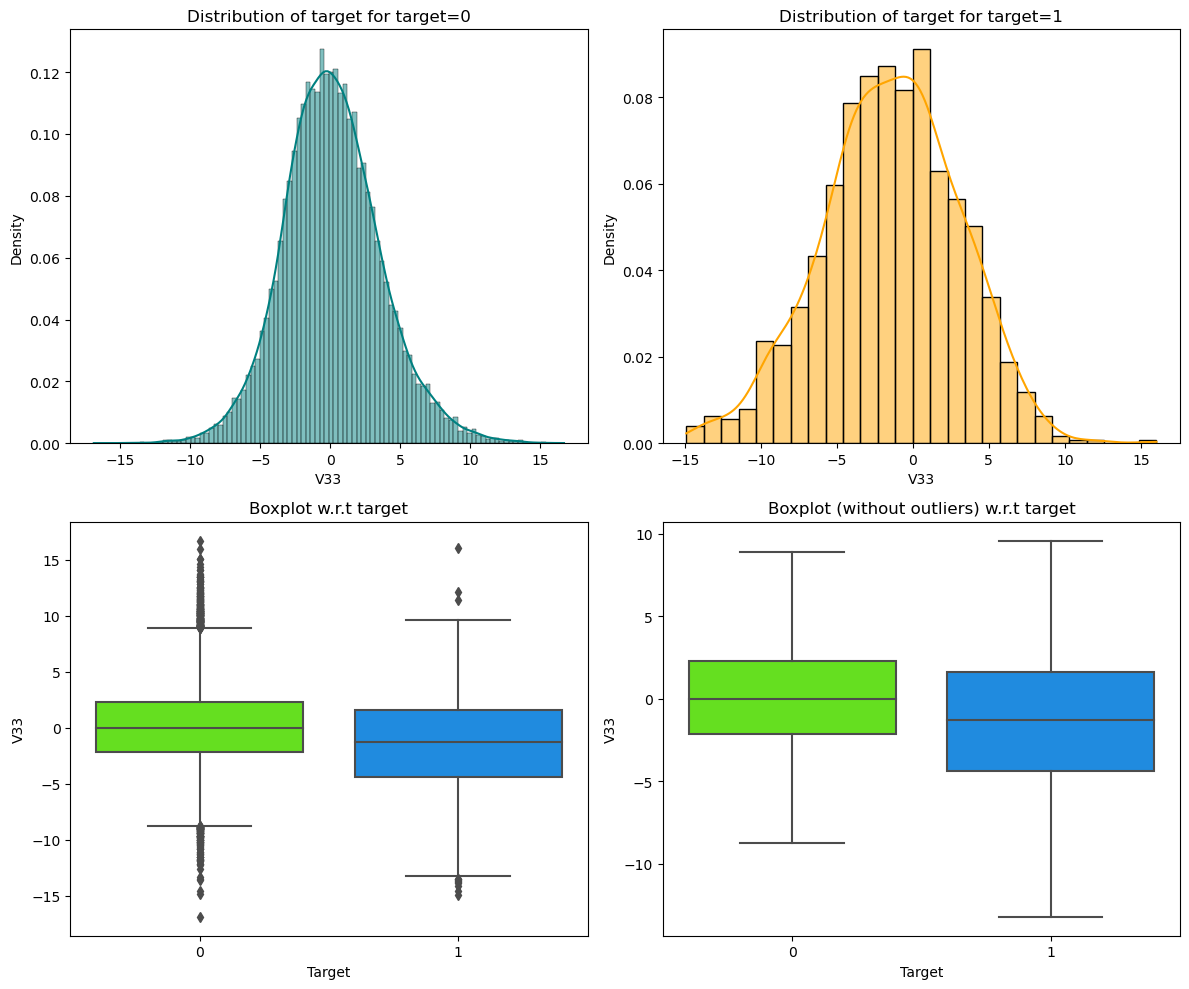

 Target  vs  V34 


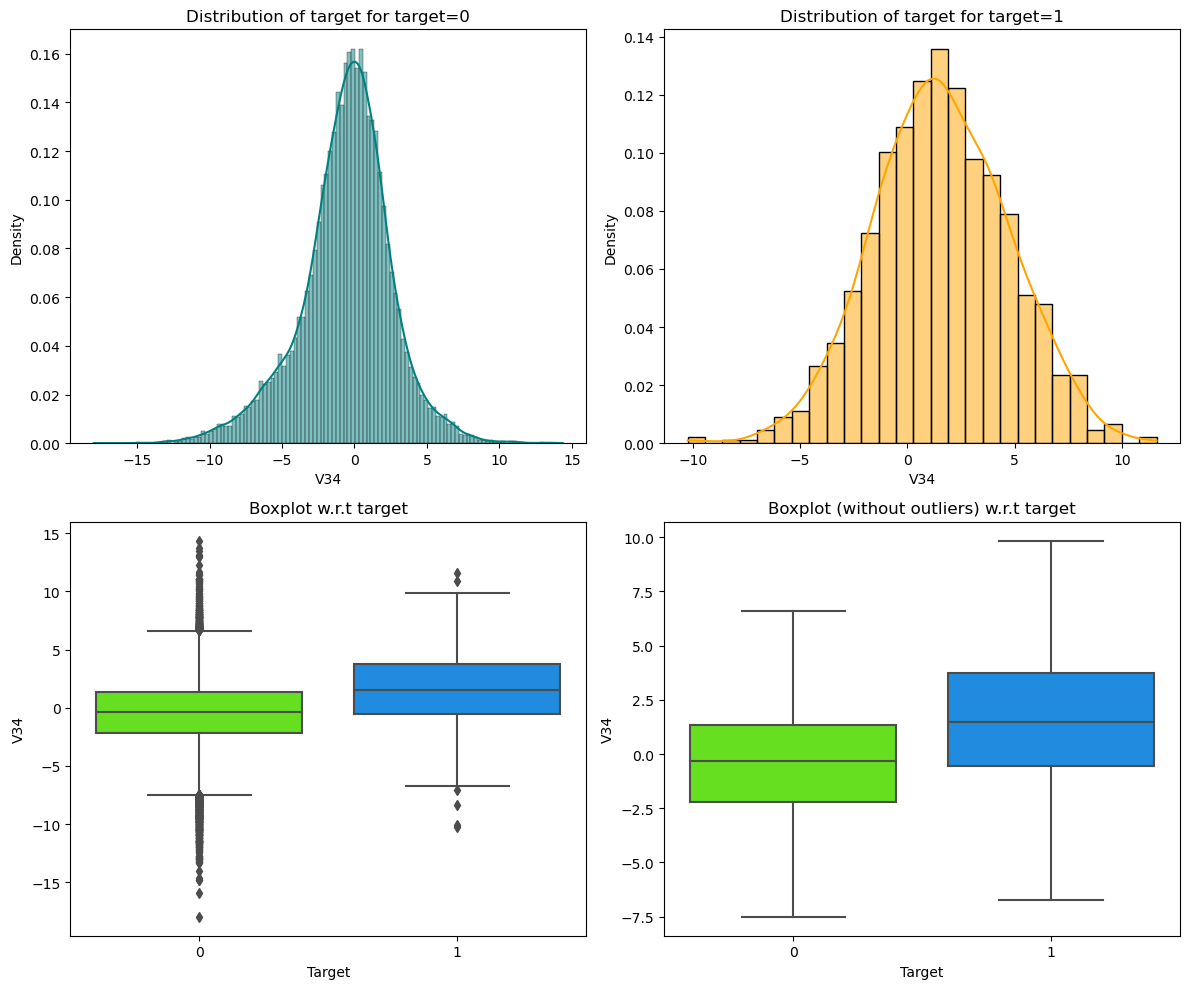

 Target  vs  V35 


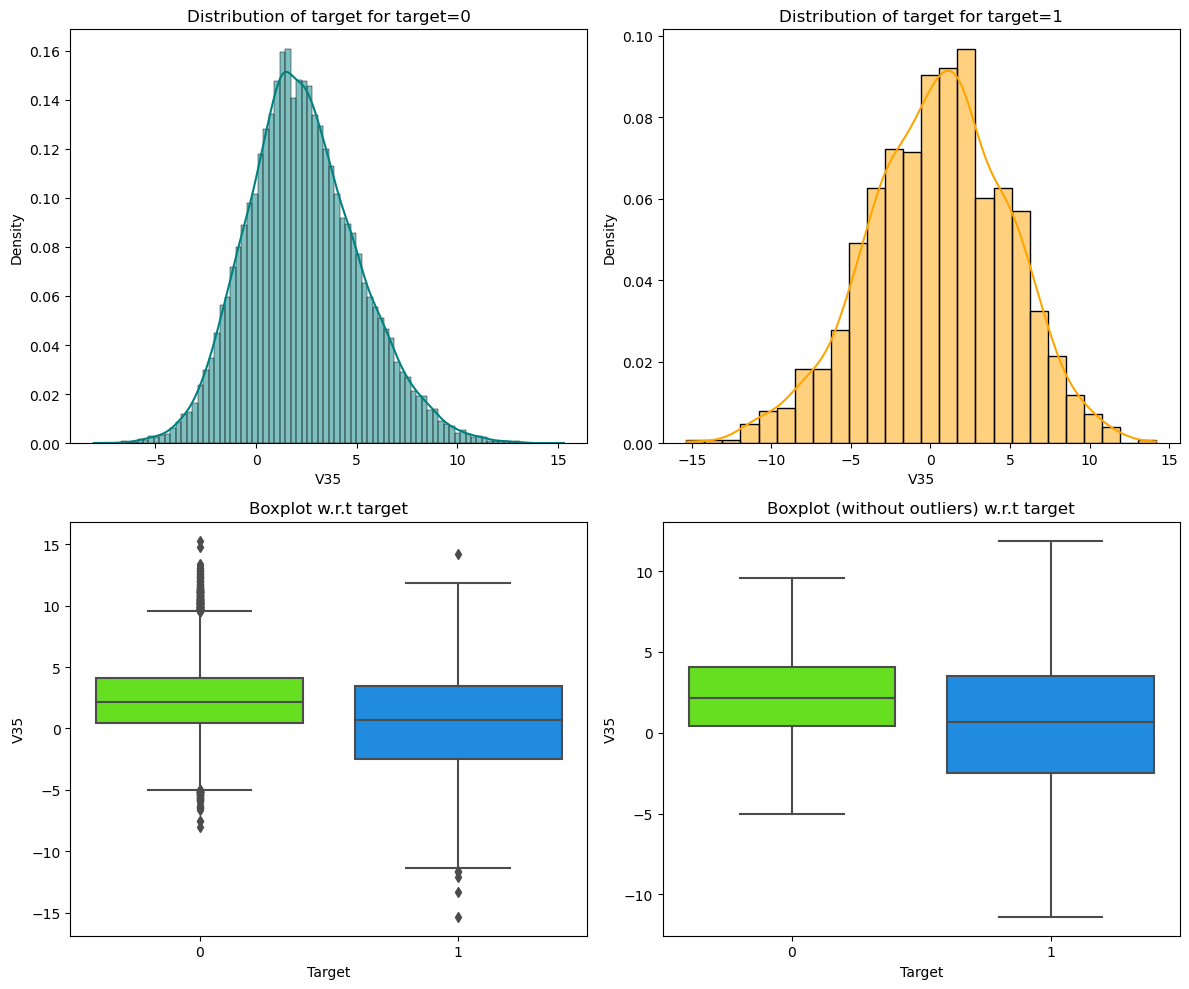

 Target  vs  V36 


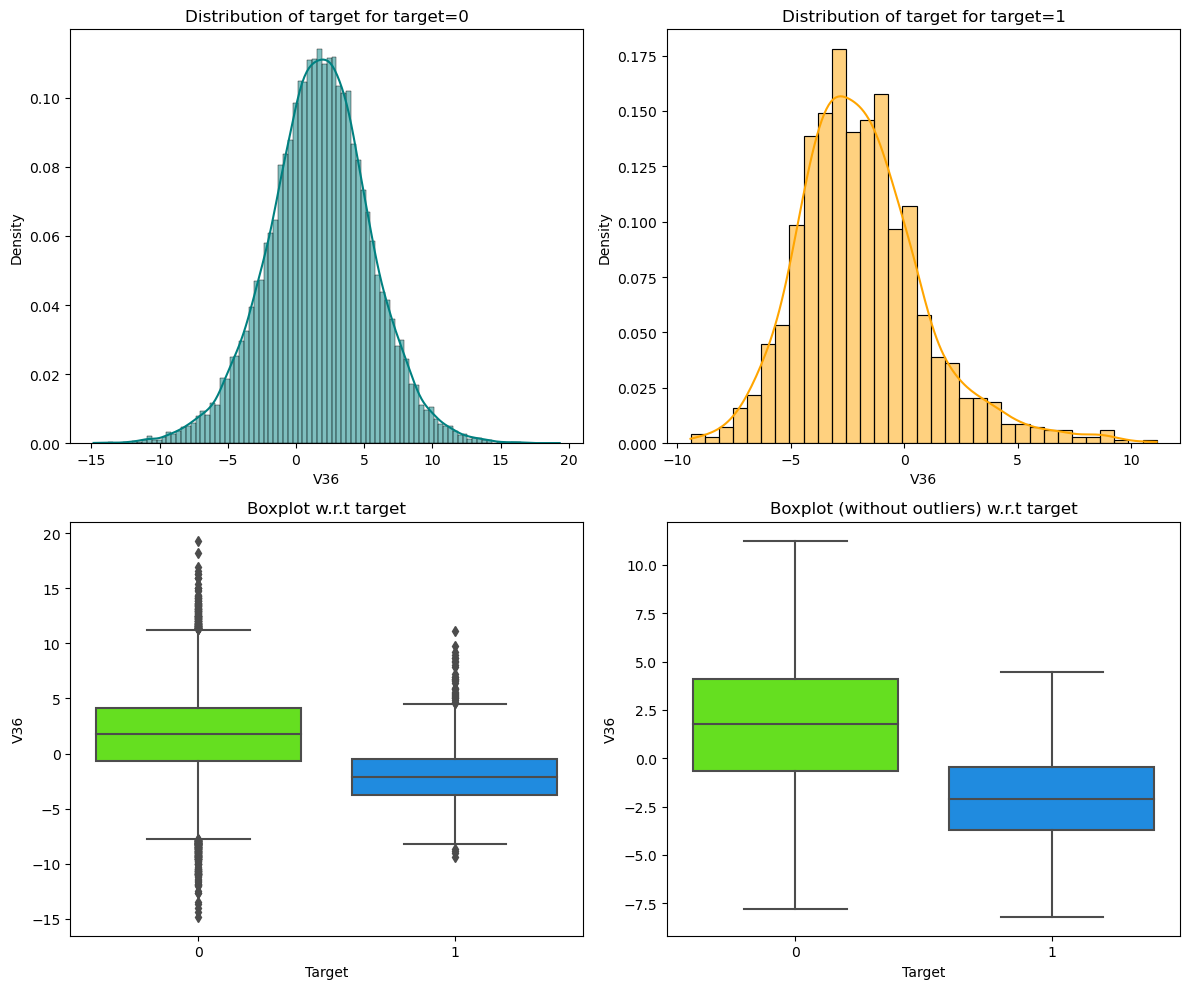

 Target  vs  V37 


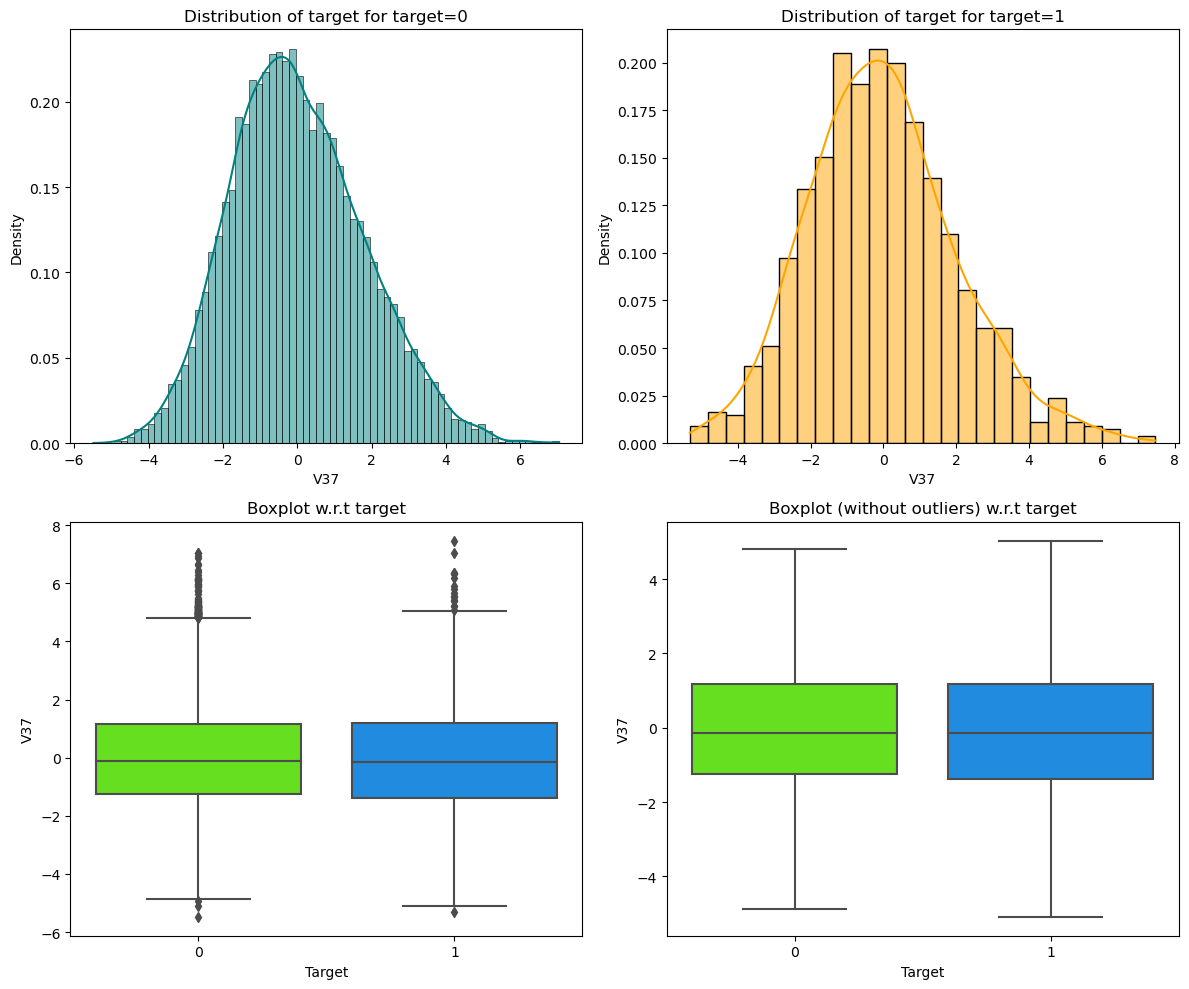

 Target  vs  V38 


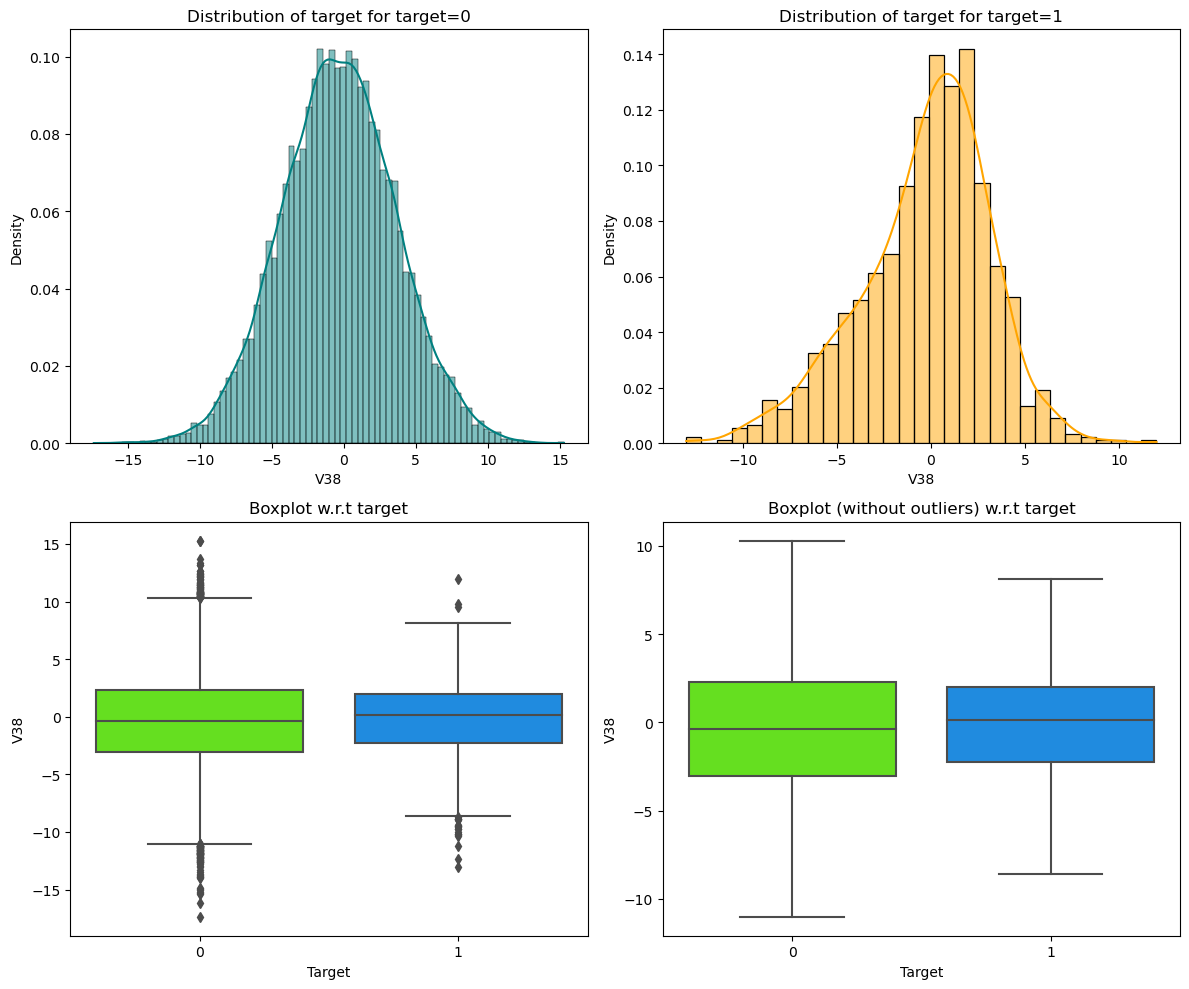

 Target  vs  V39 


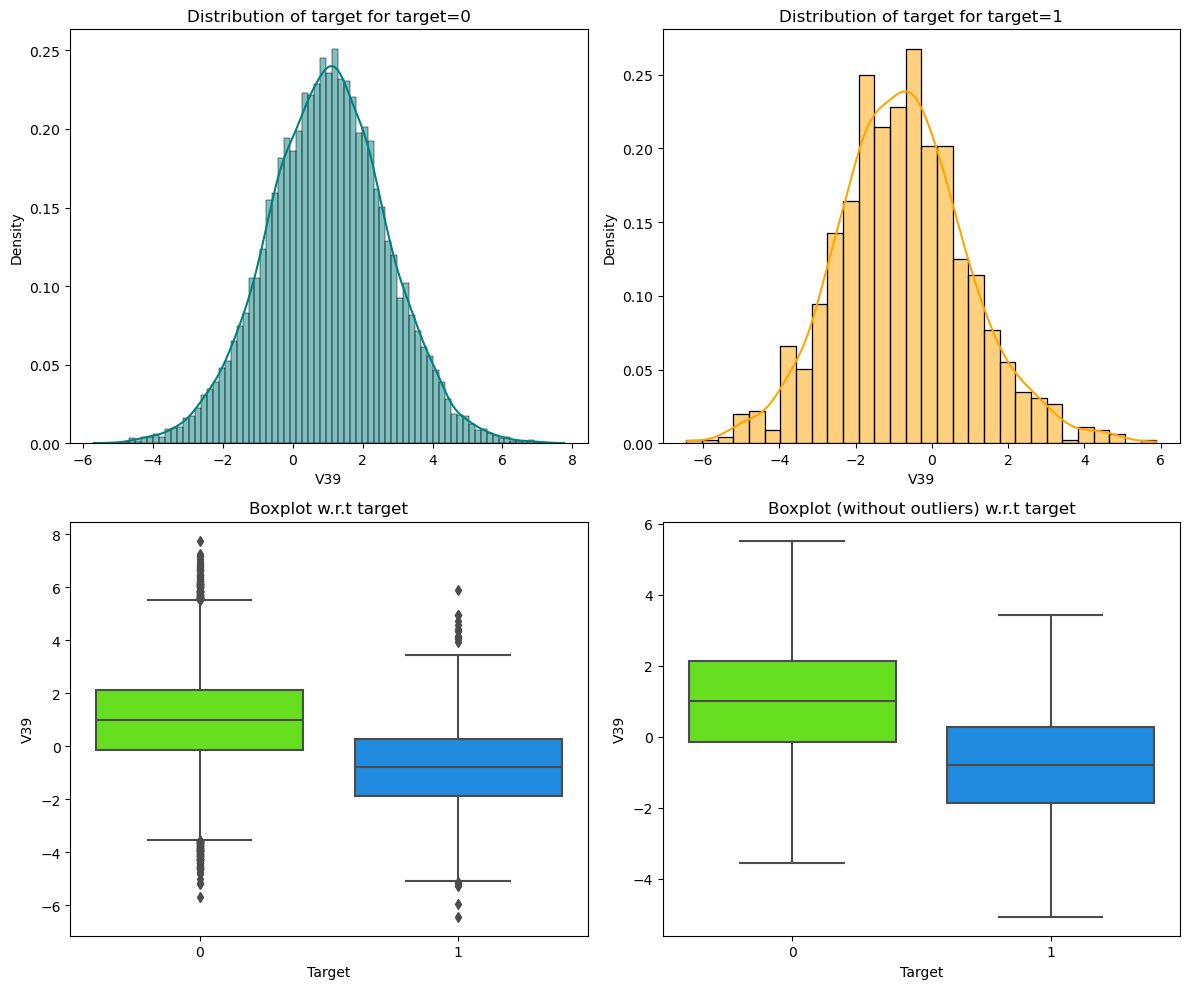

 Target  vs  V40 


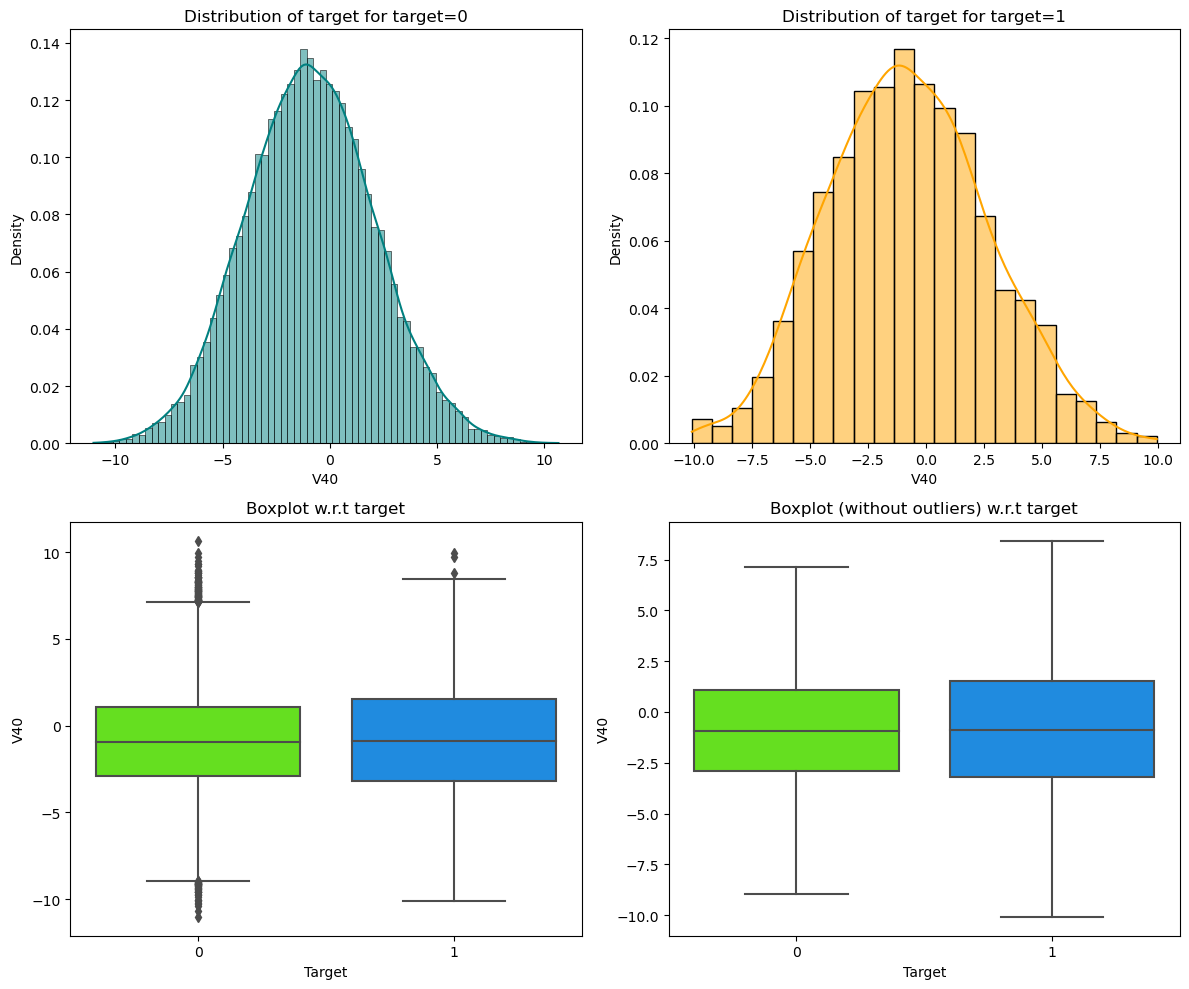

In [316]:
# run interate andplot distributions function on all variables against target
iterate_and_plot_distr(df1, 'Target')

#### Observations:

* Most of the independent variables have a normal distribution
* V1 displays a very slight skew to the right and V16 displays an even slighter skew to the left
* The Target variable is bimodal with only 0 and 1 values. The 0 values far outnumber the 1 values

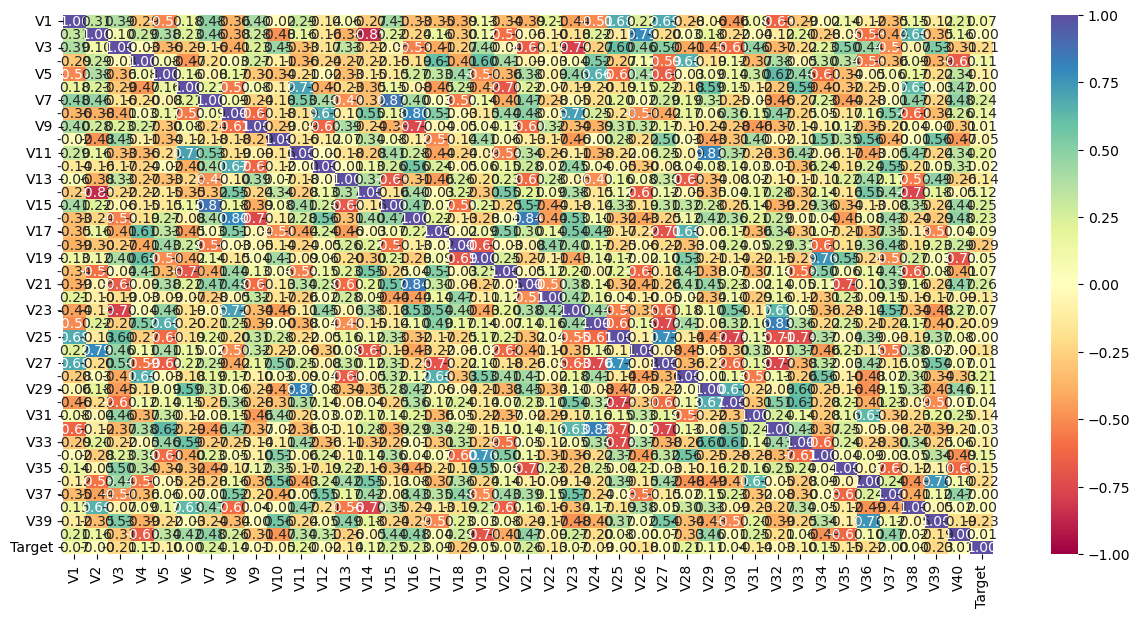

In [317]:
# run a heatmap to check correlation
plt.figure(figsize=(15, 7))
sns.heatmap(df1.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#### Observations:

* There are some fairly significant correlations between variables, but the Target variable has no high correlation values, which is good

## Data Pre-processing

### Outlier Detection

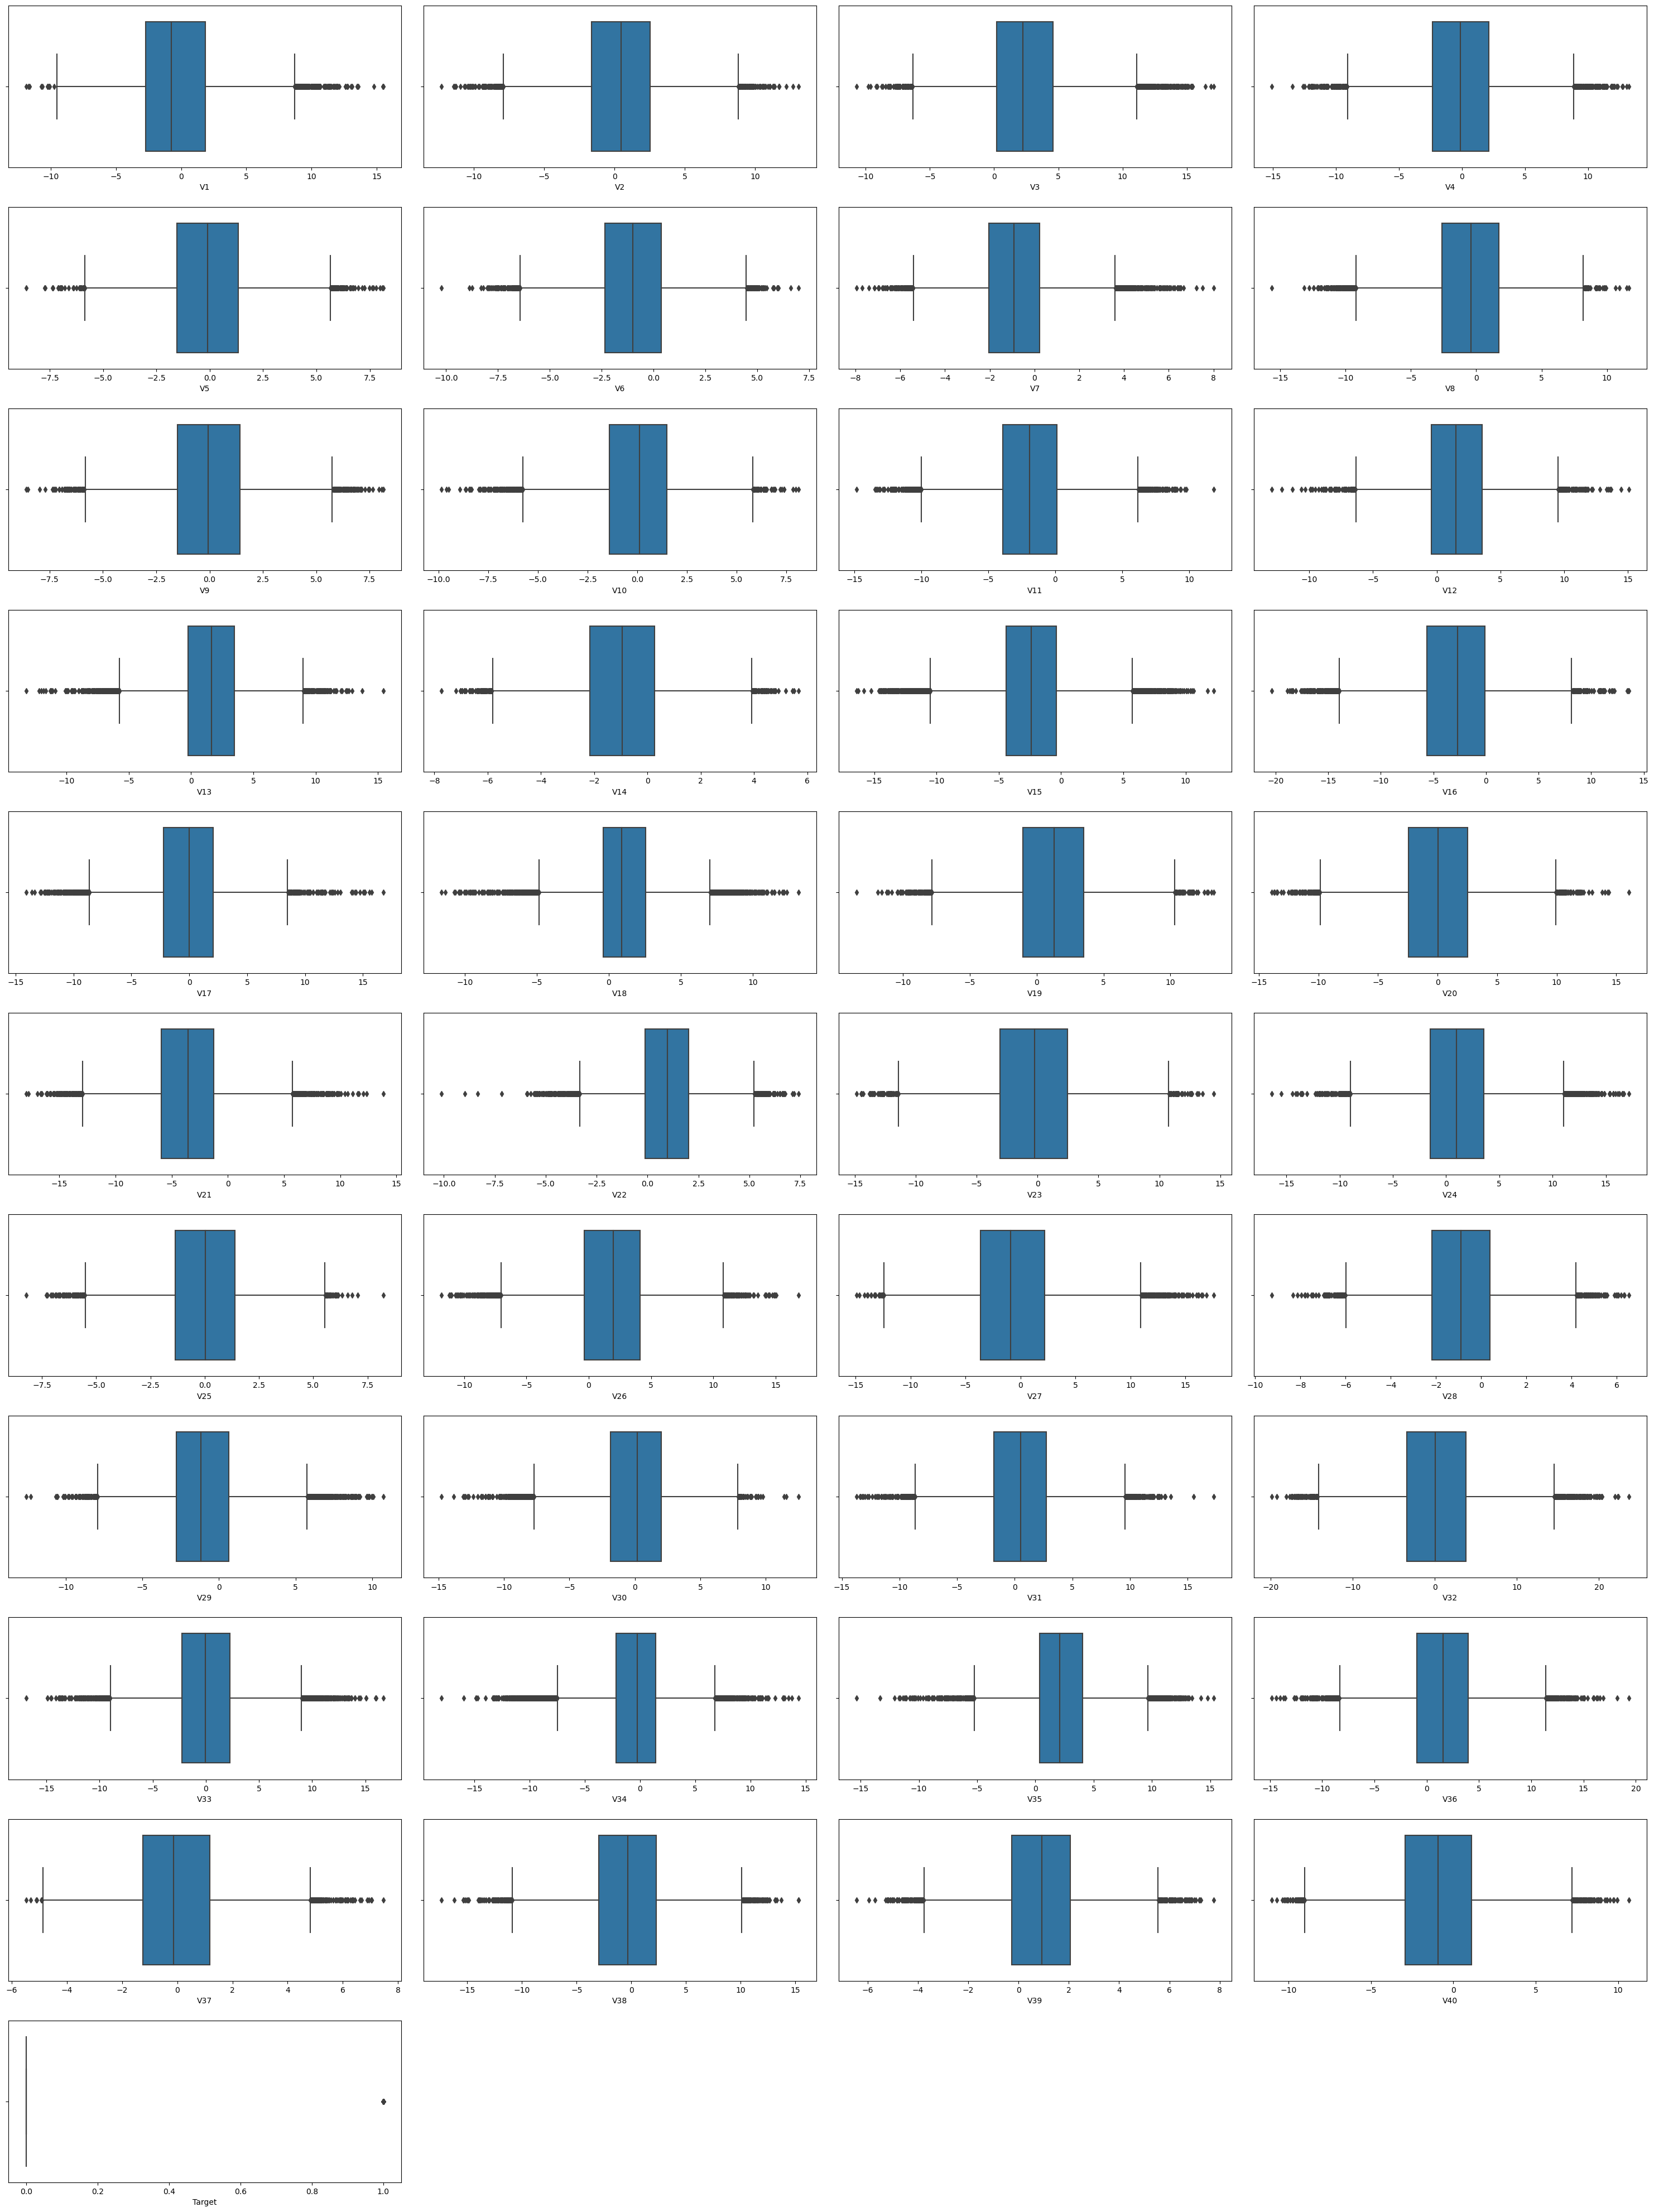

In [54]:
# outlier detection using boxplot from the MLS
num_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(30, 40))

for i, variable in enumerate(num_cols):
    plt.subplot(11, 4, i + 1)
    sns.boxplot(data=df, x=variable)
    plt.tight_layout(pad=2)

plt.show()

#### Observations:

* There are a large number of outliers in each variable, and none are unreasonable
* As I am not a domain expert and as the variable names are nondescript, I will leave the outliers as they are

### Missing Values

In [58]:
# let's check for missing values in the data
round(df.isnull().sum() / df.isnull().count() * 100, 2)

V1       0.090
V2       0.090
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

#### Observations:

* V1 and V2 each are missing 0.090% of their total values

### Data Preparation

In [392]:
# copy to keep df from getting distorted
df1 = df.copy()

In [393]:
# drop dependednt variable and add it to y
X = df1.drop(["Target"], axis=1)
y = df1["Target"]

In [394]:
# Split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(15000, 40) (5000, 40)
(15000,) (5000,)


In [395]:
# determine shape of Train and val dataframe
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])

Number of rows in train data = 15000
Number of rows in validation data = 5000


## Missing value imputation




In [146]:
# view X_train dataset
X_train.head()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
8381  -0.317 -2.777  9.001 -0.053 -1.899 -3.715 -3.017 -0.753 -0.519  3.455   
2462   5.250  4.514  1.073  1.947 -1.517  1.004  0.500 -5.055  3.736 -1.426   
14544 -2.073 -0.622 -1.426 -0.494  0.957 -3.341 -0.811  4.600 -2.031 -1.162   
14095 -3.322 -1.914  2.288 -1.230 -0.353 -0.187 -0.739 -1.530 -1.741  2.463   
2537  -1.916  4.899  6.290  1.694  2.435 -1.941  0.380  1.292 -3.857  0.972   

         V11    V12   V13    V14    V15    V16    V17    V18   V19    V20  \
8381  -6.192  1.978 4.294 -0.068 -4.655 -6.406 -2.224  1.212 4.495  2.947   
2462   1.756 -2.086 1.296 -2.717 -1.771 -7.661 -1.332 -1.202 2.795 -3.098   
14544 -3.335  7.733 4.182  0.301 -5.524 -0.088  1.694  3.055 0.639  0.594   
14095 -1.768  2.507 0.148 -0.521 -1.097 -2.114 -0.922  1.895 2.495  1.003   
2537   0.427  3.419 0.178 -3.113 -0.251  2.694 -3.216 -3.238 4.030 -6.597   

         V21    V22    V23    V24    V25    V26    V27    V28    V29    V30  \
8381  -8.715  0.986 -4.498  1.116  1.963  1.974  2.343 -2.061 -4.546 -2.007   
2462  -6.122  2.531 -1.773 -0.556  0.159  4.070  1.496 -0.197 -0.323 -0.355   
14544 -4.772  4.228  9.382  5.447 -2.474  0.749 -4.680 -1.139 -2.591  2.939   
14095 -0.699 -0.219 -2.413  0.737  0.234 -1.090  1.421  0.585 -1.185 -0.984   
2537  -2.200 -3.005 -2.832  5.909 -3.235  9.155 -4.344 -2.859  2.004  1.789   

         V31    V32    V33    V34   V35    V36    V37    V38    V39    V40  
8381   4.402  0.601 -1.895  1.907 6.866  7.610 -1.079 -4.394  3.189 -4.245  
2462  -3.848 -3.302  0.851 -1.336 3.198 -5.912 -2.133  4.375 -1.180 -2.348  
14544 -0.390  8.347 -0.876 -2.088 3.211  1.822  1.703 -3.389  0.006 -1.274  
14095 -0.368 -2.536 -0.941  3.384 0.112  4.497  0.908  2.332  3.250 -1.512  
2537   8.369  7.465  6.630 -1.560 6.234  1.124 -3.629  1.868  0.049 -1.501

In [398]:
# create a simple imputer variable for median
imputer = SimpleImputer(strategy="median")

In [399]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

In [149]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------


## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [150]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [170]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

In [324]:
%%time
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic Regression", LogisticRegression(random_state=1)))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.7956208065796118
dtree: 0.6982829521679532
Logistic Regression: 0.4927566553639709

Validation Performance:

Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8201438848920863
dtree: 0.7050359712230215
Logistic Regression: 0.48201438848920863
CPU times: user 4min 47s, sys: 2.98 s, total: 4min 50s
Wall time: 4min 34s


#### Observations:

* All around, the models with original data performed well -- there was no overfitting or underfitting
* Xgboost performed the best, with a Train recall score of 0.7956 and a Validation recall score of 0.8201
* Adaboost performed the worst, with a Train recall score of 0.6309 and a Validation recall score of 0.6762

### Model Building with Oversampled data


In [180]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 832
Before Oversampling, counts of label 'No': 14168 

After Oversampling, counts of label 'Yes': 14168
After Oversampling, counts of label 'No': 14168 

After Oversampling, the shape of train_X: (28336, 40)
After Oversampling, the shape of train_y: (28336,) 



In [326]:
%%time
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic Regression", LogisticRegression(random_state=1)))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
Xgboost: 0.989554053559209
dtree: 0.9720494245534969
Logistic Regression: 0.883963699328486

Validation Performance:

Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8561151079136691
Xgboost: 0.8669064748201439
dtree: 0.7769784172661871
Logistic Regression: 0.8489208633093526
CPU times: user 8min 16s, sys: 2.35 s, total: 8min 19s
Wall time: 6min 19s


#### Observations:

* The Oversampled data performed very well in the train data, but slightly overfit the validation data
* The largest overfit model was the Decision Tree, which had a Train recall score of 0.9720 and a Validation recall score of 0.7770
* The least overfit model, and therefore likely the best mode for the Oversampled data, was the Adaboost, whcih had a Train recall score of 0.8979 and a Validation recall score of 0.8561

### Model Building with Undersampled data

In [182]:
print("Before Undersampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)


print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(sum(y_train_under == 0)))


print("After Undersampling, the shape of train_X: {}".format(X_train_under.shape))
print("After Undersampling, the shape of train_y: {} \n".format(y_train_under.shape))

Before Undersampling, counts of label 'Yes': 832
Before Undersampling, counts of label 'No': 14168 

After Undersampling, counts of label 'Yes': 832
After Undersampling, counts of label 'No': 832 

After Undersampling, the shape of train_X: (1664, 40)
After Undersampling, the shape of train_y: (1664,) 



In [328]:
%%time
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic Regression", LogisticRegression(random_state=1)))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_under, y_train_under)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
GBM: 0.8990621167303946
Adaboost: 0.8666113556020489
Xgboost: 0.9074742082100858
dtree: 0.8617776495202367
Logistic Regression: 0.8726138085275232

Validation Performance:

Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
GBM: 0.8884892086330936
Adaboost: 0.8489208633093526
Xgboost: 0.9028776978417267
dtree: 0.841726618705036
Logistic Regression: 0.8525179856115108
CPU times: user 24.3 s, sys: 193 ms, total: 24.5 s
Wall time: 17.6 s


#### Observations:

* While the Undersampled data performed slightly worse than the Oversampled Train set, it performed about as well as the Oversampled Validation set
* The Undersampled data did not overfit on any of the models
* The Undersampled models took far less time to run than either the Oversampled or Original models
* The best Undersampled model was Xgboost, which had a Train recall score of 0.9075 and a Validation recall score of 0.9029

## HyperparameterTuning 

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**


- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}


### Tuning method for Decision tree with original data

In [406]:
%%time
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 51),           # Adjust the range based on your data
    'min_samples_split': np.arange(2, 21),   # Adjust the range based on your data
    'min_samples_leaf': np.arange(1, 21),    # Adjust the range based on your data
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7]
}


#param_grid = {'max_depth': np.arange(2,6),
#              'min_samples_leaf': [1, 4, 7], 
#              'max_leaf_nodes' : [10,15],
#              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=15, n_jobs = 1, scoring=scorer, cv=15, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 32, 'criterion': 'entropy'} with CV score=0.731082251082251:
CPU times: user 1min 33s, sys: 923 ms, total: 1min 34s
Wall time: 1min 45s


### Tuning method for Decision tree with oversampled data

In [412]:
%%time
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 51),           # Adjust the range based on your data
    'min_samples_split': np.arange(2, 21),   # Adjust the range based on your data
    'min_samples_leaf': np.arange(1, 21),    # Adjust the range based on your data
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=15, n_jobs = 1, scoring=scorer, cv=15, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 45, 'criterion': 'entropy'} with CV score=0.9680992736077483:
CPU times: user 2min 32s, sys: 1.09 s, total: 2min 34s
Wall time: 2min 45s


### Tuning method for Decision tree with undersampled data

In [413]:
%%time
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 51),           # Adjust the range based on your data
    'min_samples_split': np.arange(2, 21),   # Adjust the range based on your data
    'min_samples_leaf': np.arange(1, 21),    # Adjust the range based on your data
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=15, n_jobs = 1, scoring=scorer, cv=15, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 0.7, 'max_depth': 45, 'criterion': 'entropy'} with CV score=0.8630086580086581:
CPU times: user 6.36 s, sys: 36.5 ms, total: 6.39 s
Wall time: 6.57 s


#### Observations:

* The oversampled model gave the best CV score, 0.968
* The model with original data gave the worst CV score, 0.731

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}


### Tuning method for Bagging Classifier with original data

In [448]:
%%time
# defining model
Model = BaggingClassifier(random_state=1)


param_grid = {
    'n_estimators': [30, 50, 100],  # Number of base estimators
    'max_samples': [0.5, 0.7, 0.9],  # Fraction of samples to draw for each base estimator
    'max_features': [0.5, 0.7, 0.9],  # Fraction of features to draw for each base estimator
    'bootstrap': [True, False]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 100, 'max_samples': 0.9, 'max_features': 0.7, 'bootstrap': False} with CV score=0.7476877570160883:
CPU times: user 20min 16s, sys: 3.37 s, total: 20min 19s
Wall time: 20min 31s


### Tuning method for Bagging Classifier with oversampled data

In [449]:
%%time
# defining model
Model = BaggingClassifier(random_state=1)


param_grid = {
    'n_estimators': [30, 50, 100],  # Number of base estimators
    'max_samples': [0.5, 0.7, 0.9],  # Fraction of samples to draw for each base estimator
    'max_features': [0.5, 0.7, 0.9],  # Fraction of features to draw for each base estimator
    'bootstrap': [True, False]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 100, 'max_samples': 0.9, 'max_features': 0.7, 'bootstrap': False} with CV score=0.9853897544341429:
CPU times: user 27min 28s, sys: 6.07 s, total: 27min 34s
Wall time: 27min 52s


### Tuning method for Bagging Classifier with undersampled data

In [450]:
%%time
# defining model
Model = BaggingClassifier(random_state=1)


param_grid = {
    'n_estimators': [30, 50, 100],  # Number of base estimators
    'max_samples': [0.5, 0.7, 0.9],  # Fraction of samples to draw for each base estimator
    'max_features': [0.5, 0.7, 0.9],  # Fraction of features to draw for each base estimator
    'bootstrap': [True, False]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 50, 'max_samples': 0.7, 'max_features': 0.5, 'bootstrap': False} with CV score=0.9038236779453144:
CPU times: user 56.1 s, sys: 284 ms, total: 56.4 s
Wall time: 57.1 s


#### Observations:

* The oversampled model gave the best CV score, 0.985
* The model with original data gave the worst CV score, 0.748
* While the undersampled model did not have as high of a CV score (0.904) compared to the oversampled model, the computation time was significantly better: 56.4 Seconds, compared to 27 Minutes and 34 Seconds

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**


- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}


### Tuning method for Random Forest with original data

In [451]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 8),
    "max_features": [np.arange(0.1, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.1, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6924175744895751:
CPU times: user 4min 28s, sys: 1.09 s, total: 4min 29s
Wall time: 4min 31s


### Tuning method for Random Forest with oversampled data

In [452]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 8),
    "max_features": [np.arange(0.1, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.1, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9818606498020482:
CPU times: user 6min 33s, sys: 2.54 s, total: 6min 35s
Wall time: 6min 43s


### Tuning method for Random Forest with undersampled data

In [453]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 8),
    "max_features": [np.arange(0.1, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.1, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.8978140105331505:
CPU times: user 20.6 s, sys: 158 ms, total: 20.7 s
Wall time: 20.9 s


#### Observations:

* The oversampled model gave the best CV score, 0.982
* The model with original data gave the worst CV score, 0.692

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**


- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}


### Tuning method for AdaBoost with original data

In [454]:
%%time
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of base estimators
    'learning_rate': [0.001, 0.05, 0.1],  # Learning rate for each base estimator
    'algorithm': ['SAMME', 'SAMME.R'],  # Algorithm used for updating weights
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1), 'algorithm': 'SAMME.R'} with CV score=0.6791140610345574:
CPU times: user 13min 20s, sys: 3.05 s, total: 13min 23s
Wall time: 13min 34s


### Tuning method for AdaBoost with oversampled data

In [465]:
%%time
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of base estimators
    'learning_rate': [0.001, 0.05, 0.1],  # Learning rate for each base estimator
    'algorithm': ['SAMME', 'SAMME.R'],  # Algorithm used for updating weights
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1), 'algorithm': 'SAMME.R'} with CV score=0.9249013479355744:
CPU times: user 38min 47s, sys: 27.5 s, total: 39min 15s
Wall time: 48min 10s


### Tuning method for AdaBoost with undersampled data

In [463]:
%%time
# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of base estimators
    'learning_rate': [0.001, 0.05, 0.1],  # Learning rate for each base estimator
    'algorithm': ['SAMME', 'SAMME.R'],  # Algorithm used for updating weights
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1), 'algorithm': 'SAMME.R'} with CV score=0.8858091046822019:
CPU times: user 1min 27s, sys: 1.22 s, total: 1min 29s
Wall time: 1min 44s


#### Observations:

* The oversampled model gave the best CV score, 0.9925
* The model with original data gave the worst CV score, 0.679
* While the undersampled model did not have as high of a CV score (0.886) compared to the oversampled model, the computation time was significantly better: 1 Minute and 29 Seconds, compared to 39 Minutes and 15 Seconds

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}


### Tuning method for Gradient Boosting with original data

In [457]:
%%time
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'n_estimators': [100, 125, 150],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2, 1],  # Learning rate for each base estimator
    'max_features': [0.5, 0.7, 0.9],  # Minimum samples required to split an internal node
    'subsample': [0.5, 0.7, 0.9],  # Fraction of samples used for fitting individual trees
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 100, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.752507034124522:
CPU times: user 5min 58s, sys: 1.23 s, total: 5min 59s
Wall time: 6min 4s


### Tuning method for Gradient Boosting with oversampled data

In [458]:
%%time
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'n_estimators': [100, 125, 150],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2, 1],  # Learning rate for each base estimator
    'max_features': [0.5, 0.7, 0.9],  # Minimum samples required to split an internal node
    'subsample': [0.5, 0.7, 0.9],  # Fraction of samples used for fitting individual trees
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'n_estimators': 150, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9740259533210891:
CPU times: user 11min 51s, sys: 3.01 s, total: 11min 54s
Wall time: 12min


### Tuning method for Gradient Boosting with undersampled data

In [459]:
%%time
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'n_estimators': [100, 125, 150],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2, 1],  # Learning rate for each base estimator
    'max_features': [0.5, 0.7, 0.9],  # Minimum samples required to split an internal node
    'subsample': [0.5, 0.7, 0.9],  # Fraction of samples used for fitting individual trees
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9038236779453142:
CPU times: user 35.6 s, sys: 110 ms, total: 35.7 s
Wall time: 36.1 s


#### Observations:

* The oversampled model gave the best CV score, 0.974
* The model with original data gave the worst CV score, 0.753
* While the undersampled model did not have as high of a CV score (0.904) compared to the oversampled model, the computation time was significantly better: 35.7 Seconds, compared to 11 Minutes and 54 Seconds

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Tuning method for XGBoost with original data

In [460]:
%%time
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [50, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9, 1.0]
}
#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.8510136353798428:
CPU times: user 19min, sys: 5.45 s, total: 19min 5s
Wall time: 5min 27s


### Tuning method for XGBoost with oversampled data

In [461]:
%%time
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [50, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9, 1.0]
}
#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 5} with CV score=0.9955534641752448:
CPU times: user 36min 9s, sys: 8.67 s, total: 36min 17s
Wall time: 10min 23s


### Tuning method for XGBoost with undersampled data

In [462]:
%%time
# defining model
Model = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [50, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9, 1.0]
}
#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 1.0, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 5} with CV score=0.9302575571748071:
CPU times: user 2min 18s, sys: 1.5 s, total: 2min 20s
Wall time: 41 s


#### Observations:

* The oversampled model gave the best CV score, 0.996
* The model with original data gave the worst CV score, 0.851
* While the undersampled model did not have as high of a CV score (0.930) compared to the oversampled model, the computation time was significantly better: 2 Minutes and 20 Seconds, compared to 36 Minutes and 17 Seconds

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}


### Tuning method for Logistic Regression with original data

In [438]:
%%time
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty ('l1' for Lasso, 'l2' for Ridge)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithm for fitting the model
    'class_weight': [None, 'balanced'],  # Weight assigned to classes to handle class imbalance
    'random_state': [1]  # Set a random seed for reproducibility
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=15, n_jobs = 1, scoring=scorer, cv=15, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'solver': 'lbfgs', 'random_state': 1, 'penalty': 'l2', 'class_weight': 'balanced', 'C': 1.0} with CV score=0.8655411255411256:
CPU times: user 3min 48s, sys: 2.56 s, total: 3min 51s
Wall time: 4min 1s


### Tuning method for Logistic Regression with oversampled data

In [437]:
%%time
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty ('l1' for Lasso, 'l2' for Ridge)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithm for fitting the model
    'class_weight': [None, 'balanced'],  # Weight assigned to classes to handle class imbalance
    'random_state': [1]  # Set a random seed for reproducibility
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=15, n_jobs = 1, scoring=scorer, cv=15, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'solver': 'lbfgs', 'random_state': 1, 'penalty': 'l2', 'class_weight': None, 'C': 0.001} with CV score=0.8841781753504917:
CPU times: user 1min 49s, sys: 1.52 s, total: 1min 51s
Wall time: 1min 31s


### Tuning method for Logistic Regression with undersampled data

In [436]:
%%time
# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty ('l1' for Lasso, 'l2' for Ridge)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithm for fitting the model
    'class_weight': [None, 'balanced'],  # Weight assigned to classes to handle class imbalance
    'random_state': [1]  # Set a random seed for reproducibility
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=15, n_jobs = 1, scoring=scorer, cv=15, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'solver': 'lbfgs', 'random_state': 1, 'penalty': 'l2', 'class_weight': 'balanced', 'C': 1.0} with CV score=0.8727489177489178:
CPU times: user 7.71 s, sys: 260 ms, total: 7.97 s
Wall time: 7.02 s


#### Observations:

* The oversampled model gave the best CV score, 0.884
* The model with original data gave the worst CV score, 0.866

## Model performance comparison and choosing the final model

In [214]:
# confusion matrix function from MLS
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [516]:
# create a dataframe to run through the next function
models = pd.DataFrame ({'Models': ['DecisionTree Originial', 'DecisionTree Oversampled', 'DecisionTree Undersampled',
                                   'BaggingClassifier Original', 'BaggingClassifier Oversampled', 'BaggingClassifier Undersampled',
                                   'RandomForest Originial', 'RandomForest Oversampled', 'RandomForest Undersampled',
                                   'AdaBoost Orignial', 'AdaBoost Oversampled', 'AdaBoost Undersampled', 
                                   'GradientBoosting Original', 'GradientBoosting Oversampled', 'GradientBoosting Undersampled', 
                                   'XGBoost Orignial', 'XGBoost Oversampled', 'XGBoost Undersampled',
                                   'LogisticRegression Original', 'LogisticRegression Oversampled', 'LogisticRegression Undersampled'],
                    'Classifier': ['DecisionTreeClassifier', 'DecisionTreeClassifier', 'DecisionTreeClassifier', 
                                   'BaggingClassifier', 'BaggingClassifier', 'BaggingClassifier', 
                                   'RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier', 
                                   'AdaBoostClassifier', 'AdaBoostClassifier', 'AdaBoostClassifier', 
                                   'GradientBoostingClassifier', 'GradientBoostingClassifier', 'GradientBoostingClassifier', 
                                   'XGBClassifier', 'XGBClassifier', 'XGBClassifier', 
                                   'LogisticRegression', 'LogisticRegression', 'LogisticRegression'],
                    'Parameters': ['min_samples_split= 6, min_samples_leaf= 4, max_features= 0.7, max_depth= 32, criterion= "entropy"',
                                  'min_samples_split= 12, min_samples_leaf= 2, max_features= None, max_depth= 45, criterion= "entropy"',
                                  'min_samples_split= 15, min_samples_leaf= 9, max_features= 0.7, max_depth= 45, criterion= "entropy"',
                                   'n_estimators= 100, max_samples= 0.9, max_features= 0.7, bootstrap= False',
                                   'n_estimators= 100, max_samples= 0.9, max_features= 0.7, bootstrap= False',
                                   'n_estimators= 50, max_samples= 0.7, max_features= 0.7, bootstrap= False',
                                   'n_estimators= 200, min_samples_leaf= 1, max_samples= 0.6, max_features= "sqrt"',
                                   'n_estimators= 200, min_samples_leaf= 1, max_samples= 0.6, max_features= "sqrt"',
                                   'n_estimators= 200, min_samples_leaf= 1, max_samples= 0.6, max_features= "sqrt"',
                                   'n_estimators= 200, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(max_depth=2, random_state=1), algorithm= "SAMME.R"',
                                   'n_estimators= 200, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(max_depth=2, random_state=1), algorithm= "SAMME.R"',
                                   'n_estimators= 200, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(max_depth=2, random_state=1), algorithm= "SAMME.R"',
                                   'subsample= 0.7, n_estimators= 100, max_features= 0.5, learning_rate= 0.2',
                                   'subsample= 0.9, n_estimators= 150, max_features= 0.5, learning_rate= 1',
                                   'subsample= 0.5, n_estimators= 125, max_features= 0.7, learning_rate= 0.2',
                                   'subsample= 0.8, scale_pos_weight= 10, n_estimators= 250, learning_rate= 0.1, gamma= 5',
                                   'subsample= 0.9, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.2, gamma= 5',
                                   'subsample= 1.0, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.2, gamma= 5',
                                   'solver= "lbfgs", penalty="l2", class_weight= "balanced", C= 1.0',
                                  'solver= "lbfgs", penalty="l2", class_weight= None, C= 0.001',
                                  'solver= "lbfgs", penalty="l2", class_weight= "balanced", C= 1.0']})

models.head()

Models              Classifier  \
0         DecisionTree Originial  DecisionTreeClassifier   
1       DecisionTree Oversampled  DecisionTreeClassifier   
2      DecisionTree Undersampled  DecisionTreeClassifier   
3     BaggingClassifier Original       BaggingClassifier   
4  BaggingClassifier Oversampled       BaggingClassifier   

                                          Parameters  
0  min_samples_split= 6, min_samples_leaf= 4, max...  
1  min_samples_split= 12, min_samples_leaf= 2, ma...  
2  min_samples_split= 15, min_samples_leaf= 9, ma...  
3  n_estimators= 100, max_samples= 0.9, max_featu...  
4  n_estimators= 100, max_samples= 0.9, max_featu...

Model: DecisionTree Originial
Training performance:
   Accuracy  Recall  Precision    F1
0     0.992   0.891      0.966 0.927
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.974   0.730      0.793 0.760


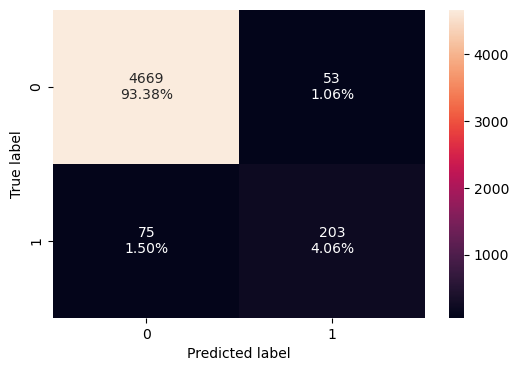

------------------------------------------------------
Model: DecisionTree Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.991   0.885      0.952 0.917
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.972   0.737      0.751 0.744


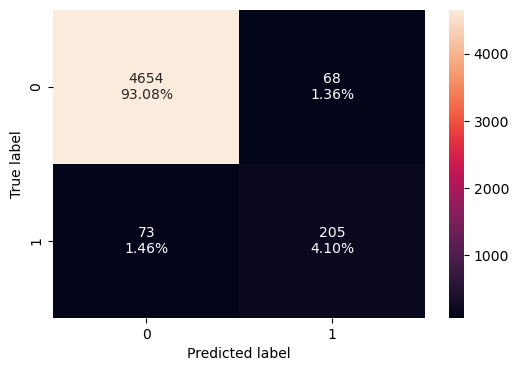

------------------------------------------------------
Model: DecisionTree Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.985   0.788      0.938 0.857
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.974   0.712      0.798 0.753


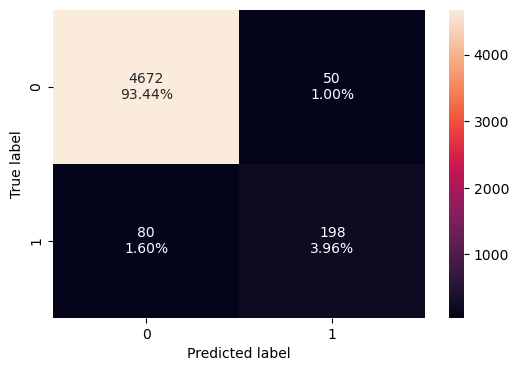

------------------------------------------------------
Model: BaggingClassifier Original
Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.759      0.977 0.854


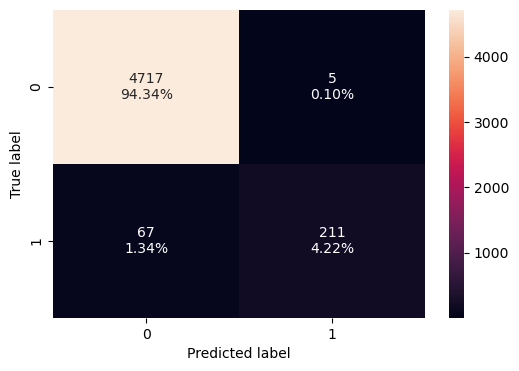

------------------------------------------------------
Model: BaggingClassifier Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.759      0.977 0.854


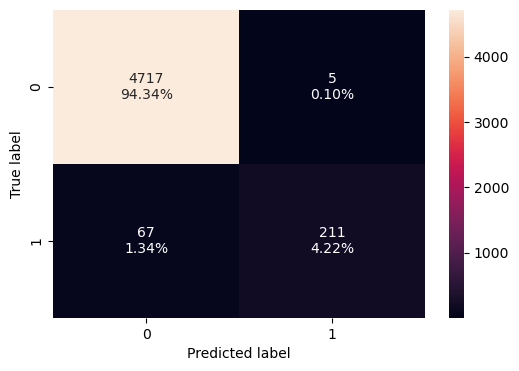

------------------------------------------------------
Model: BaggingClassifier Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.985   0.748      0.977 0.847


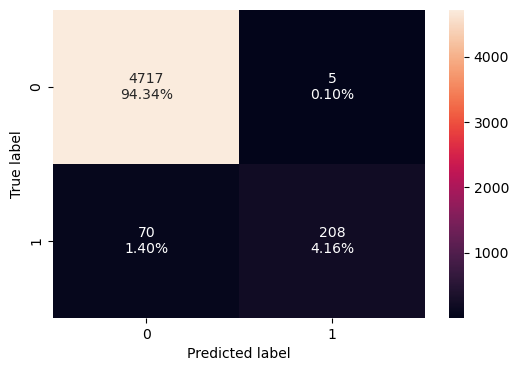

------------------------------------------------------
Model: RandomForest Originial
Training performance:
   Accuracy  Recall  Precision    F1
0     0.995   0.906      1.000 0.951
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.983   0.709      0.985 0.824


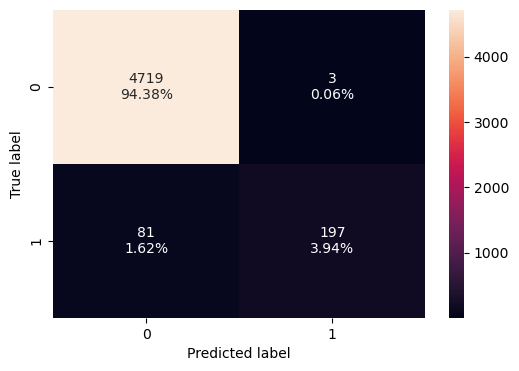

------------------------------------------------------
Model: RandomForest Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.995   0.906      1.000 0.951
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.983   0.709      0.985 0.824


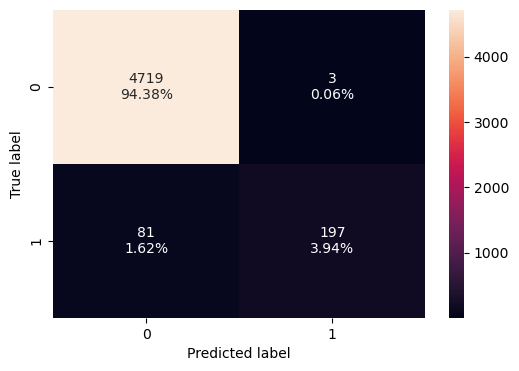

------------------------------------------------------
Model: RandomForest Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.995   0.906      1.000 0.951
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.983   0.709      0.985 0.824


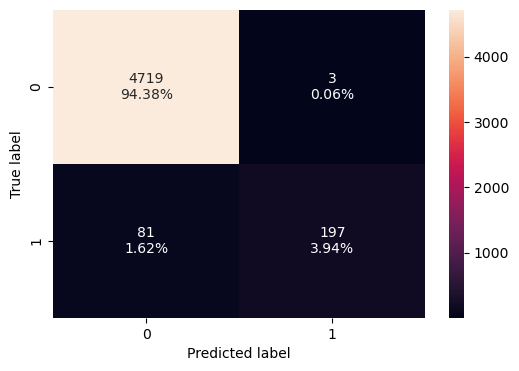

------------------------------------------------------
Model: AdaBoost Orignial
Training performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.758      0.989 0.859
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.982   0.694      0.965 0.808


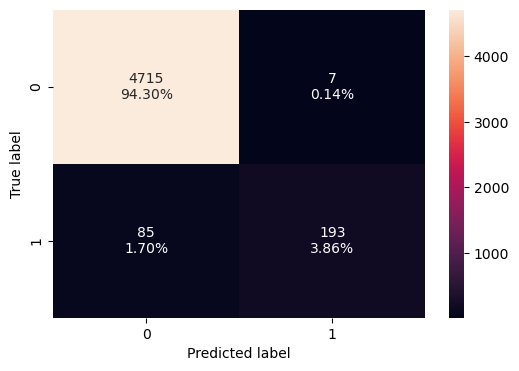

------------------------------------------------------
Model: AdaBoost Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.758      0.989 0.859
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.982   0.694      0.965 0.808


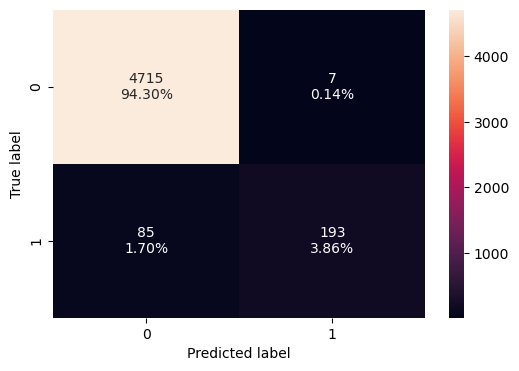

------------------------------------------------------
Model: AdaBoost Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.758      0.989 0.859
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.982   0.694      0.965 0.808


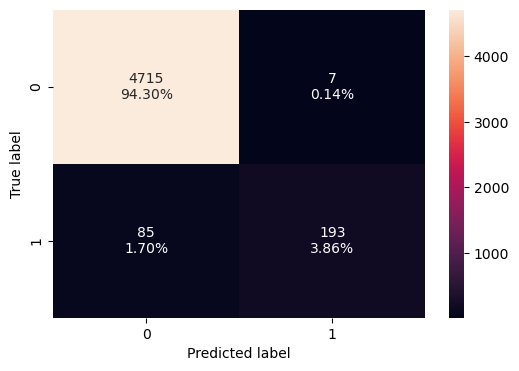

------------------------------------------------------
Model: GradientBoosting Original
Training performance:
   Accuracy  Recall  Precision    F1
0     0.992   0.879      0.984 0.928
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.982   0.763      0.902 0.827


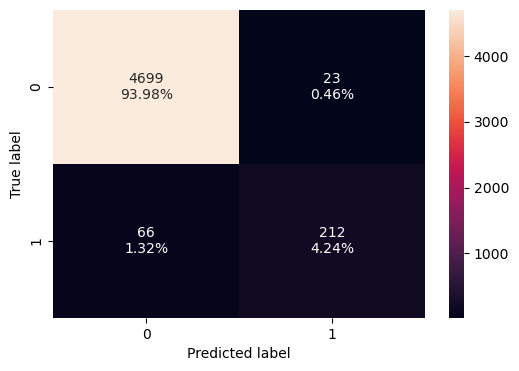

------------------------------------------------------
Model: GradientBoosting Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.987   0.859      0.909 0.883
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.971   0.734      0.742 0.738


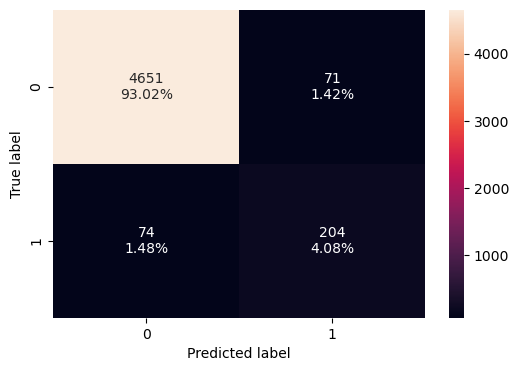

------------------------------------------------------
Model: GradientBoosting Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.992   0.873      0.976 0.921
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.981   0.748      0.893 0.814


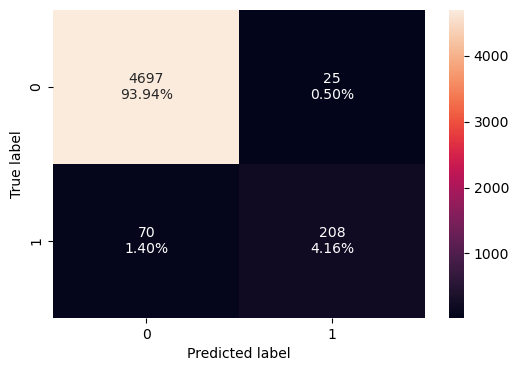

------------------------------------------------------
Model: XGBoost Orignial
Training performance:
   Accuracy  Recall  Precision    F1
0     0.999   1.000      0.986 0.993
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.989   0.853      0.937 0.893


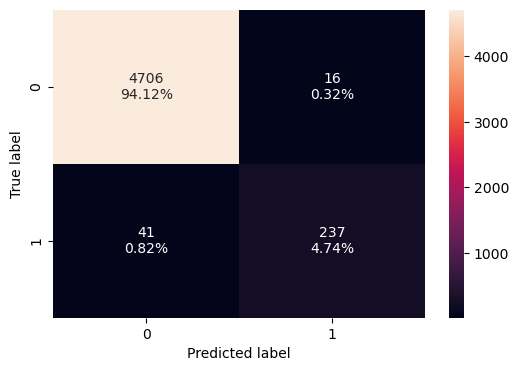

------------------------------------------------------
Model: XGBoost Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.999   1.000      0.988 0.994
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.988   0.860      0.926 0.892


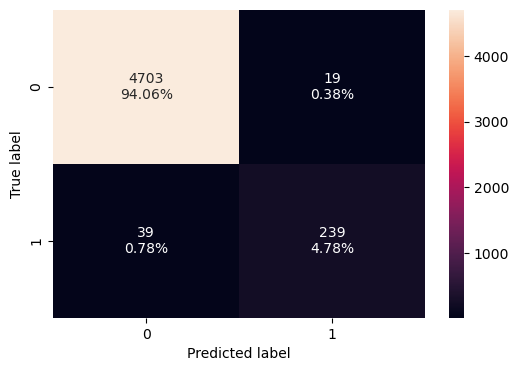

------------------------------------------------------
Model: XGBoost Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.999   1.000      0.979 0.989
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.988   0.863      0.920 0.891


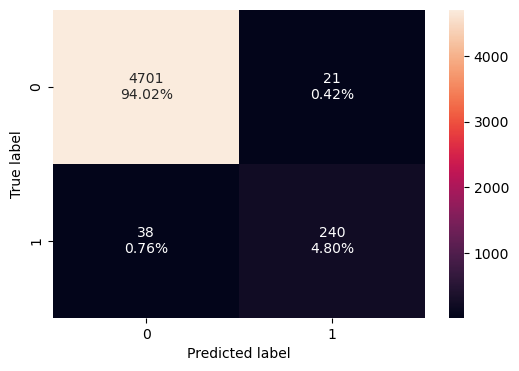

------------------------------------------------------
Model: LogisticRegression Original
Training performance:
   Accuracy  Recall  Precision    F1
0     0.869   0.864      0.279 0.422
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.859   0.849      0.263 0.401


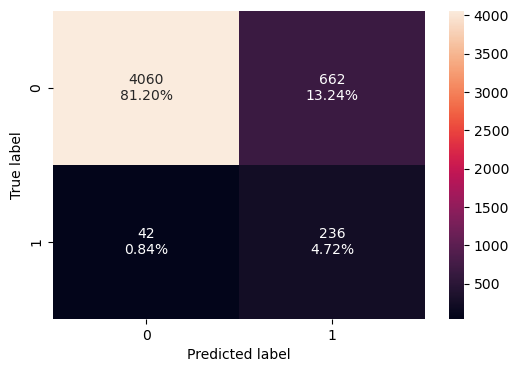

------------------------------------------------------
Model: LogisticRegression Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.966   0.440      0.878 0.586
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.964   0.421      0.867 0.567


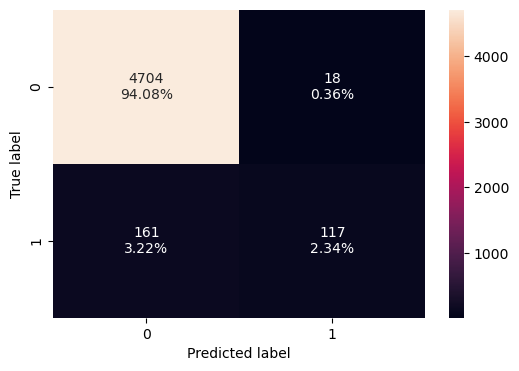

------------------------------------------------------
Model: LogisticRegression Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.869   0.864      0.279 0.422
Validation performance:
   Accuracy  Recall  Precision    F1
0     0.859   0.849      0.263 0.401


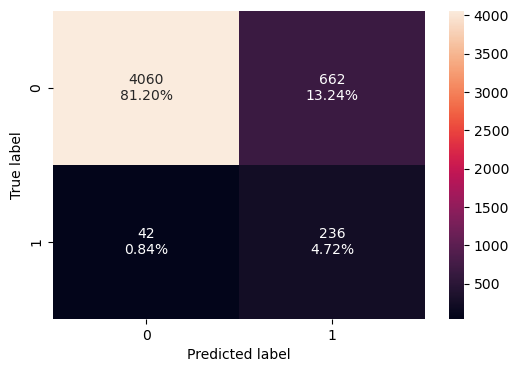

------------------------------------------------------


In [471]:
# iterate through the models dataframe, determine the models scores, and create a confusion matrix
for index, row in models.iterrows():
    Model = row['Models']
    Classifier = row['Classifier']
    Parameters = row['Parameters']

    # Building model with best parameters
    
    model_instance = eval((Classifier) + '(' + Parameters + ', random_state=1)')

    # Fit the model on training data
    model_instance.fit(X_train, y_train)

    trainValue = Model + "_train"
    valValue = Model + "_val"

    # Calculating different metrics on train set
    trainValue = model_performance_classification_sklearn(
        model_instance, X_train, y_train
    )
    
    # Calculating different metrics on validation set
    valValue = model_performance_classification_sklearn(model_instance, X_val, y_val)
    
    # Creating confusion matrix immediately after validation performance
    confusion_matrix_sklearn(model_instance, X_val, y_val)
    
    # Output results for this model
    print("Model:", Model)
    print("Training performance:")
    print(trainValue)
    print("Validation performance:")
    print(valValue)
    plt.show()
    
    # Adjusting threshold
    
    y_val_pred = (model_instance.predict_proba(X_val)[:, 1] > threshold).astype(int)
    
    # Calculating recall on validation set with adjusted threshold
    recall = recall_score(y_val, y_val_pred)
    
    
    # Add a separator between results of different models
    print("------------------------------------------------------")

#### Observations:

* Most of the tuned models overfit the validation set. The only exception was the Logistic Regression, which performed fairly well on the origianl dataset and the undersampled dataset, but did very poorly on the oversampled dataset


In [475]:
# create a dataframe for the models' scores
Scores = pd.DataFrame ({'Models': ['DecisionTree Originial', 'DecisionTree Oversampled', 'DecisionTree Undersampled',
                                   'Tuned DecisionTree Originial', 'Tuned DecisionTree Oversampled', 'Tuned DecisionTree Undersampled',
                                   'BaggingClassifier Original', 'BaggingClassifier Oversampled', 'BaggingClassifier Undersampled',
                                   'Tuned BaggingClassifier Original', 'Tuned BaggingClassifier Oversampled', 'Tuned BaggingClassifier Undersampled',
                                   'RandomForest Originial', 'RandomForest Oversampled', 'RandomForest Undersampled',
                                   'Tuned RandomForest Originial', 'Tuned RandomForest Oversampled', 'Tuned RandomForest Undersampled',
                                   'AdaBoost Orignial', 'AdaBoost Oversampled', 'AdaBoost Undersampled', 
                                   'Tuned AdaBoost Orignial', 'Tuned AdaBoost Oversampled', 'Tuned AdaBoost Undersampled', 
                                   'GradientBoosting Original', 'GradientBoosting Oversampled', 'GradientBoosting Undersampled',
                                   'Tuned GradientBoosting Original', 'Tuned GradientBoosting Oversampled', 'Tuned GradientBoosting Undersampled',
                                   'XGBoost Orignial', 'XGBoost Oversampled', 'XGBoost Undersampled',
                                   'Tuned XGBoost Orignial', 'Tuned XGBoost Oversampled', 'Tuned XGBoost Undersampled',
                                   'LogisticRegression Original', 'LogisticRegression Oversampled', 'LogisticRegression Undersampled',
                                   'Tuned LogisticRegression Original', 'Tuned LogisticRegression Oversampled', 'Tuned LogisticRegression Undersampled'],
                   'Train Recall': [0.698,0.972,0.861,0.891,0.885,0.788,
                                    0.721,0.976,0.864,1.00,1.00,1.00,
                                    0.727,0.984,0.904,0.906,0.906,0.906,
                                    0.631,0.898,0.867,0.758,0.758,0.758,
                                    0.707,0.926,0.899,0.879,0.859,0.873,
                                    0.796,0.990,0.907,1.00,1.00,1.00,
                                    0.493,0.884,0.873,0.864,0.440,0.864],
              'Validation Recall': [0.705,0.777,0.842,0.730,0.737,0.712,
                                    0.730,0.835,0.871,0.759,0.759,0.748,
                                    0.727,0.849,0.892,0.709,0.709,0.709,
                                    0.676,0.856,0.849,0.694,0.694,0.694,
                                    0.723,0.878,0.888,0.763,0.734,0.748,
                                    0.820,0.867,0.903,0.853,0.860,0.863,
                                    0.482,0.849,0.853,0.849,0.421,0.849]})
Scores   

Models  Train Recall  Validation Recall
0                  DecisionTree Originial         0.698              0.705
1                DecisionTree Oversampled         0.972              0.777
2               DecisionTree Undersampled         0.861              0.842
3            Tuned DecisionTree Originial         0.891              0.730
4          Tuned DecisionTree Oversampled         0.885              0.737
5         Tuned DecisionTree Undersampled         0.788              0.712
6              BaggingClassifier Original         0.721              0.730
7           BaggingClassifier Oversampled         0.976              0.835
8          BaggingClassifier Undersampled         0.864              0.871
9        Tuned BaggingClassifier Original         1.000              0.759
10    Tuned BaggingClassifier Oversampled         1.000              0.759
11   Tuned BaggingClassifier Undersampled         1.000              0.748
12                 RandomForest Originial         0.727              0.727
13               RandomForest Oversampled         0.984              0.849
14              RandomForest Undersampled         0.904              0.892
15           Tuned RandomForest Originial         0.906              0.709
16         Tuned RandomForest Oversampled         0.906              0.709
17        Tuned RandomForest Undersampled         0.906              0.709
18                      AdaBoost Orignial         0.631              0.676
19                   AdaBoost Oversampled         0.898              0.856
20                  AdaBoost Undersampled         0.867              0.849
21                Tuned AdaBoost Orignial         0.758              0.694
22             Tuned AdaBoost Oversampled         0.758              0.694
23            Tuned AdaBoost Undersampled         0.758              0.694
24              GradientBoosting Original         0.707              0.723
25           GradientBoosting Oversampled         0.926              0.878
26          GradientBoosting Undersampled         0.899              0.888
27        Tuned GradientBoosting Original         0.879              0.763
28     Tuned GradientBoosting Oversampled         0.859              0.734
29    Tuned GradientBoosting Undersampled         0.873              0.748
30                       XGBoost Orignial         0.796              0.820
31                    XGBoost Oversampled         0.990              0.867
32                   XGBoost Undersampled         0.907              0.903
33                 Tuned XGBoost Orignial         1.000              0.853
34              Tuned XGBoost Oversampled         1.000              0.860
35             Tuned XGBoost Undersampled         1.000              0.863
36            LogisticRegression Original         0.493              0.482
37         LogisticRegression Oversampled         0.884              0.849
38        LogisticRegression Undersampled         0.873              0.853
39      Tuned LogisticRegression Original         0.864              0.849
40   Tuned LogisticRegression Oversampled         0.440              0.421
41  Tuned LogisticRegression Undersampled         0.864              0.849

### Test set final performance

In [477]:
# read in the test data set
df_test = pd.read_csv('test.csv.csv')

In [478]:
#determine test dataframe shape
df_test.shape

(5000, 41)

#### Observations:

* Test set has 5000 rows and 41 columns

In [479]:
# create a copy to keep the orignial from being distorted
df2 = df_test.copy()

In [525]:
# show missing values 
missing_values = []
for column in df2.columns:
    value = df2[column].isna().sum()
    if value != 0:
        missing_values.append((column, value))
if missing_values == []:
    print("No Missing Values")
else:
    print(missing_values)    

[('V1', 5), ('V2', 6)]


In [481]:
# determine missing values and shape
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

#### Observations:

* V1 has 5 missing values and V2 has 6 missing values

In [482]:
# drop Target and create the y_test with the Target variable
X_test = df2.drop('Target', axis = True)
y_test = df2['Target']

In [483]:
# Fit and transform the train data
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

In [526]:
# redetermine missing values
missing_values = []
for column in X_test.columns:
    value = X_test[column].isna().sum()
    if value != 0:
        missing_values.append((column, value))
if missing_values == []:
    print("No Missing Values")
else:
    print(missing_values)   

No Missing Values


#### Observations:

* Missing values have been handled using SimpleImputer

In [485]:
# view shapes of all dataframes
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 40)
(15000,)
(5000, 40)
(5000,)
(5000, 40)
(5000,)


Model: DecisionTree Originial
Training performance:
   Accuracy  Recall  Precision    F1
0     0.992   0.891      0.966 0.927
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.972   0.699      0.779 0.736


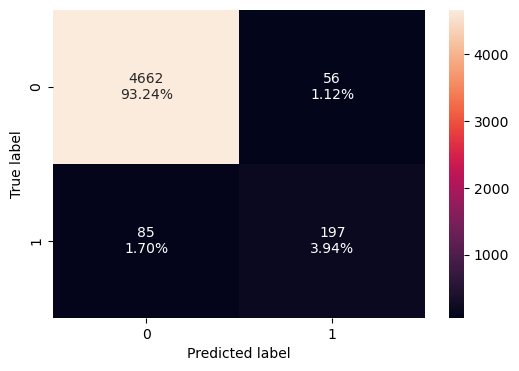

------------------------------------------------------
Model: DecisionTree Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.991   0.885      0.952 0.917
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.971   0.695      0.766 0.729


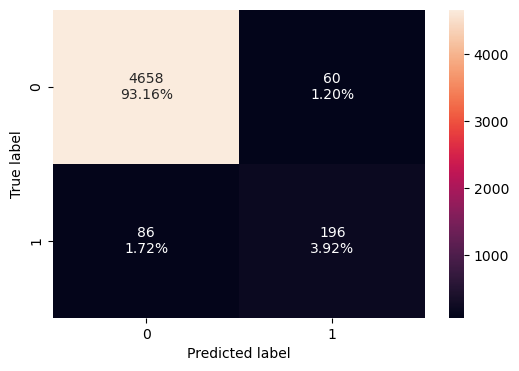

------------------------------------------------------
Model: DecisionTree Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.985   0.788      0.938 0.857
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.971   0.635      0.814 0.713


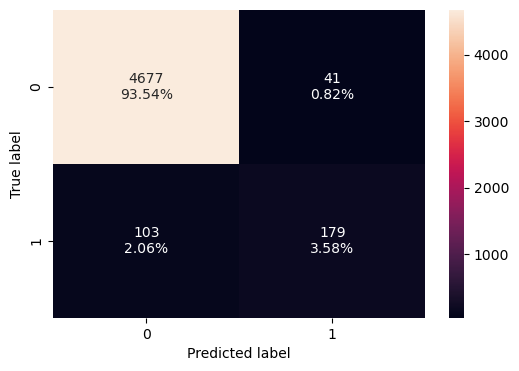

------------------------------------------------------
Model: BaggingClassifier Original
Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.984   0.745      0.959 0.838


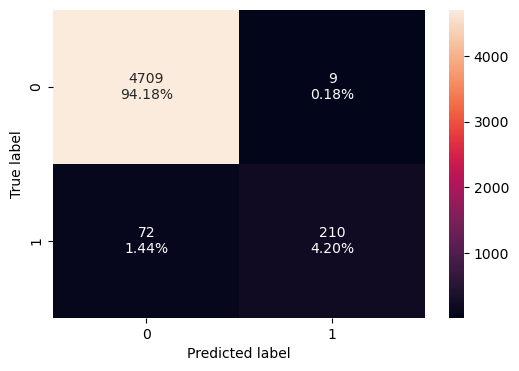

------------------------------------------------------
Model: BaggingClassifier Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.984   0.745      0.959 0.838


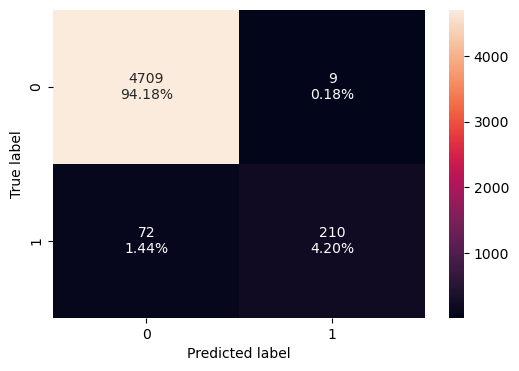

------------------------------------------------------
Model: BaggingClassifier Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.982   0.713      0.957 0.817


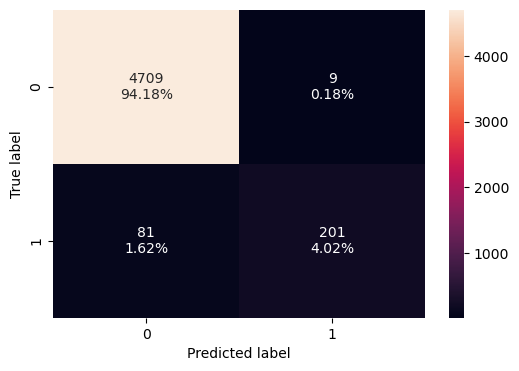

------------------------------------------------------
Model: RandomForest Originial
Training performance:
   Accuracy  Recall  Precision    F1
0     0.995   0.906      1.000 0.951
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.982   0.684      0.985 0.808


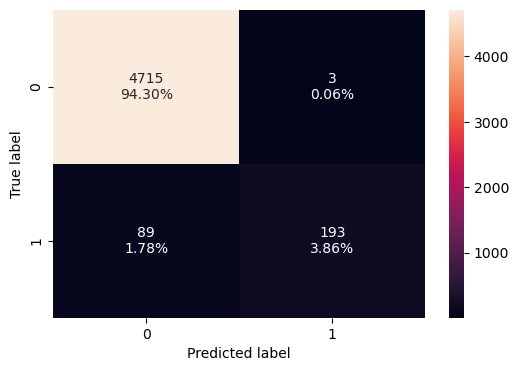

------------------------------------------------------
Model: RandomForest Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.995   0.906      1.000 0.951
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.982   0.684      0.985 0.808


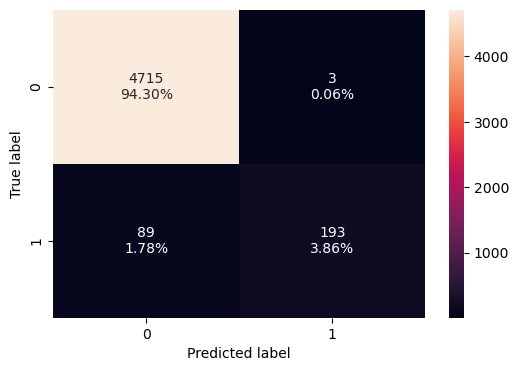

------------------------------------------------------
Model: RandomForest Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.995   0.906      1.000 0.951
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.982   0.684      0.985 0.808


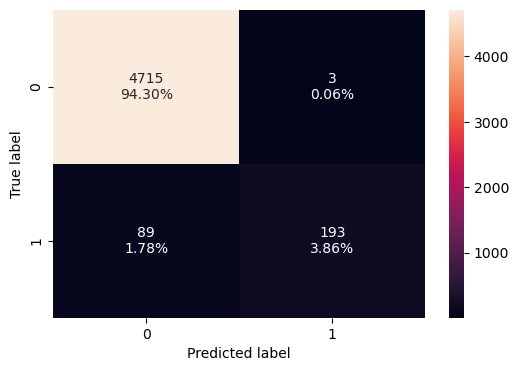

------------------------------------------------------
Model: AdaBoost Orignial
Training performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.758      0.989 0.859
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.980   0.681      0.955 0.795


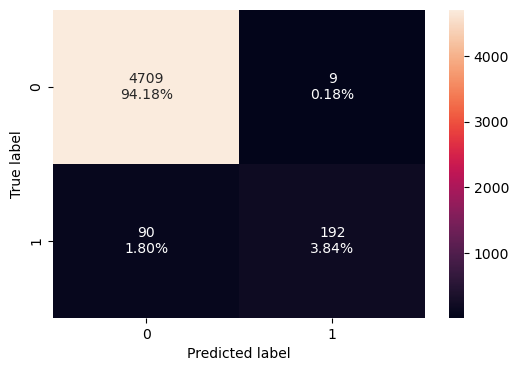

------------------------------------------------------
Model: AdaBoost Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.758      0.989 0.859
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.980   0.681      0.955 0.795


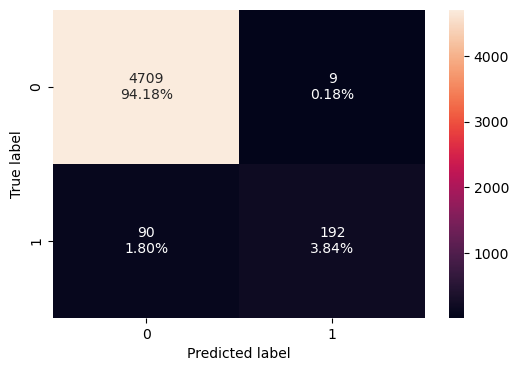

------------------------------------------------------
Model: AdaBoost Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.758      0.989 0.859
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.980   0.681      0.955 0.795


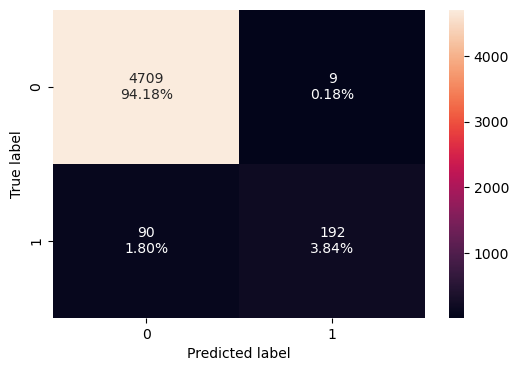

------------------------------------------------------
Model: GradientBoosting Original
Training performance:
   Accuracy  Recall  Precision    F1
0     0.992   0.879      0.984 0.928
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.978   0.716      0.878 0.789


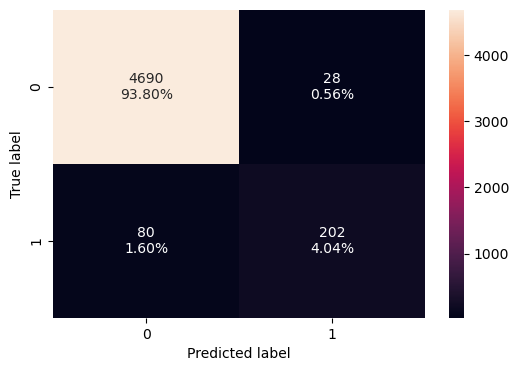

------------------------------------------------------
Model: GradientBoosting Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.987   0.859      0.909 0.883
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.965   0.688      0.693 0.690


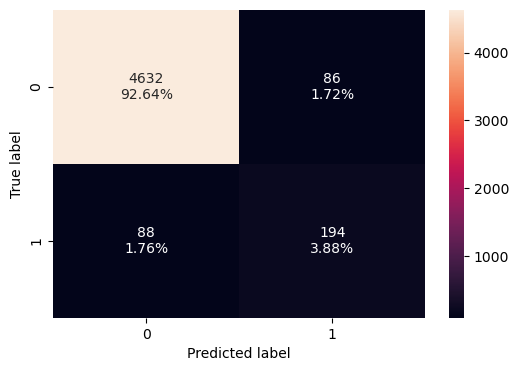

------------------------------------------------------
Model: GradientBoosting Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.992   0.873      0.976 0.921
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.978   0.702      0.888 0.784


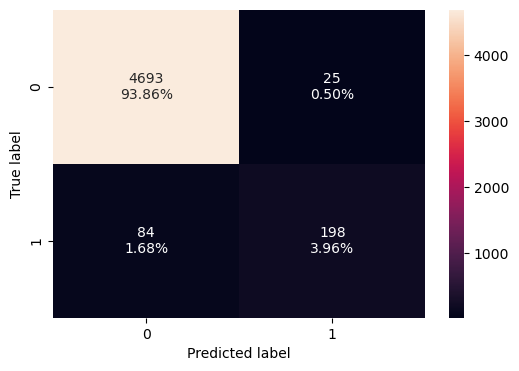

------------------------------------------------------
Model: XGBoost Orignial
Training performance:
   Accuracy  Recall  Precision    F1
0     0.999   1.000      0.986 0.993
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.988   0.837      0.940 0.886


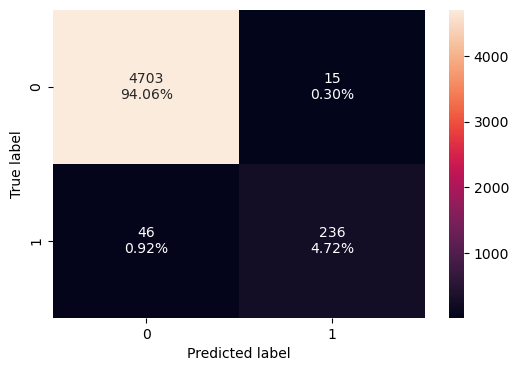

------------------------------------------------------
Model: XGBoost Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.999   1.000      0.988 0.994
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.988   0.844      0.937 0.888


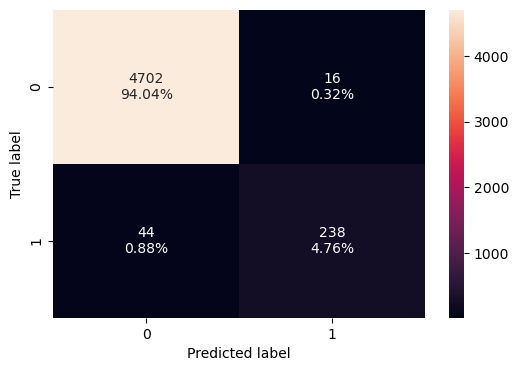

------------------------------------------------------
Model: XGBoost Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.999   1.000      0.979 0.989
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.986   0.837      0.915 0.874


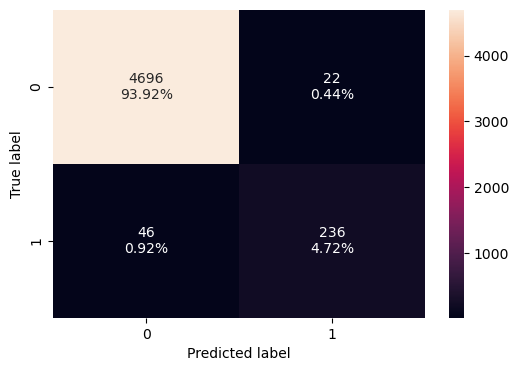

------------------------------------------------------
Model: LogisticRegression Original
Training performance:
   Accuracy  Recall  Precision    F1
0     0.869   0.864      0.279 0.422
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.868   0.809      0.273 0.409


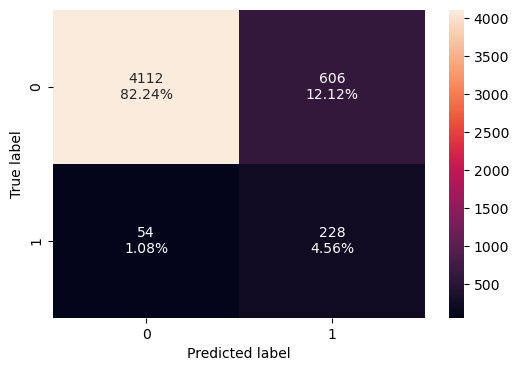

------------------------------------------------------
Model: LogisticRegression Oversampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.966   0.440      0.878 0.586
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.964   0.422      0.881 0.571


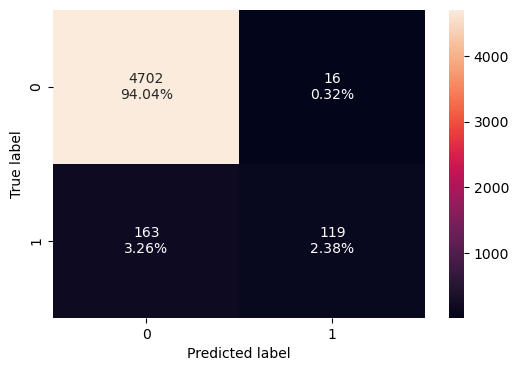

------------------------------------------------------
Model: LogisticRegression Undersampled
Training performance:
   Accuracy  Recall  Precision    F1
0     0.869   0.864      0.279 0.422
Testing performance:
   Accuracy  Recall  Precision    F1
0     0.868   0.809      0.273 0.409


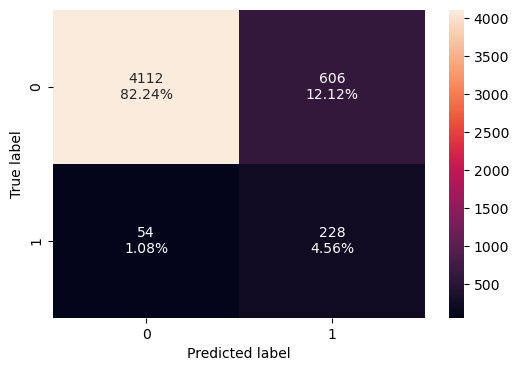

------------------------------------------------------


In [486]:
# Iterate through all models in the models dataframe and view scores and confusion matrix
for index, row in models.iterrows():
    Model = row['Models']
    Classifier = row['Classifier']
    Parameters = row['Parameters']

    # Building model with best parameters
    model_instance = eval((Classifier) + '(' + Parameters + ', random_state=1)')

    # Fit the model on training data
    model_instance.fit(X_train, y_train)

    trainValue = Model + "_train"
    valValue = Model + "_val"

    # Calculating different metrics on train set
    trainValue = model_performance_classification_sklearn(
        model_instance, X_train, y_train
    )
    
    # Calculating different metrics on validation set
    testValue = model_performance_classification_sklearn(model_instance, X_test, y_test)
    
    # Creating confusion matrix immediately after validation performance
    confusion_matrix_sklearn(model_instance, X_test, y_test)
    
    # Output results for this model
    print("Model:", Model)
    print("Training performance:")
    print(trainValue)
    print("Testing performance:")
    print(testValue)
    plt.show()
    
    
    # Add a separator between results of different models
    print("------------------------------------------------------")

#### Observations:

* Similarly to the validation set, the tuned models overfit the testing set on almost every model. The only exception was the oversampled Logistic Regression, which had a very low recall score

In [488]:
%%time
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic Regression", LogisticRegression(random_state=1)))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

print("\n" "Test Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_test, model.predict(X_test))
    print("{}: {}".format(name, scores))


Test Performance:

Bagging: 0.6595744680851063
Random forest: 0.7304964539007093
GBM: 0.6914893617021277
Adaboost: 0.6134751773049646
Xgboost: 0.7943262411347518
dtree: 0.7127659574468085
Logistic Regression: 0.46808510638297873
CPU times: user 1min 20s, sys: 957 ms, total: 1min 21s
Wall time: 1min 24s


#### Observations:

* Great scores all around except for Logistic Regression
* Comparing to Training scores will tell more 

In [489]:
%%time
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic Regression", LogisticRegression(random_state=1)))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

print("\n" "Test Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_test, model.predict(X_test))
    print("{}: {}".format(name, scores))


Test Performance:

Bagging: 0.7695035460992907
Random forest: 0.8333333333333334
GBM: 0.8546099290780141
Adaboost: 0.8191489361702128
Xgboost: 0.8404255319148937
dtree: 0.7659574468085106
Logistic Regression: 0.8085106382978723
CPU times: user 2min 29s, sys: 1.93 s, total: 2min 31s
Wall time: 2min 53s


#### Observations:

* Great scores all around
* Comparing to Training scores will tell more 

In [490]:
%%time
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic Regression", LogisticRegression(random_state=1)))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

print("\n" "Test Performance:" "\n")

for name, model in models:
    model.fit(X_train_under, y_train_under)
    scores = recall_score(y_test, model.predict(X_test))
    print("{}: {}".format(name, scores))


Test Performance:

Bagging: 0.8581560283687943
Random forest: 0.875886524822695
GBM: 0.8687943262411347
Adaboost: 0.8546099290780141
Xgboost: 0.8829787234042553
dtree: 0.8085106382978723
Logistic Regression: 0.8226950354609929
CPU times: user 8.12 s, sys: 241 ms, total: 8.36 s
Wall time: 10.2 s


#### Observations:

* Great scores all around
* Comparing to Training scores will tell more 

In [491]:
# Add test scores to scores dataframe
Scores = pd.DataFrame ({'Models': ['DecisionTree Originial', 'DecisionTree Oversampled', 'DecisionTree Undersampled',
                                   'Tuned DecisionTree Originial', 'Tuned DecisionTree Oversampled', 'Tuned DecisionTree Undersampled',
                                   'BaggingClassifier Original', 'BaggingClassifier Oversampled', 'BaggingClassifier Undersampled',
                                   'Tuned BaggingClassifier Original', 'Tuned BaggingClassifier Oversampled', 'Tuned BaggingClassifier Undersampled',
                                   'RandomForest Originial', 'RandomForest Oversampled', 'RandomForest Undersampled',
                                   'Tuned RandomForest Originial', 'Tuned RandomForest Oversampled', 'Tuned RandomForest Undersampled',
                                   'AdaBoost Orignial', 'AdaBoost Oversampled', 'AdaBoost Undersampled', 
                                   'Tuned AdaBoost Orignial', 'Tuned AdaBoost Oversampled', 'Tuned AdaBoost Undersampled', 
                                   'GradientBoosting Original', 'GradientBoosting Oversampled', 'GradientBoosting Undersampled',
                                   'Tuned GradientBoosting Original', 'Tuned GradientBoosting Oversampled', 'Tuned GradientBoosting Undersampled',
                                   'XGBoost Orignial', 'XGBoost Oversampled', 'XGBoost Undersampled',
                                   'Tuned XGBoost Orignial', 'Tuned XGBoost Oversampled', 'Tuned XGBoost Undersampled',
                                   'LogisticRegression Original', 'LogisticRegression Oversampled', 'LogisticRegression Undersampled',
                                   'Tuned LogisticRegression Original', 'Tuned LogisticRegression Oversampled', 'Tuned LogisticRegression Undersampled'],
                   'Train Recall': [0.698,0.972,0.861,0.891,0.885,0.788,
                                    0.721,0.976,0.864,1.00,1.00,1.00,
                                    0.727,0.984,0.904,0.906,0.906,0.906,
                                    0.631,0.898,0.867,0.758,0.758,0.758,
                                    0.707,0.926,0.899,0.879,0.859,0.873,
                                    0.796,0.990,0.907,1.00,1.00,1.00,
                                    0.493,0.884,0.873,0.864,0.440,0.864],
              'Validation Recall': [0.705,0.777,0.842,0.730,0.737,0.712,
                                    0.730,0.835,0.871,0.759,0.759,0.748,
                                    0.727,0.849,0.892,0.709,0.709,0.709,
                                    0.676,0.856,0.849,0.694,0.694,0.694,
                                    0.723,0.878,0.888,0.763,0.734,0.748,
                                    0.820,0.867,0.903,0.853,0.860,0.863,
                                    0.482,0.849,0.853,0.849,0.421,0.849],
                    'Test Recall': [0.713,0.766,0.809,0.699,0.695,0.635,
                                    0.660,0.770,0.858,0.745,0.745,0.713,
                                    0.730,0.833,0.876,0.684,0.684,0.684,
                                    0.613,0.819,0.855,0.681,0.681,0.681,
                                    0.691,0.855,0.869,0.716,0.688,0.702,
                                    0.794,0.840,0.883,0.837,0.844,0.837,
                                    0.468,0.809,0.823,0.809,0.422,0.809]})
Scores

Models  Train Recall  Validation Recall  \
0                  DecisionTree Originial         0.698              0.705   
1                DecisionTree Oversampled         0.972              0.777   
2               DecisionTree Undersampled         0.861              0.842   
3            Tuned DecisionTree Originial         0.891              0.730   
4          Tuned DecisionTree Oversampled         0.885              0.737   
5         Tuned DecisionTree Undersampled         0.788              0.712   
6              BaggingClassifier Original         0.721              0.730   
7           BaggingClassifier Oversampled         0.976              0.835   
8          BaggingClassifier Undersampled         0.864              0.871   
9        Tuned BaggingClassifier Original         1.000              0.759   
10    Tuned BaggingClassifier Oversampled         1.000              0.759   
11   Tuned BaggingClassifier Undersampled         1.000              0.748   
12                 RandomForest Originial         0.727              0.727   
13               RandomForest Oversampled         0.984              0.849   
14              RandomForest Undersampled         0.904              0.892   
15           Tuned RandomForest Originial         0.906              0.709   
16         Tuned RandomForest Oversampled         0.906              0.709   
17        Tuned RandomForest Undersampled         0.906              0.709   
18                      AdaBoost Orignial         0.631              0.676   
19                   AdaBoost Oversampled         0.898              0.856   
20                  AdaBoost Undersampled         0.867              0.849   
21                Tuned AdaBoost Orignial         0.758              0.694   
22             Tuned AdaBoost Oversampled         0.758              0.694   
23            Tuned AdaBoost Undersampled         0.758              0.694   
24              GradientBoosting Original         0.707              0.723   
25           GradientBoosting Oversampled         0.926              0.878   
26          GradientBoosting Undersampled         0.899              0.888   
27        Tuned GradientBoosting Original         0.879              0.763   
28     Tuned GradientBoosting Oversampled         0.859              0.734   
29    Tuned GradientBoosting Undersampled         0.873              0.748   
30                       XGBoost Orignial         0.796              0.820   
31                    XGBoost Oversampled         0.990              0.867   
32                   XGBoost Undersampled         0.907              0.903   
33                 Tuned XGBoost Orignial         1.000              0.853   
34              Tuned XGBoost Oversampled         1.000              0.860   
35             Tuned XGBoost Undersampled         1.000              0.863   
36            LogisticRegression Original         0.493              0.482   
37         LogisticRegression Oversampled         0.884              0.849   
38        LogisticRegression Undersampled         0.873              0.853   
39      Tuned LogisticRegression Original         0.864              0.849   
40   Tuned LogisticRegression Oversampled         0.440              0.421   
41  Tuned LogisticRegression Undersampled         0.864              0.849   

    Test Recall  
0         0.713  
1         0.766  
2         0.809  
3         0.699  
4         0.695  
5         0.635  
6         0.660  
7         0.770  
8         0.858  
9         0.745  
10        0.745  
11        0.713  
12        0.730  
13        0.833  
14        0.876  
15        0.684  
16        0.684  
17        0.684  
18        0.613  
19        0.819  
20        0.855  
21        0.681  
22        0.681  
23        0.681  
24        0.691  
25        0.855  
26        0.869  
27        0.716  
28        0.688  
29        0.702  
30        0.794  
31        0.840  
32        0.883  
33        0.837  
34        0.844  
35        0.837  
36        0.46

In [514]:
# view models with best recall scores
Best_Models = Scores[
    (Scores['Train Recall'] >= 0.85) &
    (Scores['Validation Recall'] >= Scores['Train Recall'] - 0.05) &
    (Scores['Validation Recall'] <= Scores['Train Recall'] + 0.05) &
    (Scores['Test Recall'] >= Scores['Train Recall'] - 0.05) &
    (Scores['Test Recall'] <= Scores['Train Recall'] + 0.05)
]

Best_Models.rename(columns={'Models':'Best Models'}, inplace = True)

Best_Models

Best Models  Train Recall  Validation Recall  \
8    BaggingClassifier Undersampled         0.864              0.871   
14        RandomForest Undersampled         0.904              0.892   
20            AdaBoost Undersampled         0.867              0.849   
26    GradientBoosting Undersampled         0.899              0.888   
32             XGBoost Undersampled         0.907              0.903   
38  LogisticRegression Undersampled         0.873              0.853   

    Test Recall  
8         0.858  
14        0.876  
20        0.855  
26        0.869  
32        0.883  
38        0.823

#### Observations: 

* None of the hypertuned models met the criteria for Best Model
* Interestingly, all of the best models were the Undersampled models, which were the least computationally heavy
* XGBoost Undersampled is the best model as it has the highest recall score, while not overfitting

In [570]:
# Creating new pipeline with best parameters
Xgboost_under = XGBClassifier(
            random_state = 1
)

Xgboost_under.fit(X_train_under, y_train_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

Featured Importances


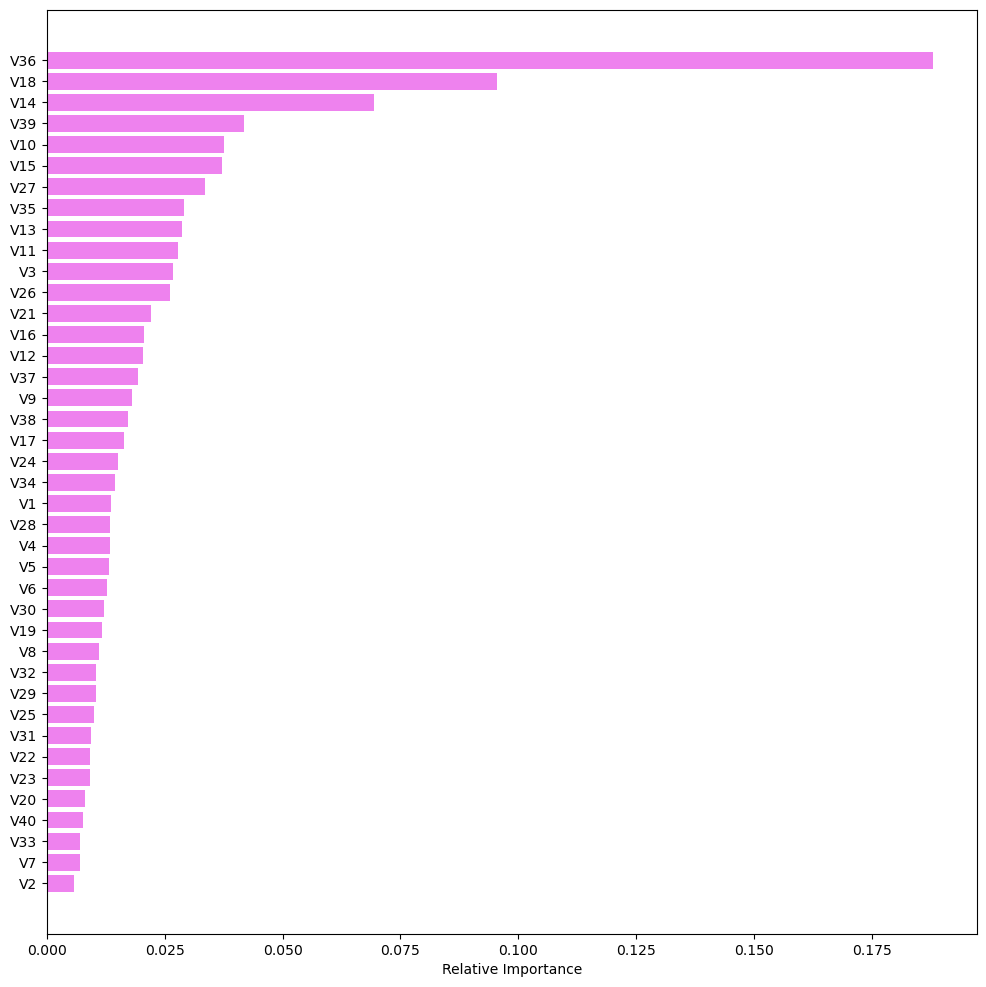

In [582]:
# determine best features for best model
print("Featured Importances")
feature_names = X.columns
importances = Xgboost_under.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### Observations:
    
* The most important features 36, 18, and 14

## Pipelines to build the final model


In [372]:
# creating a list of numerical variables
numerical_features = [
    "V1","V2","V3","V4","V5","V6","V7","V8","V9","V10",
    "V11","V12","V13","V14","V15","V16","V17","V18","V19","V20",
    "V21","V22","V23","V24","V25","V26","V27","V28","V29","V30",
    "V31","V32","V33","V34","V35","V36","V37","V38","V39"
]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])


# creating a list of categorical variables
#categorical_features = ["Target"]

# creating a transformer for categorical variables, which will first apply simple imputer and 
#then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# handle_unknown = "ignore", allows model to handle any unknown category in the test data

# combining categorical transformer and numerical transformer using a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
    ],
    remainder="passthrough",
)
# remainder = "passthrough" has been used, it will allow variables that are present in original data 
# but not in "numerical_columns" and "categorical_columns" to pass through the column transformer without any changes

In [375]:
# Drop Target and create y_test with Target variable
X_test = df_test.drop('Target', axis = 1)
y_test = df_test['Target']

In [506]:
# Creating new pipeline with best parameters

model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "XGBoost",
            XGBClassifier(),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train_under, y_train_under)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28', 'V29',
                                                   'V30', ...])])),
                ('XGBoost',
                 XGBClassi...


In [507]:
# Let's check the performance on test set
Model_train = model_performance_classification_sklearn(model, X_train, y_train)
Model_train

Accuracy  Recall  Precision    F1
0     0.960   1.000      0.579 0.733

In [508]:
# Let's check the performance on test set
Model_test = model_performance_classification_sklearn(model, X_test, y_test)
Model_test

Accuracy  Recall  Precision    F1
0     0.953   0.883      0.551 0.678

#### Observations:

* The pipeline model, like all of the hypertuned models overfit the test data

# Business Insights and Conclusions

## Conclusions:

* The best model, overall, was an XGBoost model with default parameters that was trained on RandomUnderSampled data
* The Pipeline did not improve the model
* It is possible that with more time and better computational resources, better models could have been created that would not have overfit the data so severely


## Business Insights

* The most important factors that affect the lifespan of the generator in a windmill are V36, V18, and V14. What those variables are practically can be determined in the company's codebook
* As we are looking for a model that will maximize the True Positives, while allowing False Positives so long as there are as few False Negatives as possible, we should focus on models that have the highest recal score.
* The XGBoost model with default parameters, which was trained on the RandomUnderSample training set has a recall train score of 0.907 and a recall test score of 0.883. This means that the model does not overfit the testing data and can accurately predict True Positives, while also occassionally predicting False Positives. This model should, however, allow for very few False Negatives. 


***